In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CNN2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:56:15 - loss: 2.3980

  5/581 [..............................] - ETA: 7s - loss: 2.3979     

 13/581 [..............................] - ETA: 4s - loss: 2.3977

 21/581 [>.............................] - ETA: 4s - loss: 2.3973

 30/581 [>.............................] - ETA: 4s - loss: 2.3966

 39/581 [=>............................] - ETA: 3s - loss: 2.3950

 48/581 [=>............................] - ETA: 3s - loss: 2.3919

 57/581 [=>............................] - ETA: 3s - loss: 2.3873

 66/581 [==>...........................] - ETA: 3s - loss: 2.3822

 75/581 [==>...........................] - ETA: 3s - loss: 2.3769

 84/581 [===>..........................] - ETA: 3s - loss: 2.3718

 93/581 [===>..........................] - ETA: 3s - loss: 2.3668

102/581 [====>.........................] - ETA: 3s - loss: 2.3620

111/581 [====>.........................] - ETA: 2s - loss: 2.3575

120/581 [=====>........................] - ETA: 2s - loss: 2.3533

129/581 [=====>........................] - ETA: 2s - loss: 2.3493

138/581 [======>.......................] - ETA: 2s - loss: 2.3455

147/581 [======>.......................] - ETA: 2s - loss: 2.3420

156/581 [=======>......................] - ETA: 2s - loss: 2.3386

165/581 [=======>......................] - ETA: 2s - loss: 2.3354

174/581 [=======>......................] - ETA: 2s - loss: 2.3324

183/581 [========>.....................] - ETA: 2s - loss: 2.3295

192/581 [========>.....................] - ETA: 2s - loss: 2.3266

201/581 [=========>....................] - ETA: 2s - loss: 2.3239

210/581 [=========>....................] - ETA: 2s - loss: 2.3211

219/581 [==========>...................] - ETA: 2s - loss: 2.3184

228/581 [==========>...................] - ETA: 2s - loss: 2.3156

237/581 [===========>..................] - ETA: 2s - loss: 2.3129

246/581 [===========>..................] - ETA: 2s - loss: 2.3101

255/581 [============>.................] - ETA: 1s - loss: 2.3073

264/581 [============>.................] - ETA: 1s - loss: 2.3045

273/581 [=============>................] - ETA: 1s - loss: 2.3017

282/581 [=============>................] - ETA: 1s - loss: 2.2988

291/581 [==============>...............] - ETA: 1s - loss: 2.2960

300/581 [==============>...............] - ETA: 1s - loss: 2.2932

309/581 [==============>...............] - ETA: 1s - loss: 2.2903

318/581 [===============>..............]

 - ETA: 1s - loss: 2.2875

327/581 [===============>..............] - ETA: 1s - loss: 2.2847

336/581 [================>.............] - ETA: 1s - loss: 2.2819

345/581 [================>.............] - ETA: 1s - loss: 2.2791

354/581 [=================>............] - ETA: 1s - loss: 2.2764

363/581 [=================>............] - ETA: 1s - loss: 2.2737

372/581 [==================>...........] - ETA: 1s - loss: 2.2710

381/581 [==================>...........] - ETA: 1s - loss: 2.2683

390/581 [===================>..........] - ETA: 1s - loss: 2.2656

399/581 [===================>..........] - ETA: 1s - loss: 2.2630

408/581 [====================>.........] - ETA: 1s - loss: 2.2604

417/581 [====================>.........] - ETA: 0s - loss: 2.2578

426/581 [====================>.........] - ETA: 0s - loss: 2.2553

435/581 [=====================>........] - ETA: 0s - loss: 2.2528

444/581 [=====================>........] - ETA: 0s - loss: 2.2503

453/581 [======================>.......] - ETA: 0s - loss: 2.2478

462/581 [======================>.......] - ETA: 0s - loss: 2.2454

471/581 [=======================>......] - ETA: 0s - loss: 2.2430

480/581 [=======================>......] - ETA: 0s - loss: 2.2406

489/581 [========================>.....] - ETA: 0s - loss: 2.2383

498/581 [========================>.....] - ETA: 0s - loss: 2.2359

507/581 [=========================>....] - ETA: 0s - loss: 2.2336

516/581 [=========================>....] - ETA: 0s - loss: 2.2314

525/581 [==========================>...] - ETA: 0s - loss: 2.2291

534/581 [==========================>...] - ETA: 0s - loss: 2.2269

543/581 [===========================>..] - ETA: 0s - loss: 2.2247

552/581 [===========================>..] - ETA: 0s - loss: 2.2225

561/581 [===========================>..] - ETA: 0s - loss: 2.2204

570/581 [============================>.] - ETA: 0s - loss: 2.2183

579/581 [============================>.] - ETA: 0s - loss: 2.2162

581/581 [==============================] - 16s 7ms/step - loss: 2.2155 - val_loss: 1.8322


Epoch 2/100
  1/581 [..............................] - ETA: 4s - loss: 1.8813

 10/581 [..............................] - ETA: 3s - loss: 1.9034

 19/581 [..............................] - ETA: 3s - loss: 1.9019

 28/581 [>.............................] - ETA: 3s - loss: 1.9002

 37/581 [>.............................] - ETA: 3s - loss: 1.8994

 46/581 [=>............................] - ETA: 3s - loss: 1.8985

 55/581 [=>............................] - ETA: 3s - loss: 1.8978

 64/581 [==>...........................] - ETA: 3s - loss: 1.8973

 73/581 [==>...........................] - ETA: 2s - loss: 1.8967

 82/581 [===>..........................] - ETA: 2s - loss: 1.8961

 91/581 [===>..........................] - ETA: 2s - loss: 1.8955

100/581 [====>.........................] - ETA: 2s - loss: 1.8951

108/581 [====>.........................] - ETA: 2s - loss: 1.8946

117/581 [=====>........................] - ETA: 2s - loss: 1.8941

126/581 [=====>........................] - ETA: 2s - loss: 1.8937

135/581 [=====>........................] - ETA: 2s - loss: 1.8932

144/581 [======>.......................] - ETA: 2s - loss: 1.8927

153/581 [======>.......................] - ETA: 2s - loss: 1.8922

162/581 [=======>......................] - ETA: 2s - loss: 1.8918

171/581 [=======>......................] - ETA: 2s - loss: 1.8913

180/581 [========>.....................] - ETA: 2s - loss: 1.8909

189/581 [========>.....................] - ETA: 2s - loss: 1.8905

198/581 [=========>....................] - ETA: 2s - loss: 1.8901

207/581 [=========>....................] - ETA: 2s - loss: 1.8898

216/581 [==========>...................] - ETA: 2s - loss: 1.8894

225/581 [==========>...................] - ETA: 2s - loss: 1.8891

234/581 [===========>..................] - ETA: 2s - loss: 1.8887

243/581 [===========>..................] - ETA: 1s - loss: 1.8884

252/581 [============>.................] - ETA: 1s - loss: 1.8880

261/581 [============>.................] - ETA: 1s - loss: 1.8877

270/581 [============>.................] - ETA: 1s - loss: 1.8873

279/581 [=============>................] - ETA: 1s - loss: 1.8870

288/581 [=============>................] - ETA: 1s - loss: 1.8866

297/581 [==============>...............] - ETA: 1s - loss: 1.8863

306/581 [==============>...............] - ETA: 1s - loss: 1.8859

315/581 [===============>..............] - ETA: 1s - loss: 1.8856

324/581 [===============>..............] - ETA: 1s - loss: 1.8852

333/581 [================>.............] - ETA: 1s - loss: 1.8849

342/581 [================>.............] - ETA: 1s - loss: 1.8846

351/581 [=================>............] - ETA: 1s - loss: 1.8843

360/581 [=================>............] - ETA: 1s - loss: 1.8840

369/581 [==================>...........] - ETA: 1s - loss: 1.8837

378/581 [==================>...........] - ETA: 1s - loss: 1.8833



387/581 [==================>...........] - ETA: 1s - loss: 1.8830

395/581 [===================>..........] - ETA: 1s - loss: 1.8828

404/581 [===================>..........] - ETA: 1s - loss: 1.8825

413/581 [====================>.........] - ETA: 0s - loss: 1.8822

422/581 [====================>.........] - ETA: 0s - loss: 1.8819

431/581 [=====================>........] - ETA: 0s - loss: 1.8816

440/581 [=====================>........] - ETA: 0s - loss: 1.8813

449/581 [======================>.......] - ETA: 0s - loss: 1.8810

458/581 [======================>.......] - ETA: 0s - loss: 1.8807

467/581 [=======================>......] - ETA: 0s - loss: 1.8804

476/581 [=======================>......] - ETA: 0s - loss: 1.8801

485/581 [========================>.....] - ETA: 0s - loss: 1.8798

494/581 [========================>.....] - ETA: 0s - loss: 1.8796

503/581 [========================>.....] - ETA: 0s - loss: 1.8793

512/581 [=========================>....] - ETA: 0s - loss: 1.8790

521/581 [=========================>....] - ETA: 0s - loss: 1.8788

530/581 [==========================>...] - ETA: 0s - loss: 1.8785

539/581 [==========================>...] - ETA: 0s - loss: 1.8782

548/581 [===========================>..] - ETA: 0s - loss: 1.8779

557/581 [===========================>..] - ETA: 0s - loss: 1.8777

566/581 [============================>.] - ETA: 0s - loss: 1.8774

575/581 [============================>.] - ETA: 0s - loss: 1.8772

581/581 [==============================] - 4s 6ms/step - loss: 1.8770 - val_loss: 1.7582


Epoch 3/100
  1/581 [..............................] - ETA: 6s - loss: 1.8602

 10/581 [..............................] - ETA: 3s - loss: 1.8516

 19/581 [..............................] - ETA: 3s - loss: 1.8491

 28/581 [>.............................] - ETA: 3s - loss: 1.8478

 37/581 [>.............................] - ETA: 3s - loss: 1.8463

 46/581 [=>............................] - ETA: 3s - loss: 1.8449

 55/581 [=>............................] - ETA: 3s - loss: 1.8440

 64/581 [==>...........................] - ETA: 3s - loss: 1.8431

 73/581 [==>...........................] - ETA: 2s - loss: 1.8423

 82/581 [===>..........................] - ETA: 2s - loss: 1.8416

 91/581 [===>..........................] - ETA: 2s - loss: 1.8409

100/581 [====>.........................] - ETA: 2s - loss: 1.8402

109/581 [====>.........................] - ETA: 2s - loss: 1.8396

118/581 [=====>........................] - ETA: 2s - loss: 1.8391

127/581 [=====>........................] - ETA: 2s - loss: 1.8386

136/581 [======>.......................] - ETA: 2s - loss: 1.8382

145/581 [======>.......................] - ETA: 2s - loss: 1.8378

154/581 [======>.......................] - ETA: 2s - loss: 1.8374

163/581 [=======>......................] - ETA: 2s - loss: 1.8370

172/581 [=======>......................] - ETA: 2s - loss: 1.8366

181/581 [========>.....................] - ETA: 2s - loss: 1.8363

190/581 [========>.....................] - ETA: 2s - loss: 1.8360

199/581 [=========>....................] - ETA: 2s - loss: 1.8357

208/581 [=========>....................] - ETA: 2s - loss: 1.8354

217/581 [==========>...................] - ETA: 2s - loss: 1.8352

226/581 [==========>...................] - ETA: 2s - loss: 1.8349

235/581 [===========>..................] - ETA: 2s - loss: 1.8347

244/581 [===========>..................] - ETA: 1s - loss: 1.8344

253/581 [============>.................] - ETA: 1s - loss: 1.8342

262/581 [============>.................] - ETA: 1s - loss: 1.8340

271/581 [============>.................] - ETA: 1s - loss: 1.8337

280/581 [=============>................] - ETA: 1s - loss: 1.8335

289/581 [=============>................] - ETA: 1s - loss: 1.8333

298/581 [==============>...............] - ETA: 1s - loss: 1.8331

307/581 [==============>...............] - ETA: 1s - loss: 1.8329

316/581 [===============>..............] - ETA: 1s - loss: 1.8327

325/581 [===============>..............] - ETA: 1s - loss: 1.8325

334/581 [================>.............] - ETA: 1s - loss: 1.8324

343/581 [================>.............] - ETA: 1s - loss: 1.8322

352/581 [=================>............] - ETA: 1s - loss: 1.8320

361/581 [=================>............] - ETA: 1s - loss: 1.8318

370/581 [==================>...........] - ETA: 1s - loss: 1.8317

378/581 [==================>...........] - ETA: 1s - loss: 1.8315

387/581 [==================>...........] - ETA: 1s - loss: 1.8314

396/581 [===================>..........] - ETA: 1s - loss: 1.8312

405/581 [===================>..........] - ETA: 1s - loss: 1.8310

414/581 [====================>.........] - ETA: 0s - loss: 1.8309

423/581 [====================>.........] - ETA: 0s - loss: 1.8307

432/581 [=====================>........] - ETA: 0s - loss: 1.8306

441/581 [=====================>........] - ETA: 0s - loss: 1.8304

450/581 [======================>.......] - ETA: 0s - loss: 1.8303

459/581 [======================>.......] - ETA: 0s - loss: 1.8302

468/581 [=======================>......] - ETA: 0s - loss: 1.8300

477/581 [=======================>......] - ETA: 0s - loss: 1.8299

486/581 [========================>.....] - ETA: 0s - loss: 1.8297

495/581 [========================>.....] - ETA: 0s - loss: 1.8296

504/581 [=========================>....] - ETA: 0s - loss: 1.8295

513/581 [=========================>....] - ETA: 0s - loss: 1.8293

522/581 [=========================>....] - ETA: 0s - loss: 1.8292

531/581 [==========================>...] - ETA: 0s - loss: 1.8291

540/581 [==========================>...] - ETA: 0s - loss: 1.8289

549/581 [===========================>..] - ETA: 0s - loss: 1.8288

558/581 [===========================>..] - ETA: 0s - loss: 1.8287

567/581 [============================>.] - ETA: 0s - loss: 1.8285

576/581 [============================>.] - ETA: 0s - loss: 1.8284

581/581 [==============================] - 4s 6ms/step - loss: 1.8283 - val_loss: 1.7404


Epoch 4/100
  1/581 [..............................] - ETA: 4s - loss: 1.8076

 10/581 [..............................] - ETA: 3s - loss: 1.8070

 19/581 [..............................] - ETA: 3s - loss: 1.8074

 28/581 [>.............................] - ETA: 3s - loss: 1.8075

 37/581 [>.............................] - ETA: 3s - loss: 1.8066

 46/581 [=>............................] - ETA: 3s - loss: 1.8060

 55/581 [=>............................] - ETA: 3s - loss: 1.8056

 64/581 [==>...........................] - ETA: 3s - loss: 1.8053

 73/581 [==>...........................] - ETA: 2s - loss: 1.8051

 82/581 [===>..........................] - ETA: 2s - loss: 1.8049

 91/581 [===>..........................] - ETA: 2s - loss: 1.8048

100/581 [====>.........................] - ETA: 2s - loss: 1.8047

109/581 [====>.........................] - ETA: 2s - loss: 1.8046

118/581 [=====>........................] - ETA: 2s - loss: 1.8045

127/581 [=====>........................] - ETA: 2s - loss: 1.8044

136/581 [======>.......................] - ETA: 2s - loss: 1.8043

145/581 [======>.......................] - ETA: 2s - loss: 1.8043

154/581 [======>.......................] - ETA: 2s - loss: 1.8042

163/581 [=======>......................] - ETA: 2s - loss: 1.8042

172/581 [=======>......................] - ETA: 2s - loss: 1.8042

181/581 [========>.....................] - ETA: 2s - loss: 1.8042

190/581 [========>.....................] - ETA: 2s - loss: 1.8042

199/581 [=========>....................] - ETA: 2s - loss: 1.8042

208/581 [=========>....................] - ETA: 2s - loss: 1.8042

217/581 [==========>...................] - ETA: 2s - loss: 1.8042

226/581 [==========>...................] - ETA: 2s - loss: 1.8041

235/581 [===========>..................] - ETA: 2s - loss: 1.8041

244/581 [===========>..................] - ETA: 1s - loss: 1.8041

253/581 [============>.................] - ETA: 1s - loss: 1.8040

262/581 [============>.................] - ETA: 1s - loss: 1.8040

271/581 [============>.................] - ETA: 1s - loss: 1.8039

280/581 [=============>................] - ETA: 1s - loss: 1.8039

289/581 [=============>................] - ETA: 1s - loss: 1.8039

298/581 [==============>...............] - ETA: 1s - loss: 1.8038

307/581 [==============>...............] - ETA: 1s - loss: 1.8038

316/581 [===============>..............] - ETA: 1s - loss: 1.8037

325/581 [===============>..............] - ETA: 1s - loss: 1.8037

334/581 [================>.............] - ETA: 1s - loss: 1.8036

343/581 [================>.............] - ETA: 1s - loss: 1.8036

352/581 [=================>............] - ETA: 1s - loss: 1.8036

361/581 [=================>............] - ETA: 1s - loss: 1.8035

370/581 [==================>...........] - ETA: 1s - loss: 1.8035

379/581 [==================>...........] - ETA: 1s - loss: 1.8034

388/581 [===================>..........] - ETA: 1s - loss: 1.8034

397/581 [===================>..........] - ETA: 1s - loss: 1.8034

406/581 [===================>..........] - ETA: 1s - loss: 1.8033

415/581 [====================>.........] - ETA: 0s - loss: 1.8033

424/581 [====================>.........] - ETA: 0s - loss: 1.8033

433/581 [=====================>........] - ETA: 0s - loss: 1.8032

442/581 [=====================>........] - ETA: 0s - loss: 1.8032

451/581 [======================>.......] - ETA: 0s - loss: 1.8032

460/581 [======================>.......] - ETA: 0s - loss: 1.8031

469/581 [=======================>......] - ETA: 0s - loss: 1.8031

478/581 [=======================>......] - ETA: 0s - loss: 1.8030

487/581 [========================>.....] - ETA: 0s - loss: 1.8030

496/581 [========================>.....] - ETA: 0s - loss: 1.8029

505/581 [=========================>....] - ETA: 0s - loss: 1.8029

514/581 [=========================>....] - ETA: 0s - loss: 1.8028

523/581 [==========================>...] - ETA: 0s - loss: 1.8028

532/581 [==========================>...] - ETA: 0s - loss: 1.8027

541/581 [==========================>...] - ETA: 0s - loss: 1.8027

550/581 [===========================>..] - ETA: 0s - loss: 1.8026

559/581 [===========================>..] - ETA: 0s - loss: 1.8026

568/581 [============================>.] - ETA: 0s - loss: 1.8025

577/581 [============================>.] - ETA: 0s - loss: 1.8025

581/581 [==============================] - 4s 6ms/step - loss: 1.8024 - val_loss: 1.7245


Epoch 5/100
  1/581 [..............................] - ETA: 3s - loss: 1.8064

 10/581 [..............................] - ETA: 3s - loss: 1.8003

 19/581 [..............................] - ETA: 3s - loss: 1.7942

 28/581 [>.............................] - ETA: 3s - loss: 1.7939

 37/581 [>.............................] - ETA: 3s - loss: 1.7932

 46/581 [=>............................] - ETA: 3s - loss: 1.7926

 55/581 [=>............................] - ETA: 3s - loss: 1.7921

 64/581 [==>...........................] - ETA: 3s - loss: 1.7919

 73/581 [==>...........................] - ETA: 3s - loss: 1.7919

 82/581 [===>..........................] - ETA: 2s - loss: 1.7918

 91/581 [===>..........................] - ETA: 2s - loss: 1.7918

100/581 [====>.........................] - ETA: 2s - loss: 1.7917

109/581 [====>.........................] - ETA: 2s - loss: 1.7917

118/581 [=====>........................] - ETA: 2s - loss: 1.7917

126/581 [=====>........................] - ETA: 2s - loss: 1.7917

135/581 [=====>........................] - ETA: 2s - loss: 1.7916

144/581 [======>.......................] - ETA: 2s - loss: 1.7915

153/581 [======>.......................] - ETA: 2s - loss: 1.7914

162/581 [=======>......................] - ETA: 2s - loss: 1.7913

171/581 [=======>......................] - ETA: 2s - loss: 1.7911

180/581 [========>.....................] - ETA: 2s - loss: 1.7910

189/581 [========>.....................] - ETA: 2s - loss: 1.7908

198/581 [=========>....................] - ETA: 2s - loss: 1.7907

207/581 [=========>....................] - ETA: 2s - loss: 1.7906

216/581 [==========>...................] - ETA: 2s - loss: 1.7905

225/581 [==========>...................] - ETA: 2s - loss: 1.7904

234/581 [===========>..................] - ETA: 2s - loss: 1.7903

243/581 [===========>..................] - ETA: 1s - loss: 1.7902

252/581 [============>.................] - ETA: 1s - loss: 1.7901

261/581 [============>.................] - ETA: 1s - loss: 1.7899

270/581 [============>.................] - ETA: 1s - loss: 1.7898

279/581 [=============>................] - ETA: 1s - loss: 1.7897

288/581 [=============>................] - ETA: 1s - loss: 1.7896

297/581 [==============>...............] - ETA: 1s - loss: 1.7895

306/581 [==============>...............] - ETA: 1s - loss: 1.7894

315/581 [===============>..............] - ETA: 1s - loss: 1.7894

324/581 [===============>..............] - ETA: 1s - loss: 1.7893

333/581 [================>.............] - ETA: 1s - loss: 1.7892

342/581 [================>.............] - ETA: 1s - loss: 1.7891

351/581 [=================>............] - ETA: 1s - loss: 1.7890

360/581 [=================>............] - ETA: 1s - loss: 1.7890

369/581 [==================>...........] - ETA: 1s - loss: 1.7889

378/581 [==================>...........] - ETA: 1s - loss: 1.7888

387/581 [==================>...........] - ETA: 1s - loss: 1.7887

396/581 [===================>..........] - ETA: 1s - loss: 1.7887

405/581 [===================>..........] - ETA: 1s - loss: 1.7886

414/581 [====================>.........] - ETA: 0s - loss: 1.7885

423/581 [====================>.........] - ETA: 0s - loss: 1.7885

432/581 [=====================>........] - ETA: 0s - loss: 1.7884

441/581 [=====================>........] - ETA: 0s - loss: 1.7884

450/581 [======================>.......] - ETA: 0s - loss: 1.7883

459/581 [======================>.......] - ETA: 0s - loss: 1.7883

468/581 [=======================>......] - ETA: 0s - loss: 1.7882

477/581 [=======================>......] - ETA: 0s - loss: 1.7882

486/581 [========================>.....] - ETA: 0s - loss: 1.7881



495/581 [========================>.....] - ETA: 0s - loss: 1.7880

504/581 [=========================>....] - ETA: 0s - loss: 1.7880

513/581 [=========================>....] - ETA: 0s - loss: 1.7879

522/581 [=========================>....] - ETA: 0s - loss: 1.7879

531/581 [==========================>...] - ETA: 0s - loss: 1.7878

540/581 [==========================>...] - ETA: 0s - loss: 1.7878

549/581 [===========================>..] - ETA: 0s - loss: 1.7877

558/581 [===========================>..] - ETA: 0s - loss: 1.7877

567/581 [============================>.] - ETA: 0s - loss: 1.7877

576/581 [============================>.] - ETA: 0s - loss: 1.7876

581/581 [==============================] - 4s 6ms/step - loss: 1.7876 - val_loss: 1.7161


Epoch 6/100
  1/581 [..............................] - ETA: 4s - loss: 1.8175

 10/581 [..............................] - ETA: 3s - loss: 1.7991

 19/581 [..............................] - ETA: 3s - loss: 1.7972

 28/581 [>.............................] - ETA: 3s - loss: 1.7954

 37/581 [>.............................] - ETA: 3s - loss: 1.7936

 46/581 [=>............................] - ETA: 3s - loss: 1.7916

 55/581 [=>............................] - ETA: 3s - loss: 1.7900

 64/581 [==>...........................] - ETA: 3s - loss: 1.7887

 73/581 [==>...........................] - ETA: 2s - loss: 1.7877

 82/581 [===>..........................] - ETA: 2s - loss: 1.7869



 91/581 [===>..........................] - ETA: 2s - loss: 1.7863

100/581 [====>.........................] - ETA: 2s - loss: 1.7858

109/581 [====>.........................] - ETA: 2s - loss: 1.7853

118/581 [=====>........................] - ETA: 2s - loss: 1.7849

127/581 [=====>........................] - ETA: 2s - loss: 1.7845



136/581 [======>.......................] - ETA: 2s - loss: 1.7841

145/581 [======>.......................] - ETA: 2s - loss: 1.7838

154/581 [======>.......................] - ETA: 2s - loss: 1.7834

163/581 [=======>......................] - ETA: 2s - loss: 1.7831

172/581 [=======>......................] - ETA: 2s - loss: 1.7828

181/581 [========>.....................] - ETA: 2s - loss: 1.7825

190/581 [========>.....................] - ETA: 2s - loss: 1.7822

199/581 [=========>....................] - ETA: 2s - loss: 1.7820

208/581 [=========>....................] - ETA: 2s - loss: 1.7817

217/581 [==========>...................] - ETA: 2s - loss: 1.7815

226/581 [==========>...................] - ETA: 2s - loss: 1.7813

235/581 [===========>..................] - ETA: 2s - loss: 1.7810

244/581 [===========>..................] - ETA: 1s - loss: 1.7808

253/581 [============>.................] - ETA: 1s - loss: 1.7806

262/581 [============>.................] - ETA: 1s - loss: 1.7804

271/581 [============>.................] - ETA: 1s - loss: 1.7802

280/581 [=============>................] - ETA: 1s - loss: 1.7800

289/581 [=============>................] - ETA: 1s - loss: 1.7799

298/581 [==============>...............] - ETA: 1s - loss: 1.7797

307/581 [==============>...............] - ETA: 1s - loss: 1.7796

316/581 [===============>..............] - ETA: 1s - loss: 1.7795

325/581 [===============>..............] - ETA: 1s - loss: 1.7794

334/581 [================>.............] - ETA: 1s - loss: 1.7793

343/581 [================>.............] - ETA: 1s - loss: 1.7792

352/581 [=================>............] - ETA: 1s - loss: 1.7791

361/581 [=================>............] - ETA: 1s - loss: 1.7790

370/581 [==================>...........] - ETA: 1s - loss: 1.7790

379/581 [==================>...........] - ETA: 1s - loss: 1.7789

388/581 [===================>..........] - ETA: 1s - loss: 1.7788

397/581 [===================>..........] - ETA: 1s - loss: 1.7787

406/581 [===================>..........] - ETA: 1s - loss: 1.7787

415/581 [====================>.........] - ETA: 0s - loss: 1.7786

424/581 [====================>.........] - ETA: 0s - loss: 1.7786

433/581 [=====================>........] - ETA: 0s - loss: 1.7785

442/581 [=====================>........] - ETA: 0s - loss: 1.7784

451/581 [======================>.......] - ETA: 0s - loss: 1.7784

460/581 [======================>.......] - ETA: 0s - loss: 1.7784

469/581 [=======================>......] - ETA: 0s - loss: 1.7783

478/581 [=======================>......] - ETA: 0s - loss: 1.7782

487/581 [========================>.....] - ETA: 0s - loss: 1.7782

496/581 [========================>.....] - ETA: 0s - loss: 1.7782

505/581 [=========================>....] - ETA: 0s - loss: 1.7781



514/581 [=========================>....] - ETA: 0s - loss: 1.7780

523/581 [==========================>...] - ETA: 0s - loss: 1.7780

532/581 [==========================>...] - ETA: 0s - loss: 1.7779

541/581 [==========================>...] - ETA: 0s - loss: 1.7779

550/581 [===========================>..] - ETA: 0s - loss: 1.7779

559/581 [===========================>..] - ETA: 0s - loss: 1.7778

568/581 [============================>.] - ETA: 0s - loss: 1.7778

577/581 [============================>.] - ETA: 0s - loss: 1.7777

581/581 [==============================] - 4s 6ms/step - loss: 1.7777 - val_loss: 1.7061


Epoch 7/100
  1/581 [..............................] - ETA: 3s - loss: 1.7384

 10/581 [..............................] - ETA: 3s - loss: 1.7701

 19/581 [..............................] - ETA: 3s - loss: 1.7735

 28/581 [>.............................] - ETA: 3s - loss: 1.7743

 37/581 [>.............................] - ETA: 3s - loss: 1.7752

 46/581 [=>............................] - ETA: 3s - loss: 1.7758

 55/581 [=>............................] - ETA: 3s - loss: 1.7757

 64/581 [==>...........................] - ETA: 3s - loss: 1.7756

 73/581 [==>...........................] - ETA: 2s - loss: 1.7754

 82/581 [===>..........................] - ETA: 2s - loss: 1.7751

 91/581 [===>..........................] - ETA: 2s - loss: 1.7748

100/581 [====>.........................] - ETA: 2s - loss: 1.7745

109/581 [====>.........................] - ETA: 2s - loss: 1.7742

118/581 [=====>........................] - ETA: 2s - loss: 1.7739

127/581 [=====>........................] - ETA: 2s - loss: 1.7737

136/581 [======>.......................] - ETA: 2s - loss: 1.7735

145/581 [======>.......................] - ETA: 2s - loss: 1.7733

154/581 [======>.......................] - ETA: 2s - loss: 1.7732

163/581 [=======>......................] - ETA: 2s - loss: 1.7731

172/581 [=======>......................] - ETA: 2s - loss: 1.7729

181/581 [========>.....................] - ETA: 2s - loss: 1.7728

190/581 [========>.....................] - ETA: 2s - loss: 1.7727

199/581 [=========>....................] - ETA: 2s - loss: 1.7725

208/581 [=========>....................] - ETA: 2s - loss: 1.7724



217/581 [==========>...................] - ETA: 2s - loss: 1.7722

226/581 [==========>...................] - ETA: 2s - loss: 1.7721

235/581 [===========>..................] - ETA: 2s - loss: 1.7719

244/581 [===========>..................] - ETA: 1s - loss: 1.7718

253/581 [============>.................] - ETA: 1s - loss: 1.7716

262/581 [============>.................] - ETA: 1s - loss: 1.7715

271/581 [============>.................] - ETA: 1s - loss: 1.7714

280/581 [=============>................] - ETA: 1s - loss: 1.7713

289/581 [=============>................] - ETA: 1s - loss: 1.7712

298/581 [==============>...............] - ETA: 1s - loss: 1.7710

307/581 [==============>...............] - ETA: 1s - loss: 1.7709

316/581 [===============>..............] - ETA: 1s - loss: 1.7708

325/581 [===============>..............] - ETA: 1s - loss: 1.7708

334/581 [================>.............] - ETA: 1s - loss: 1.7707

343/581 [================>.............] - ETA: 1s - loss: 1.7706

352/581 [=================>............] - ETA: 1s - loss: 1.7705

361/581 [=================>............] - ETA: 1s - loss: 1.7704

370/581 [==================>...........] - ETA: 1s - loss: 1.7703

379/581 [==================>...........] - ETA: 1s - loss: 1.7702

388/581 [===================>..........] - ETA: 1s - loss: 1.7701

397/581 [===================>..........] - ETA: 1s - loss: 1.7700

406/581 [===================>..........] - ETA: 1s - loss: 1.7699

415/581 [====================>.........] - ETA: 0s - loss: 1.7699

424/581 [====================>.........] - ETA: 0s - loss: 1.7698

432/581 [=====================>........] - ETA: 0s - loss: 1.7697

441/581 [=====================>........] - ETA: 0s - loss: 1.7696

450/581 [======================>.......] - ETA: 0s - loss: 1.7696

459/581 [======================>.......] - ETA: 0s - loss: 1.7695

468/581 [=======================>......] - ETA: 0s - loss: 1.7694

477/581 [=======================>......] - ETA: 0s - loss: 1.7693

486/581 [========================>.....] - ETA: 0s - loss: 1.7693

495/581 [========================>.....] - ETA: 0s - loss: 1.7692

504/581 [=========================>....] - ETA: 0s - loss: 1.7692

513/581 [=========================>....] - ETA: 0s - loss: 1.7691

522/581 [=========================>....] - ETA: 0s - loss: 1.7691

531/581 [==========================>...] - ETA: 0s - loss: 1.7690

540/581 [==========================>...] - ETA: 0s - loss: 1.7690

549/581 [===========================>..] - ETA: 0s - loss: 1.7689

558/581 [===========================>..] - ETA: 0s - loss: 1.7689

567/581 [============================>.] - ETA: 0s - loss: 1.7688

576/581 [============================>.] - ETA: 0s - loss: 1.7688

581/581 [==============================] - 4s 6ms/step - loss: 1.7688 - val_loss: 1.7001


Epoch 8/100
  1/581 [..............................] - ETA: 3s - loss: 1.7497

 10/581 [..............................] - ETA: 3s - loss: 1.7670

 19/581 [..............................] - ETA: 3s - loss: 1.7653

 28/581 [>.............................] - ETA: 3s - loss: 1.7633

 37/581 [>.............................] - ETA: 3s - loss: 1.7624

 46/581 [=>............................] - ETA: 3s - loss: 1.7623

 55/581 [=>............................] - ETA: 3s - loss: 1.7625

 64/581 [==>...........................] - ETA: 3s - loss: 1.7625

 73/581 [==>...........................] - ETA: 2s - loss: 1.7624

 82/581 [===>..........................] - ETA: 2s - loss: 1.7624

 91/581 [===>..........................] - ETA: 2s - loss: 1.7624

100/581 [====>.........................] - ETA: 2s - loss: 1.7624

109/581 [====>.........................] - ETA: 2s - loss: 1.7624

118/581 [=====>........................] - ETA: 2s - loss: 1.7626

127/581 [=====>........................] - ETA: 2s - loss: 1.7627

136/581 [======>.......................] - ETA: 2s - loss: 1.7627

145/581 [======>.......................] - ETA: 2s - loss: 1.7629

154/581 [======>.......................] - ETA: 2s - loss: 1.7629

163/581 [=======>......................] - ETA: 2s - loss: 1.7630

172/581 [=======>......................] - ETA: 2s - loss: 1.7630

181/581 [========>.....................] - ETA: 2s - loss: 1.7630

190/581 [========>.....................] - ETA: 2s - loss: 1.7630

199/581 [=========>....................] - ETA: 2s - loss: 1.7630

208/581 [=========>....................] - ETA: 2s - loss: 1.7630

217/581 [==========>...................] - ETA: 2s - loss: 1.7630

226/581 [==========>...................] - ETA: 2s - loss: 1.7630

235/581 [===========>..................] - ETA: 2s - loss: 1.7630

244/581 [===========>..................] - ETA: 1s - loss: 1.7630

253/581 [============>.................] - ETA: 1s - loss: 1.7629

262/581 [============>.................] - ETA: 1s - loss: 1.7629

271/581 [============>.................] - ETA: 1s - loss: 1.7629

280/581 [=============>................] - ETA: 1s - loss: 1.7628

289/581 [=============>................] - ETA: 1s - loss: 1.7628

298/581 [==============>...............] - ETA: 1s - loss: 1.7628

307/581 [==============>...............] - ETA: 1s - loss: 1.7628

316/581 [===============>..............] - ETA: 1s - loss: 1.7628

325/581 [===============>..............] - ETA: 1s - loss: 1.7628

334/581 [================>.............] - ETA: 1s - loss: 1.7627

343/581 [================>.............] - ETA: 1s - loss: 1.7627

352/581 [=================>............] - ETA: 1s - loss: 1.7627

361/581 [=================>............] - ETA: 1s - loss: 1.7627

370/581 [==================>...........] - ETA: 1s - loss: 1.7626

379/581 [==================>...........] - ETA: 1s - loss: 1.7626

388/581 [===================>..........] - ETA: 1s - loss: 1.7626

397/581 [===================>..........] - ETA: 1s - loss: 1.7626

406/581 [===================>..........] - ETA: 1s - loss: 1.7625



415/581 [====================>.........] - ETA: 0s - loss: 1.7625

424/581 [====================>.........] - ETA: 0s - loss: 1.7625

433/581 [=====================>........] - ETA: 0s - loss: 1.7625

442/581 [=====================>........] - ETA: 0s - loss: 1.7624

451/581 [======================>.......] - ETA: 0s - loss: 1.7624

460/581 [======================>.......] - ETA: 0s - loss: 1.7624

469/581 [=======================>......] - ETA: 0s - loss: 1.7623

478/581 [=======================>......] - ETA: 0s - loss: 1.7623

487/581 [========================>.....] - ETA: 0s - loss: 1.7623

496/581 [========================>.....] - ETA: 0s - loss: 1.7622

505/581 [=========================>....] - ETA: 0s - loss: 1.7622

514/581 [=========================>....] - ETA: 0s - loss: 1.7622

523/581 [==========================>...] - ETA: 0s - loss: 1.7621

532/581 [==========================>...] - ETA: 0s - loss: 1.7621

541/581 [==========================>...] - ETA: 0s - loss: 1.7621

550/581 [===========================>..] - ETA: 0s - loss: 1.7620

559/581 [===========================>..] - ETA: 0s - loss: 1.7620

568/581 [============================>.] - ETA: 0s - loss: 1.7620

577/581 [============================>.] - ETA: 0s - loss: 1.7619

581/581 [==============================] - 4s 6ms/step - loss: 1.7619 - val_loss: 1.7047


Epoch 9/100
  1/581 [..............................] - ETA: 2s - loss: 1.7684

 10/581 [..............................] - ETA: 3s - loss: 1.7637

 19/581 [..............................] - ETA: 3s - loss: 1.7637

 28/581 [>.............................] - ETA: 3s - loss: 1.7625

 37/581 [>.............................] - ETA: 3s - loss: 1.7615

 46/581 [=>............................] - ETA: 3s - loss: 1.7613

 54/581 [=>............................] - ETA: 3s - loss: 1.7608

 63/581 [==>...........................] - ETA: 3s - loss: 1.7604

 72/581 [==>...........................] - ETA: 3s - loss: 1.7602

 81/581 [===>..........................] - ETA: 2s - loss: 1.7599

 90/581 [===>..........................] - ETA: 2s - loss: 1.7595

 99/581 [====>.........................] - ETA: 2s - loss: 1.7592

108/581 [====>.........................] - ETA: 2s - loss: 1.7590

117/581 [=====>........................] - ETA: 2s - loss: 1.7588

126/581 [=====>........................] - ETA: 2s - loss: 1.7586

135/581 [=====>........................] - ETA: 2s - loss: 1.7584

144/581 [======>.......................] - ETA: 2s - loss: 1.7583

153/581 [======>.......................] - ETA: 2s - loss: 1.7581

162/581 [=======>......................] - ETA: 2s - loss: 1.7579

171/581 [=======>......................] - ETA: 2s - loss: 1.7578

180/581 [========>.....................] - ETA: 2s - loss: 1.7578

189/581 [========>.....................] - ETA: 2s - loss: 1.7577

198/581 [=========>....................] - ETA: 2s - loss: 1.7576

207/581 [=========>....................] - ETA: 2s - loss: 1.7576

216/581 [==========>...................] - ETA: 2s - loss: 1.7575

225/581 [==========>...................] - ETA: 2s - loss: 1.7574



234/581 [===========>..................] - ETA: 2s - loss: 1.7574

243/581 [===========>..................] - ETA: 1s - loss: 1.7573

252/581 [============>.................] - ETA: 1s - loss: 1.7573

262/581 [============>.................] - ETA: 1s - loss: 1.7572

271/581 [============>.................] - ETA: 1s - loss: 1.7571

280/581 [=============>................] - ETA: 1s - loss: 1.7570

289/581 [=============>................] - ETA: 1s - loss: 1.7569

298/581 [==============>...............] - ETA: 1s - loss: 1.7568

307/581 [==============>...............] - ETA: 1s - loss: 1.7567

316/581 [===============>..............] - ETA: 1s - loss: 1.7566

325/581 [===============>..............] - ETA: 1s - loss: 1.7565

334/581 [================>.............] - ETA: 1s - loss: 1.7564

343/581 [================>.............] - ETA: 1s - loss: 1.7564

352/581 [=================>............] - ETA: 1s - loss: 1.7563

361/581 [=================>............] - ETA: 1s - loss: 1.7562

370/581 [==================>...........] - ETA: 1s - loss: 1.7561

379/581 [==================>...........] - ETA: 1s - loss: 1.7561

388/581 [===================>..........] - ETA: 1s - loss: 1.7560

397/581 [===================>..........] - ETA: 1s - loss: 1.7560

406/581 [===================>..........] - ETA: 1s - loss: 1.7560

415/581 [====================>.........] - ETA: 0s - loss: 1.7559

424/581 [====================>.........] - ETA: 0s - loss: 1.7559

433/581 [=====================>........] - ETA: 0s - loss: 1.7558

442/581 [=====================>........] - ETA: 0s - loss: 1.7558

451/581 [======================>.......] - ETA: 0s - loss: 1.7558

460/581 [======================>.......] - ETA: 0s - loss: 1.7557

469/581 [=======================>......] - ETA: 0s - loss: 1.7557

478/581 [=======================>......] - ETA: 0s - loss: 1.7556

487/581 [========================>.....] - ETA: 0s - loss: 1.7556

496/581 [========================>.....] - ETA: 0s - loss: 1.7556

505/581 [=========================>....] - ETA: 0s - loss: 1.7555

514/581 [=========================>....] - ETA: 0s - loss: 1.7555

523/581 [==========================>...] - ETA: 0s - loss: 1.7555

532/581 [==========================>...] - ETA: 0s - loss: 1.7554

541/581 [==========================>...] - ETA: 0s - loss: 1.7554

550/581 [===========================>..] - ETA: 0s - loss: 1.7554

559/581 [===========================>..] - ETA: 0s - loss: 1.7554

568/581 [============================>.] - ETA: 0s - loss: 1.7553

577/581 [============================>.] - ETA: 0s - loss: 1.7553



581/581 [==============================] - 4s 6ms/step - loss: 1.7553 - val_loss: 1.6939


Epoch 10/100
  1/581 [..............................] - ETA: 4s - loss: 1.7201

 10/581 [..............................] - ETA: 3s - loss: 1.7370

 19/581 [..............................] - ETA: 3s - loss: 1.7418

 28/581 [>.............................] - ETA: 3s - loss: 1.7436

 37/581 [>.............................] - ETA: 3s - loss: 1.7437

 46/581 [=>............................] - ETA: 3s - loss: 1.7442

 55/581 [=>............................] - ETA: 3s - loss: 1.7441

 64/581 [==>...........................] - ETA: 3s - loss: 1.7441

 73/581 [==>...........................] - ETA: 2s - loss: 1.7441

 82/581 [===>..........................] - ETA: 2s - loss: 1.7442

 91/581 [===>..........................] - ETA: 2s - loss: 1.7443

100/581 [====>.........................] - ETA: 2s - loss: 1.7445

109/581 [====>.........................] - ETA: 2s - loss: 1.7446

118/581 [=====>........................] - ETA: 2s - loss: 1.7449

127/581 [=====>........................] - ETA: 2s - loss: 1.7450

136/581 [======>.......................] - ETA: 2s - loss: 1.7452

145/581 [======>.......................] - ETA: 2s - loss: 1.7454

154/581 [======>.......................] - ETA: 2s - loss: 1.7455

163/581 [=======>......................] - ETA: 2s - loss: 1.7457

172/581 [=======>......................] - ETA: 2s - loss: 1.7459

181/581 [========>.....................] - ETA: 2s - loss: 1.7460

190/581 [========>.....................] - ETA: 2s - loss: 1.7461

199/581 [=========>....................] - ETA: 2s - loss: 1.7462

208/581 [=========>....................] - ETA: 2s - loss: 1.7463

217/581 [==========>...................] - ETA: 2s - loss: 1.7464

226/581 [==========>...................] - ETA: 2s - loss: 1.7465

235/581 [===========>..................] - ETA: 2s - loss: 1.7466

244/581 [===========>..................] - ETA: 1s - loss: 1.7467

253/581 [============>.................] - ETA: 1s - loss: 1.7468

262/581 [============>.................] - ETA: 1s - loss: 1.7468

271/581 [============>.................] - ETA: 1s - loss: 1.7469

280/581 [=============>................] - ETA: 1s - loss: 1.7470

289/581 [=============>................] - ETA: 1s - loss: 1.7471

298/581 [==============>...............] - ETA: 1s - loss: 1.7471

307/581 [==============>...............] - ETA: 1s - loss: 1.7472

316/581 [===============>..............] - ETA: 1s - loss: 1.7472

325/581 [===============>..............] - ETA: 1s - loss: 1.7472

334/581 [================>.............] - ETA: 1s - loss: 1.7472

343/581 [================>.............] - ETA: 1s - loss: 1.7473

352/581 [=================>............] - ETA: 1s - loss: 1.7473

361/581 [=================>............] - ETA: 1s - loss: 1.7473

370/581 [==================>...........] - ETA: 1s - loss: 1.7473

379/581 [==================>...........] - ETA: 1s - loss: 1.7473

388/581 [===================>..........] - ETA: 1s - loss: 1.7473

397/581 [===================>..........] - ETA: 1s - loss: 1.7474

406/581 [===================>..........] - ETA: 1s - loss: 1.7474

415/581 [====================>.........] - ETA: 0s - loss: 1.7474



424/581 [====================>.........] - ETA: 0s - loss: 1.7475

433/581 [=====================>........] - ETA: 0s - loss: 1.7475

442/581 [=====================>........] - ETA: 0s - loss: 1.7475

451/581 [======================>.......] - ETA: 0s - loss: 1.7475

460/581 [======================>.......] - ETA: 0s - loss: 1.7476

469/581 [=======================>......] - ETA: 0s - loss: 1.7476

478/581 [=======================>......] - ETA: 0s - loss: 1.7476

487/581 [========================>.....] - ETA: 0s - loss: 1.7476

496/581 [========================>.....] - ETA: 0s - loss: 1.7476

505/581 [=========================>....] - ETA: 0s - loss: 1.7476

514/581 [=========================>....] - ETA: 0s - loss: 1.7476

523/581 [==========================>...] - ETA: 0s - loss: 1.7477

532/581 [==========================>...] - ETA: 0s - loss: 1.7477

540/581 [==========================>...] - ETA: 0s - loss: 1.7477

549/581 [===========================>..] - ETA: 0s - loss: 1.7477

558/581 [===========================>..] - ETA: 0s - loss: 1.7477

567/581 [============================>.] - ETA: 0s - loss: 1.7477

576/581 [============================>.] - ETA: 0s - loss: 1.7477

581/581 [==============================] - 4s 6ms/step - loss: 1.7478 - val_loss: 1.6915


Epoch 11/100
  1/581 [..............................] - ETA: 5s - loss: 1.7334

 10/581 [..............................] - ETA: 3s - loss: 1.7347

 19/581 [..............................] - ETA: 3s - loss: 1.7378

 27/581 [>.............................] - ETA: 3s - loss: 1.7403

 35/581 [>.............................] - ETA: 3s - loss: 1.7422

 44/581 [=>............................] - ETA: 3s - loss: 1.7432

 53/581 [=>............................] - ETA: 3s - loss: 1.7437

 62/581 [==>...........................] - ETA: 3s - loss: 1.7443

 71/581 [==>...........................] - ETA: 3s - loss: 1.7447

 80/581 [===>..........................] - ETA: 3s - loss: 1.7452

 89/581 [===>..........................] - ETA: 2s - loss: 1.7455

 98/581 [====>.........................] - ETA: 2s - loss: 1.7458

107/581 [====>.........................] - ETA: 2s - loss: 1.7460

117/581 [=====>........................] - ETA: 2s - loss: 1.7463

126/581 [=====>........................] - ETA: 2s - loss: 1.7465

135/581 [=====>........................] - ETA: 2s - loss: 1.7465

144/581 [======>.......................] - ETA: 2s - loss: 1.7466

153/581 [======>.......................] - ETA: 2s - loss: 1.7467

162/581 [=======>......................] - ETA: 2s - loss: 1.7467

171/581 [=======>......................] - ETA: 2s - loss: 1.7468

180/581 [========>.....................] - ETA: 2s - loss: 1.7468

189/581 [========>.....................] - ETA: 2s - loss: 1.7468

198/581 [=========>....................] - ETA: 2s - loss: 1.7468

207/581 [=========>....................] - ETA: 2s - loss: 1.7468

216/581 [==========>...................] - ETA: 2s - loss: 1.7468

225/581 [==========>...................] - ETA: 2s - loss: 1.7467

234/581 [===========>..................] - ETA: 2s - loss: 1.7467

243/581 [===========>..................] - ETA: 2s - loss: 1.7467

252/581 [============>.................] - ETA: 1s - loss: 1.7467

261/581 [============>.................] - ETA: 1s - loss: 1.7467

270/581 [============>.................] - ETA: 1s - loss: 1.7467

279/581 [=============>................] - ETA: 1s - loss: 1.7467

288/581 [=============>................] - ETA: 1s - loss: 1.7466

297/581 [==============>...............] - ETA: 1s - loss: 1.7466

306/581 [==============>...............] - ETA: 1s - loss: 1.7466

315/581 [===============>..............] - ETA: 1s - loss: 1.7466

324/581 [===============>..............] - ETA: 1s - loss: 1.7466

333/581 [================>.............] - ETA: 1s - loss: 1.7465

342/581 [================>.............] - ETA: 1s - loss: 1.7465

351/581 [=================>............] - ETA: 1s - loss: 1.7465

360/581 [=================>............] - ETA: 1s - loss: 1.7465

369/581 [==================>...........] - ETA: 1s - loss: 1.7464

378/581 [==================>...........] - ETA: 1s - loss: 1.7464

387/581 [==================>...........] - ETA: 1s - loss: 1.7464

396/581 [===================>..........] - ETA: 1s - loss: 1.7464

405/581 [===================>..........] - ETA: 1s - loss: 1.7464

414/581 [====================>.........] - ETA: 0s - loss: 1.7463

423/581 [====================>.........] - ETA: 0s - loss: 1.7463

432/581 [=====================>........] - ETA: 0s - loss: 1.7463

441/581 [=====================>........] - ETA: 0s - loss: 1.7462

450/581 [======================>.......] - ETA: 0s - loss: 1.7462

459/581 [======================>.......] - ETA: 0s - loss: 1.7462

468/581 [=======================>......] - ETA: 0s - loss: 1.7462

477/581 [=======================>......] - ETA: 0s - loss: 1.7461

486/581 [========================>.....] - ETA: 0s - loss: 1.7461

495/581 [========================>.....] - ETA: 0s - loss: 1.7461

504/581 [=========================>....] - ETA: 0s - loss: 1.7460

513/581 [=========================>....] - ETA: 0s - loss: 1.7460

522/581 [=========================>....] - ETA: 0s - loss: 1.7460

531/581 [==========================>...] - ETA: 0s - loss: 1.7460

540/581 [==========================>...] - ETA: 0s - loss: 1.7459

549/581 [===========================>..] - ETA: 0s - loss: 1.7459

558/581 [===========================>..] - ETA: 0s - loss: 1.7459

567/581 [============================>.] - ETA: 0s - loss: 1.7459

576/581 [============================>.] - ETA: 0s - loss: 1.7459

581/581 [==============================] - 4s 6ms/step - loss: 1.7458 - val_loss: 1.6922


Epoch 12/100
  1/581 [..............................] - ETA: 3s - loss: 1.7217

 10/581 [..............................] - ETA: 3s - loss: 1.7462

 19/581 [..............................] - ETA: 3s - loss: 1.7456

 28/581 [>.............................] - ETA: 3s - loss: 1.7459

 37/581 [>.............................] - ETA: 3s - loss: 1.7454

 46/581 [=>............................] - ETA: 3s - loss: 1.7450

 55/581 [=>............................] - ETA: 3s - loss: 1.7446

 64/581 [==>...........................] - ETA: 3s - loss: 1.7441



 73/581 [==>...........................] - ETA: 2s - loss: 1.7441

 82/581 [===>..........................] - ETA: 2s - loss: 1.7443



 91/581 [===>..........................] - ETA: 2s - loss: 1.7444

100/581 [====>.........................] - ETA: 2s - loss: 1.7444

109/581 [====>.........................] - ETA: 2s - loss: 1.7445

118/581 [=====>........................] - ETA: 2s - loss: 1.7444

127/581 [=====>........................] - ETA: 2s - loss: 1.7444

136/581 [======>.......................] - ETA: 2s - loss: 1.7444

145/581 [======>.......................] - ETA: 2s - loss: 1.7443

154/581 [======>.......................] - ETA: 2s - loss: 1.7443



163/581 [=======>......................] - ETA: 2s - loss: 1.7443

172/581 [=======>......................] - ETA: 2s - loss: 1.7442

181/581 [========>.....................] - ETA: 2s - loss: 1.7442

190/581 [========>.....................] - ETA: 2s - loss: 1.7442

199/581 [=========>....................] - ETA: 2s - loss: 1.7442

208/581 [=========>....................] - ETA: 2s - loss: 1.7441

217/581 [==========>...................] - ETA: 2s - loss: 1.7441

226/581 [==========>...................] - ETA: 2s - loss: 1.7441

235/581 [===========>..................] - ETA: 2s - loss: 1.7441

244/581 [===========>..................] - ETA: 1s - loss: 1.7441

253/581 [============>.................] - ETA: 1s - loss: 1.7441

262/581 [============>.................] - ETA: 1s - loss: 1.7441

271/581 [============>.................] - ETA: 1s - loss: 1.7441

280/581 [=============>................] - ETA: 1s - loss: 1.7441

289/581 [=============>................] - ETA: 1s - loss: 1.7441

298/581 [==============>...............] - ETA: 1s - loss: 1.7441

307/581 [==============>...............] - ETA: 1s - loss: 1.7441

316/581 [===============>..............] - ETA: 1s - loss: 1.7440

325/581 [===============>..............] - ETA: 1s - loss: 1.7440

334/581 [================>.............] - ETA: 1s - loss: 1.7440

343/581 [================>.............] - ETA: 1s - loss: 1.7439

352/581 [=================>............] - ETA: 1s - loss: 1.7439

361/581 [=================>............] - ETA: 1s - loss: 1.7439

370/581 [==================>...........] - ETA: 1s - loss: 1.7438

379/581 [==================>...........] - ETA: 1s - loss: 1.7438

388/581 [===================>..........] - ETA: 1s - loss: 1.7438

397/581 [===================>..........] - ETA: 1s - loss: 1.7438

406/581 [===================>..........] - ETA: 1s - loss: 1.7438

415/581 [====================>.........] - ETA: 0s - loss: 1.7437

424/581 [====================>.........] - ETA: 0s - loss: 1.7437

433/581 [=====================>........] - ETA: 0s - loss: 1.7437

442/581 [=====================>........] - ETA: 0s - loss: 1.7437

451/581 [======================>.......] - ETA: 0s - loss: 1.7436

460/581 [======================>.......] - ETA: 0s - loss: 1.7436

469/581 [=======================>......] - ETA: 0s - loss: 1.7436

478/581 [=======================>......] - ETA: 0s - loss: 1.7435

487/581 [========================>.....] - ETA: 0s - loss: 1.7435

495/581 [========================>.....] - ETA: 0s - loss: 1.7435

504/581 [=========================>....] - ETA: 0s - loss: 1.7435

513/581 [=========================>....] - ETA: 0s - loss: 1.7434

522/581 [=========================>....] - ETA: 0s - loss: 1.7434

531/581 [==========================>...] - ETA: 0s - loss: 1.7434

540/581 [==========================>...] - ETA: 0s - loss: 1.7434

549/581 [===========================>..] - ETA: 0s - loss: 1.7434

558/581 [===========================>..] - ETA: 0s - loss: 1.7433

567/581 [============================>.] - ETA: 0s - loss: 1.7433

576/581 [============================>.] - ETA: 0s - loss: 1.7433

581/581 [==============================] - 4s 6ms/step - loss: 1.7433 - val_loss: 1.6878


Epoch 13/100
  1/581 [..............................] - ETA: 4s - loss: 1.7413

 10/581 [..............................] - ETA: 3s - loss: 1.7481

 19/581 [..............................] - ETA: 3s - loss: 1.7445

 28/581 [>.............................] - ETA: 3s - loss: 1.7430

 37/581 [>.............................] - ETA: 3s - loss: 1.7422

 46/581 [=>............................] - ETA: 3s - loss: 1.7416

 55/581 [=>............................] - ETA: 3s - loss: 1.7412

 64/581 [==>...........................] - ETA: 3s - loss: 1.7409

 73/581 [==>...........................] - ETA: 3s - loss: 1.7406

 82/581 [===>..........................] - ETA: 2s - loss: 1.7405

 91/581 [===>..........................] - ETA: 2s - loss: 1.7403

100/581 [====>.........................] - ETA: 2s - loss: 1.7402

109/581 [====>.........................] - ETA: 2s - loss: 1.7401

118/581 [=====>........................] - ETA: 2s - loss: 1.7400

127/581 [=====>........................] - ETA: 2s - loss: 1.7399

136/581 [======>.......................] - ETA: 2s - loss: 1.7398

145/581 [======>.......................] - ETA: 2s - loss: 1.7397

154/581 [======>.......................] - ETA: 2s - loss: 1.7397

163/581 [=======>......................] - ETA: 2s - loss: 1.7396

172/581 [=======>......................] - ETA: 2s - loss: 1.7395



181/581 [========>.....................] - ETA: 2s - loss: 1.7395

190/581 [========>.....................] - ETA: 2s - loss: 1.7394

199/581 [=========>....................] - ETA: 2s - loss: 1.7394

208/581 [=========>....................] - ETA: 2s - loss: 1.7393

217/581 [==========>...................] - ETA: 2s - loss: 1.7393

226/581 [==========>...................] - ETA: 2s - loss: 1.7392

235/581 [===========>..................] - ETA: 2s - loss: 1.7392

244/581 [===========>..................] - ETA: 1s - loss: 1.7391

253/581 [============>.................] - ETA: 1s - loss: 1.7391

262/581 [============>.................] - ETA: 1s - loss: 1.7391

271/581 [============>.................] - ETA: 1s - loss: 1.7390

280/581 [=============>................] - ETA: 1s - loss: 1.7390

289/581 [=============>................] - ETA: 1s - loss: 1.7390

298/581 [==============>...............] - ETA: 1s - loss: 1.7389

307/581 [==============>...............] - ETA: 1s - loss: 1.7389

316/581 [===============>..............] - ETA: 1s - loss: 1.7389

325/581 [===============>..............] - ETA: 1s - loss: 1.7388

334/581 [================>.............] - ETA: 1s - loss: 1.7388

343/581 [================>.............] - ETA: 1s - loss: 1.7388

352/581 [=================>............] - ETA: 1s - loss: 1.7388

361/581 [=================>............] - ETA: 1s - loss: 1.7387

370/581 [==================>...........] - ETA: 1s - loss: 1.7387

379/581 [==================>...........] - ETA: 1s - loss: 1.7387

388/581 [===================>..........] - ETA: 1s - loss: 1.7387

397/581 [===================>..........] - ETA: 1s - loss: 1.7387

406/581 [===================>..........] - ETA: 1s - loss: 1.7387

415/581 [====================>.........] - ETA: 0s - loss: 1.7387

424/581 [====================>.........] - ETA: 0s - loss: 1.7387

433/581 [=====================>........] - ETA: 0s - loss: 1.7387

442/581 [=====================>........] - ETA: 0s - loss: 1.7387

451/581 [======================>.......] - ETA: 0s - loss: 1.7387

460/581 [======================>.......] - ETA: 0s - loss: 1.7387

469/581 [=======================>......] - ETA: 0s - loss: 1.7387

478/581 [=======================>......] - ETA: 0s - loss: 1.7387

487/581 [========================>.....] - ETA: 0s - loss: 1.7387

496/581 [========================>.....] - ETA: 0s - loss: 1.7387

505/581 [=========================>....] - ETA: 0s - loss: 1.7387

514/581 [=========================>....] - ETA: 0s - loss: 1.7386

523/581 [==========================>...] - ETA: 0s - loss: 1.7386

532/581 [==========================>...] - ETA: 0s - loss: 1.7386

541/581 [==========================>...] - ETA: 0s - loss: 1.7386

550/581 [===========================>..] - ETA: 0s - loss: 1.7386

559/581 [===========================>..] - ETA: 0s - loss: 1.7386

568/581 [============================>.] - ETA: 0s - loss: 1.7386

577/581 [============================>.] - ETA: 0s - loss: 1.7386

581/581 [==============================] - 4s 6ms/step - loss: 1.7386 - val_loss: 1.6791


Epoch 14/100
  1/581 [..............................] - ETA: 4s - loss: 1.7774

  9/581 [..............................] - ETA: 3s - loss: 1.7567

 18/581 [..............................] - ETA: 3s - loss: 1.7502

 27/581 [>.............................] - ETA: 3s - loss: 1.7478

 36/581 [>.............................] - ETA: 3s - loss: 1.7451

 45/581 [=>............................] - ETA: 3s - loss: 1.7429



 54/581 [=>............................] - ETA: 3s - loss: 1.7411

 63/581 [==>...........................] - ETA: 3s - loss: 1.7401

 72/581 [==>...........................] - ETA: 2s - loss: 1.7393

 81/581 [===>..........................] - ETA: 2s - loss: 1.7385

 90/581 [===>..........................] - ETA: 2s - loss: 1.7378

 99/581 [====>.........................] - ETA: 2s - loss: 1.7372

108/581 [====>.........................] - ETA: 2s - loss: 1.7368

117/581 [=====>........................] - ETA: 2s - loss: 1.7364

126/581 [=====>........................] - ETA: 2s - loss: 1.7362

135/581 [=====>........................] - ETA: 2s - loss: 1.7360

144/581 [======>.......................] - ETA: 2s - loss: 1.7358

153/581 [======>.......................] - ETA: 2s - loss: 1.7356

162/581 [=======>......................] - ETA: 2s - loss: 1.7355

171/581 [=======>......................] - ETA: 2s - loss: 1.7353

180/581 [========>.....................] - ETA: 2s - loss: 1.7352

189/581 [========>.....................] - ETA: 2s - loss: 1.7351

198/581 [=========>....................] - ETA: 2s - loss: 1.7351

207/581 [=========>....................] - ETA: 2s - loss: 1.7350

216/581 [==========>...................] - ETA: 2s - loss: 1.7350

225/581 [==========>...................] - ETA: 2s - loss: 1.7350

234/581 [===========>..................] - ETA: 2s - loss: 1.7350

243/581 [===========>..................] - ETA: 1s - loss: 1.7349

252/581 [============>.................] - ETA: 1s - loss: 1.7349

261/581 [============>.................] - ETA: 1s - loss: 1.7349

270/581 [============>.................] - ETA: 1s - loss: 1.7349

279/581 [=============>................] - ETA: 1s - loss: 1.7349

288/581 [=============>................] - ETA: 1s - loss: 1.7349

297/581 [==============>...............] - ETA: 1s - loss: 1.7349

306/581 [==============>...............] - ETA: 1s - loss: 1.7349

315/581 [===============>..............] - ETA: 1s - loss: 1.7349

324/581 [===============>..............] - ETA: 1s - loss: 1.7349

333/581 [================>.............] - ETA: 1s - loss: 1.7349

343/581 [================>.............] - ETA: 1s - loss: 1.7349

352/581 [=================>............] - ETA: 1s - loss: 1.7349

361/581 [=================>............] - ETA: 1s - loss: 1.7349

370/581 [==================>...........] - ETA: 1s - loss: 1.7349

379/581 [==================>...........] - ETA: 1s - loss: 1.7349

388/581 [===================>..........] - ETA: 1s - loss: 1.7349

397/581 [===================>..........] - ETA: 1s - loss: 1.7349

406/581 [===================>..........] - ETA: 1s - loss: 1.7349

415/581 [====================>.........] - ETA: 0s - loss: 1.7349

424/581 [====================>.........] - ETA: 0s - loss: 1.7349

433/581 [=====================>........] - ETA: 0s - loss: 1.7349

442/581 [=====================>........] - ETA: 0s - loss: 1.7350

451/581 [======================>.......] - ETA: 0s - loss: 1.7350

460/581 [======================>.......] - ETA: 0s - loss: 1.7350

469/581 [=======================>......] - ETA: 0s - loss: 1.7350

478/581 [=======================>......] - ETA: 0s - loss: 1.7350

487/581 [========================>.....] - ETA: 0s - loss: 1.7350

496/581 [========================>.....] - ETA: 0s - loss: 1.7350

505/581 [=========================>....] - ETA: 0s - loss: 1.7350

514/581 [=========================>....] - ETA: 0s - loss: 1.7351

523/581 [==========================>...] - ETA: 0s - loss: 1.7351

532/581 [==========================>...] - ETA: 0s - loss: 1.7351

541/581 [==========================>...] - ETA: 0s - loss: 1.7351

550/581 [===========================>..] - ETA: 0s - loss: 1.7351

559/581 [===========================>..] - ETA: 0s - loss: 1.7351

568/581 [============================>.] - ETA: 0s - loss: 1.7351

577/581 [============================>.] - ETA: 0s - loss: 1.7351

581/581 [==============================] - 4s 6ms/step - loss: 1.7351 - val_loss: 1.6789


Epoch 15/100
  1/581 [..............................] - ETA: 3s - loss: 1.7551

 10/581 [..............................] - ETA: 3s - loss: 1.7337

 19/581 [..............................] - ETA: 3s - loss: 1.7374

 28/581 [>.............................] - ETA: 3s - loss: 1.7392

 37/581 [>.............................] - ETA: 3s - loss: 1.7395

 46/581 [=>............................] - ETA: 3s - loss: 1.7392

 55/581 [=>............................] - ETA: 3s - loss: 1.7392

 64/581 [==>...........................] - ETA: 3s - loss: 1.7390

 73/581 [==>...........................] - ETA: 2s - loss: 1.7387

 82/581 [===>..........................] - ETA: 2s - loss: 1.7384

 91/581 [===>..........................] - ETA: 2s - loss: 1.7381

100/581 [====>.........................] - ETA: 2s - loss: 1.7379

109/581 [====>.........................] - ETA: 2s - loss: 1.7378

118/581 [=====>........................] - ETA: 2s - loss: 1.7376

127/581 [=====>........................] - ETA: 2s - loss: 1.7375

135/581 [=====>........................] - ETA: 2s - loss: 1.7373

144/581 [======>.......................] - ETA: 2s - loss: 1.7371

153/581 [======>.......................] - ETA: 2s - loss: 1.7369

162/581 [=======>......................] - ETA: 2s - loss: 1.7368

171/581 [=======>......................] - ETA: 2s - loss: 1.7366

180/581 [========>.....................] - ETA: 2s - loss: 1.7365

189/581 [========>.....................] - ETA: 2s - loss: 1.7364

198/581 [=========>....................] - ETA: 2s - loss: 1.7363

207/581 [=========>....................] - ETA: 2s - loss: 1.7361

216/581 [==========>...................] - ETA: 2s - loss: 1.7360

224/581 [==========>...................] - ETA: 2s - loss: 1.7359

233/581 [===========>..................] - ETA: 2s - loss: 1.7358

242/581 [===========>..................] - ETA: 2s - loss: 1.7357

250/581 [===========>..................] - ETA: 1s - loss: 1.7356

259/581 [============>.................] - ETA: 1s - loss: 1.7356

268/581 [============>.................] - ETA: 1s - loss: 1.7355

277/581 [=============>................] - ETA: 1s - loss: 1.7354

286/581 [=============>................] - ETA: 1s - loss: 1.7354

295/581 [==============>...............] - ETA: 1s - loss: 1.7353

304/581 [==============>...............] - ETA: 1s - loss: 1.7352

313/581 [===============>..............] - ETA: 1s - loss: 1.7352

322/581 [===============>..............] - ETA: 1s - loss: 1.7351

331/581 [================>.............] - ETA: 1s - loss: 1.7351

340/581 [================>.............] - ETA: 1s - loss: 1.7350

349/581 [=================>............] - ETA: 1s - loss: 1.7350

358/581 [=================>............] - ETA: 1s - loss: 1.7349

367/581 [=================>............] - ETA: 1s - loss: 1.7349

376/581 [==================>...........] - ETA: 1s - loss: 1.7348

385/581 [==================>...........] - ETA: 1s - loss: 1.7348

394/581 [===================>..........] - ETA: 1s - loss: 1.7347

403/581 [===================>..........] - ETA: 1s - loss: 1.7347

412/581 [====================>.........] - ETA: 0s - loss: 1.7346

421/581 [====================>.........] - ETA: 0s - loss: 1.7346

430/581 [=====================>........] - ETA: 0s - loss: 1.7346

439/581 [=====================>........] - ETA: 0s - loss: 1.7345

448/581 [======================>.......] - ETA: 0s - loss: 1.7345

457/581 [======================>.......] - ETA: 0s - loss: 1.7345

466/581 [=======================>......] - ETA: 0s - loss: 1.7344

475/581 [=======================>......] - ETA: 0s - loss: 1.7344

484/581 [=======================>......] - ETA: 0s - loss: 1.7344

493/581 [========================>.....] - ETA: 0s - loss: 1.7344

502/581 [========================>.....] - ETA: 0s - loss: 1.7343

511/581 [=========================>....] - ETA: 0s - loss: 1.7343

520/581 [=========================>....] - ETA: 0s - loss: 1.7343

529/581 [==========================>...] - ETA: 0s - loss: 1.7343

538/581 [==========================>...] - ETA: 0s - loss: 1.7343

547/581 [===========================>..] - ETA: 0s - loss: 1.7343

556/581 [===========================>..] - ETA: 0s - loss: 1.7342

565/581 [============================>.] - ETA: 0s - loss: 1.7342

574/581 [============================>.] - ETA: 0s - loss: 1.7342

581/581 [==============================] - 4s 6ms/step - loss: 1.7342 - val_loss: 1.6770


Epoch 16/100
  1/581 [..............................] - ETA: 4s - loss: 1.7231

 10/581 [..............................] - ETA: 3s - loss: 1.7326

 19/581 [..............................] - ETA: 3s - loss: 1.7315

 28/581 [>.............................] - ETA: 3s - loss: 1.7304

 37/581 [>.............................] - ETA: 3s - loss: 1.7302

 46/581 [=>............................] - ETA: 3s - loss: 1.7301

 55/581 [=>............................] - ETA: 3s - loss: 1.7301

 64/581 [==>...........................] - ETA: 3s - loss: 1.7301

 73/581 [==>...........................] - ETA: 2s - loss: 1.7303

 82/581 [===>..........................] - ETA: 2s - loss: 1.7305

 91/581 [===>..........................] - ETA: 2s - loss: 1.7306

100/581 [====>.........................] - ETA: 2s - loss: 1.7307

109/581 [====>.........................] - ETA: 2s - loss: 1.7308

118/581 [=====>........................] - ETA: 2s - loss: 1.7308

127/581 [=====>........................] - ETA: 2s - loss: 1.7309

136/581 [======>.......................] - ETA: 2s - loss: 1.7309

145/581 [======>.......................] - ETA: 2s - loss: 1.7308

154/581 [======>.......................] - ETA: 2s - loss: 1.7307

163/581 [=======>......................] - ETA: 2s - loss: 1.7306

171/581 [=======>......................] - ETA: 2s - loss: 1.7306

180/581 [========>.....................] - ETA: 2s - loss: 1.7305

189/581 [========>.....................] - ETA: 2s - loss: 1.7304

198/581 [=========>....................] - ETA: 2s - loss: 1.7304

207/581 [=========>....................] - ETA: 2s - loss: 1.7304

216/581 [==========>...................] - ETA: 2s - loss: 1.7303

225/581 [==========>...................] - ETA: 2s - loss: 1.7303

234/581 [===========>..................] - ETA: 2s - loss: 1.7303

243/581 [===========>..................] - ETA: 1s - loss: 1.7302

252/581 [============>.................] - ETA: 1s - loss: 1.7302

261/581 [============>.................] - ETA: 1s - loss: 1.7301

270/581 [============>.................] - ETA: 1s - loss: 1.7301

279/581 [=============>................] - ETA: 1s - loss: 1.7301

288/581 [=============>................] - ETA: 1s - loss: 1.7301

297/581 [==============>...............] - ETA: 1s - loss: 1.7300

306/581 [==============>...............] - ETA: 1s - loss: 1.7300

315/581 [===============>..............] - ETA: 1s - loss: 1.7300

324/581 [===============>..............] - ETA: 1s - loss: 1.7300

333/581 [================>.............] - ETA: 1s - loss: 1.7299

342/581 [================>.............] - ETA: 1s - loss: 1.7299

351/581 [=================>............] - ETA: 1s - loss: 1.7299

360/581 [=================>............] - ETA: 1s - loss: 1.7299

369/581 [==================>...........] - ETA: 1s - loss: 1.7299

378/581 [==================>...........] - ETA: 1s - loss: 1.7299

387/581 [==================>...........] - ETA: 1s - loss: 1.7298

396/581 [===================>..........] - ETA: 1s - loss: 1.7298

405/581 [===================>..........] - ETA: 1s - loss: 1.7298

414/581 [====================>.........] - ETA: 0s - loss: 1.7298

423/581 [====================>.........] - ETA: 0s - loss: 1.7298

432/581 [=====================>........] - ETA: 0s - loss: 1.7298

441/581 [=====================>........] - ETA: 0s - loss: 1.7298

450/581 [======================>.......] - ETA: 0s - loss: 1.7298

459/581 [======================>.......] - ETA: 0s - loss: 1.7298

468/581 [=======================>......] - ETA: 0s - loss: 1.7297

477/581 [=======================>......] - ETA: 0s - loss: 1.7297

486/581 [========================>.....] - ETA: 0s - loss: 1.7297

495/581 [========================>.....] - ETA: 0s - loss: 1.7297

504/581 [=========================>....] - ETA: 0s - loss: 1.7297

513/581 [=========================>....] - ETA: 0s - loss: 1.7297

522/581 [=========================>....] - ETA: 0s - loss: 1.7297

531/581 [==========================>...] - ETA: 0s - loss: 1.7297

540/581 [==========================>...] - ETA: 0s - loss: 1.7297

549/581 [===========================>..] - ETA: 0s - loss: 1.7297

558/581 [===========================>..] - ETA: 0s - loss: 1.7297

567/581 [============================>.] - ETA: 0s - loss: 1.7297

576/581 [============================>.] - ETA: 0s - loss: 1.7297

581/581 [==============================] - 4s 6ms/step - loss: 1.7297 - val_loss: 1.6796


Epoch 17/100
  1/581 [..............................] - ETA: 3s - loss: 1.7305

 10/581 [..............................] - ETA: 3s - loss: 1.7444

 19/581 [..............................] - ETA: 3s - loss: 1.7402

 28/581 [>.............................] - ETA: 3s - loss: 1.7373

 37/581 [>.............................] - ETA: 3s - loss: 1.7360

 46/581 [=>............................] - ETA: 3s - loss: 1.7354

 55/581 [=>............................] - ETA: 3s - loss: 1.7350

 64/581 [==>...........................] - ETA: 3s - loss: 1.7348

 73/581 [==>...........................] - ETA: 2s - loss: 1.7346

 82/581 [===>..........................] - ETA: 2s - loss: 1.7343

 91/581 [===>..........................] - ETA: 2s - loss: 1.7340

100/581 [====>.........................] - ETA: 2s - loss: 1.7338

109/581 [====>.........................] - ETA: 2s - loss: 1.7336

118/581 [=====>........................] - ETA: 2s - loss: 1.7334

127/581 [=====>........................] - ETA: 2s - loss: 1.7332

136/581 [======>.......................] - ETA: 2s - loss: 1.7329

145/581 [======>.......................] - ETA: 2s - loss: 1.7327

154/581 [======>.......................] - ETA: 2s - loss: 1.7325

163/581 [=======>......................] - ETA: 2s - loss: 1.7324

172/581 [=======>......................] - ETA: 2s - loss: 1.7322

181/581 [========>.....................] - ETA: 2s - loss: 1.7320

190/581 [========>.....................] - ETA: 2s - loss: 1.7319

199/581 [=========>....................] - ETA: 2s - loss: 1.7318

208/581 [=========>....................] - ETA: 2s - loss: 1.7317

217/581 [==========>...................] - ETA: 2s - loss: 1.7316

226/581 [==========>...................] - ETA: 2s - loss: 1.7315

235/581 [===========>..................] - ETA: 2s - loss: 1.7314

244/581 [===========>..................] - ETA: 1s - loss: 1.7314



253/581 [============>.................] - ETA: 1s - loss: 1.7313

262/581 [============>.................] - ETA: 1s - loss: 1.7313

271/581 [============>.................] - ETA: 1s - loss: 1.7312

280/581 [=============>................] - ETA: 1s - loss: 1.7311

289/581 [=============>................] - ETA: 1s - loss: 1.7311

298/581 [==============>...............] - ETA: 1s - loss: 1.7310

307/581 [==============>...............] - ETA: 1s - loss: 1.7310

316/581 [===============>..............] - ETA: 1s - loss: 1.7309

325/581 [===============>..............] - ETA: 1s - loss: 1.7308

334/581 [================>.............] - ETA: 1s - loss: 1.7308

343/581 [================>.............] - ETA: 1s - loss: 1.7308

352/581 [=================>............] - ETA: 1s - loss: 1.7307

361/581 [=================>............] - ETA: 1s - loss: 1.7307

370/581 [==================>...........] - ETA: 1s - loss: 1.7307

379/581 [==================>...........] - ETA: 1s - loss: 1.7306

388/581 [===================>..........] - ETA: 1s - loss: 1.7306

397/581 [===================>..........] - ETA: 1s - loss: 1.7305

406/581 [===================>..........] - ETA: 1s - loss: 1.7305

415/581 [====================>.........] - ETA: 0s - loss: 1.7305

424/581 [====================>.........] - ETA: 0s - loss: 1.7304

433/581 [=====================>........] - ETA: 0s - loss: 1.7304

441/581 [=====================>........] - ETA: 0s - loss: 1.7304

450/581 [======================>.......] - ETA: 0s - loss: 1.7303

459/581 [======================>.......] - ETA: 0s - loss: 1.7303

468/581 [=======================>......] - ETA: 0s - loss: 1.7303

477/581 [=======================>......] - ETA: 0s - loss: 1.7302

486/581 [========================>.....] - ETA: 0s - loss: 1.7302

495/581 [========================>.....] - ETA: 0s - loss: 1.7301

504/581 [=========================>....] - ETA: 0s - loss: 1.7301

513/581 [=========================>....] - ETA: 0s - loss: 1.7301

522/581 [=========================>....] - ETA: 0s - loss: 1.7300

531/581 [==========================>...] - ETA: 0s - loss: 1.7300

540/581 [==========================>...] - ETA: 0s - loss: 1.7299

549/581 [===========================>..] - ETA: 0s - loss: 1.7299

558/581 [===========================>..] - ETA: 0s - loss: 1.7299

567/581 [============================>.] - ETA: 0s - loss: 1.7299

576/581 [============================>.] - ETA: 0s - loss: 1.7298

581/581 [==============================] - 4s 6ms/step - loss: 1.7298 - val_loss: 1.6708


Epoch 18/100
  1/581 [..............................] - ETA: 4s - loss: 1.7351

 10/581 [..............................] - ETA: 3s - loss: 1.7280

 19/581 [..............................] - ETA: 3s - loss: 1.7265



 28/581 [>.............................] - ETA: 3s - loss: 1.7263

 37/581 [>.............................] - ETA: 3s - loss: 1.7268

 46/581 [=>............................] - ETA: 3s - loss: 1.7267

 55/581 [=>............................] - ETA: 3s - loss: 1.7266

 64/581 [==>...........................] - ETA: 3s - loss: 1.7266

 73/581 [==>...........................] - ETA: 2s - loss: 1.7266

 82/581 [===>..........................] - ETA: 2s - loss: 1.7265

 91/581 [===>..........................] - ETA: 2s - loss: 1.7263

100/581 [====>.........................] - ETA: 2s - loss: 1.7262

109/581 [====>.........................] - ETA: 2s - loss: 1.7261

118/581 [=====>........................] - ETA: 2s - loss: 1.7260

127/581 [=====>........................] - ETA: 2s - loss: 1.7258

136/581 [======>.......................] - ETA: 2s - loss: 1.7257

145/581 [======>.......................] - ETA: 2s - loss: 1.7256

154/581 [======>.......................] - ETA: 2s - loss: 1.7255

163/581 [=======>......................] - ETA: 2s - loss: 1.7255

172/581 [=======>......................] - ETA: 2s - loss: 1.7254

181/581 [========>.....................] - ETA: 2s - loss: 1.7254

190/581 [========>.....................] - ETA: 2s - loss: 1.7255

199/581 [=========>....................] - ETA: 2s - loss: 1.7255

208/581 [=========>....................] - ETA: 2s - loss: 1.7255

217/581 [==========>...................] - ETA: 2s - loss: 1.7255

226/581 [==========>...................] - ETA: 2s - loss: 1.7255

235/581 [===========>..................] - ETA: 2s - loss: 1.7255

244/581 [===========>..................] - ETA: 1s - loss: 1.7255

253/581 [============>.................] - ETA: 1s - loss: 1.7255

262/581 [============>.................] - ETA: 1s - loss: 1.7255

271/581 [============>.................] - ETA: 1s - loss: 1.7255

280/581 [=============>................] - ETA: 1s - loss: 1.7255

289/581 [=============>................] - ETA: 1s - loss: 1.7255

298/581 [==============>...............] - ETA: 1s - loss: 1.7255

307/581 [==============>...............] - ETA: 1s - loss: 1.7255

316/581 [===============>..............] - ETA: 1s - loss: 1.7255

325/581 [===============>..............] - ETA: 1s - loss: 1.7255

334/581 [================>.............] - ETA: 1s - loss: 1.7255

343/581 [================>.............] - ETA: 1s - loss: 1.7254

352/581 [=================>............] - ETA: 1s - loss: 1.7254

361/581 [=================>............] - ETA: 1s - loss: 1.7254

370/581 [==================>...........] - ETA: 1s - loss: 1.7254

379/581 [==================>...........] - ETA: 1s - loss: 1.7254

388/581 [===================>..........] - ETA: 1s - loss: 1.7253

397/581 [===================>..........] - ETA: 1s - loss: 1.7253

406/581 [===================>..........] - ETA: 1s - loss: 1.7253

415/581 [====================>.........] - ETA: 0s - loss: 1.7253

424/581 [====================>.........] - ETA: 0s - loss: 1.7253

433/581 [=====================>........] - ETA: 0s - loss: 1.7253

442/581 [=====================>........] - ETA: 0s - loss: 1.7252

451/581 [======================>.......] - ETA: 0s - loss: 1.7252

460/581 [======================>.......] - ETA: 0s - loss: 1.7252

469/581 [=======================>......] - ETA: 0s - loss: 1.7252

478/581 [=======================>......] - ETA: 0s - loss: 1.7252

487/581 [========================>.....] - ETA: 0s - loss: 1.7252

496/581 [========================>.....] - ETA: 0s - loss: 1.7251

505/581 [=========================>....] - ETA: 0s - loss: 1.7251

514/581 [=========================>....] - ETA: 0s - loss: 1.7251

523/581 [==========================>...] - ETA: 0s - loss: 1.7251

532/581 [==========================>...] - ETA: 0s - loss: 1.7251

541/581 [==========================>...] - ETA: 0s - loss: 1.7251

550/581 [===========================>..] - ETA: 0s - loss: 1.7251

560/581 [===========================>..] - ETA: 0s - loss: 1.7251

569/581 [============================>.] - ETA: 0s - loss: 1.7251

578/581 [============================>.] - ETA: 0s - loss: 1.7250

581/581 [==============================] - 4s 6ms/step - loss: 1.7250 - val_loss: 1.6702


Epoch 19/100
  1/581 [..............................] - ETA: 4s - loss: 1.6900

 10/581 [..............................] - ETA: 3s - loss: 1.6993

 19/581 [..............................] - ETA: 3s - loss: 1.7051

 28/581 [>.............................] - ETA: 3s - loss: 1.7088

 37/581 [>.............................] - ETA: 3s - loss: 1.7112

 46/581 [=>............................] - ETA: 3s - loss: 1.7126

 55/581 [=>............................] - ETA: 3s - loss: 1.7135

 64/581 [==>...........................] - ETA: 3s - loss: 1.7144

 73/581 [==>...........................] - ETA: 3s - loss: 1.7152

 82/581 [===>..........................] - ETA: 2s - loss: 1.7160

 91/581 [===>..........................] - ETA: 2s - loss: 1.7165

100/581 [====>.........................] - ETA: 2s - loss: 1.7169

109/581 [====>.........................] - ETA: 2s - loss: 1.7172

118/581 [=====>........................] - ETA: 2s - loss: 1.7174

127/581 [=====>........................] - ETA: 2s - loss: 1.7176

136/581 [======>.......................] - ETA: 2s - loss: 1.7178

145/581 [======>.......................] - ETA: 2s - loss: 1.7180

154/581 [======>.......................] - ETA: 2s - loss: 1.7181

163/581 [=======>......................] - ETA: 2s - loss: 1.7182

172/581 [=======>......................] - ETA: 2s - loss: 1.7183

181/581 [========>.....................] - ETA: 2s - loss: 1.7184



190/581 [========>.....................] - ETA: 2s - loss: 1.7184

199/581 [=========>....................] - ETA: 2s - loss: 1.7185

208/581 [=========>....................] - ETA: 2s - loss: 1.7186



217/581 [==========>...................] - ETA: 2s - loss: 1.7187

226/581 [==========>...................] - ETA: 2s - loss: 1.7188

235/581 [===========>..................] - ETA: 2s - loss: 1.7189

244/581 [===========>..................] - ETA: 1s - loss: 1.7190

253/581 [============>.................] - ETA: 1s - loss: 1.7192

262/581 [============>.................] - ETA: 1s - loss: 1.7193

271/581 [============>.................] - ETA: 1s - loss: 1.7194

280/581 [=============>................] - ETA: 1s - loss: 1.7195

289/581 [=============>................] - ETA: 1s - loss: 1.7196

298/581 [==============>...............] - ETA: 1s - loss: 1.7196

307/581 [==============>...............] - ETA: 1s - loss: 1.7197

316/581 [===============>..............] - ETA: 1s - loss: 1.7198

325/581 [===============>..............] - ETA: 1s - loss: 1.7198

334/581 [================>.............] - ETA: 1s - loss: 1.7199

343/581 [================>.............] - ETA: 1s - loss: 1.7199

352/581 [=================>............] - ETA: 1s - loss: 1.7200

361/581 [=================>............] - ETA: 1s - loss: 1.7200

370/581 [==================>...........] - ETA: 1s - loss: 1.7200

379/581 [==================>...........] - ETA: 1s - loss: 1.7201

388/581 [===================>..........] - ETA: 1s - loss: 1.7201

397/581 [===================>..........] - ETA: 1s - loss: 1.7202

406/581 [===================>..........] - ETA: 1s - loss: 1.7202

415/581 [====================>.........] - ETA: 0s - loss: 1.7203

424/581 [====================>.........] - ETA: 0s - loss: 1.7203

433/581 [=====================>........] - ETA: 0s - loss: 1.7204

442/581 [=====================>........] - ETA: 0s - loss: 1.7204

451/581 [======================>.......] - ETA: 0s - loss: 1.7205

460/581 [======================>.......] - ETA: 0s - loss: 1.7205

469/581 [=======================>......] - ETA: 0s - loss: 1.7205

478/581 [=======================>......] - ETA: 0s - loss: 1.7206

487/581 [========================>.....] - ETA: 0s - loss: 1.7206

496/581 [========================>.....] - ETA: 0s - loss: 1.7207

505/581 [=========================>....] - ETA: 0s - loss: 1.7207

514/581 [=========================>....] - ETA: 0s - loss: 1.7207

523/581 [==========================>...] - ETA: 0s - loss: 1.7208

532/581 [==========================>...] - ETA: 0s - loss: 1.7208

541/581 [==========================>...] - ETA: 0s - loss: 1.7208

550/581 [===========================>..] - ETA: 0s - loss: 1.7209

559/581 [===========================>..] - ETA: 0s - loss: 1.7209

568/581 [============================>.] - ETA: 0s - loss: 1.7209

577/581 [============================>.] - ETA: 0s - loss: 1.7209

581/581 [==============================] - 4s 6ms/step - loss: 1.7210 - val_loss: 1.6721


Epoch 20/100
  1/581 [..............................] - ETA: 4s - loss: 1.7598

 10/581 [..............................] - ETA: 3s - loss: 1.7309

 19/581 [..............................] - ETA: 3s - loss: 1.7327

 28/581 [>.............................] - ETA: 3s - loss: 1.7313

 37/581 [>.............................] - ETA: 3s - loss: 1.7305

 46/581 [=>............................] - ETA: 3s - loss: 1.7295

 55/581 [=>............................] - ETA: 3s - loss: 1.7288

 64/581 [==>...........................] - ETA: 3s - loss: 1.7283

 73/581 [==>...........................] - ETA: 2s - loss: 1.7278

 82/581 [===>..........................] - ETA: 2s - loss: 1.7274

 91/581 [===>..........................] - ETA: 2s - loss: 1.7271

100/581 [====>.........................] - ETA: 2s - loss: 1.7269

109/581 [====>.........................] - ETA: 2s - loss: 1.7267

118/581 [=====>........................] - ETA: 2s - loss: 1.7265

127/581 [=====>........................] - ETA: 2s - loss: 1.7264

136/581 [======>.......................] - ETA: 2s - loss: 1.7263

145/581 [======>.......................] - ETA: 2s - loss: 1.7262

154/581 [======>.......................] - ETA: 2s - loss: 1.7260

163/581 [=======>......................] - ETA: 2s - loss: 1.7259

172/581 [=======>......................] - ETA: 2s - loss: 1.7258

181/581 [========>.....................] - ETA: 2s - loss: 1.7257

190/581 [========>.....................] - ETA: 2s - loss: 1.7255

199/581 [=========>....................] - ETA: 2s - loss: 1.7255

208/581 [=========>....................] - ETA: 2s - loss: 1.7254

217/581 [==========>...................] - ETA: 2s - loss: 1.7253

226/581 [==========>...................] - ETA: 2s - loss: 1.7252

235/581 [===========>..................] - ETA: 2s - loss: 1.7251

244/581 [===========>..................] - ETA: 1s - loss: 1.7250

253/581 [============>.................] - ETA: 1s - loss: 1.7249

262/581 [============>.................] - ETA: 1s - loss: 1.7248

271/581 [============>.................] - ETA: 1s - loss: 1.7247

280/581 [=============>................] - ETA: 1s - loss: 1.7247

289/581 [=============>................] - ETA: 1s - loss: 1.7246

298/581 [==============>...............] - ETA: 1s - loss: 1.7245

307/581 [==============>...............] - ETA: 1s - loss: 1.7244

316/581 [===============>..............] - ETA: 1s - loss: 1.7244

325/581 [===============>..............] - ETA: 1s - loss: 1.7243

334/581 [================>.............] - ETA: 1s - loss: 1.7242

343/581 [================>.............] - ETA: 1s - loss: 1.7242

352/581 [=================>............] - ETA: 1s - loss: 1.7241

361/581 [=================>............] - ETA: 1s - loss: 1.7241

370/581 [==================>...........] - ETA: 1s - loss: 1.7240

379/581 [==================>...........] - ETA: 1s - loss: 1.7239

388/581 [===================>..........] - ETA: 1s - loss: 1.7239

397/581 [===================>..........] - ETA: 1s - loss: 1.7238

406/581 [===================>..........] - ETA: 1s - loss: 1.7238



415/581 [====================>.........] - ETA: 0s - loss: 1.7238

424/581 [====================>.........] - ETA: 0s - loss: 1.7237

433/581 [=====================>........] - ETA: 0s - loss: 1.7237

442/581 [=====================>........] - ETA: 0s - loss: 1.7237

451/581 [======================>.......] - ETA: 0s - loss: 1.7236

460/581 [======================>.......] - ETA: 0s - loss: 1.7236

469/581 [=======================>......] - ETA: 0s - loss: 1.7236

477/581 [=======================>......] - ETA: 0s - loss: 1.7235

486/581 [========================>.....] - ETA: 0s - loss: 1.7235

495/581 [========================>.....] - ETA: 0s - loss: 1.7235

504/581 [=========================>....] - ETA: 0s - loss: 1.7235

513/581 [=========================>....] - ETA: 0s - loss: 1.7234

522/581 [=========================>....] - ETA: 0s - loss: 1.7234

531/581 [==========================>...] - ETA: 0s - loss: 1.7234

540/581 [==========================>...] - ETA: 0s - loss: 1.7234

549/581 [===========================>..] - ETA: 0s - loss: 1.7233

558/581 [===========================>..] - ETA: 0s - loss: 1.7233

567/581 [============================>.] - ETA: 0s - loss: 1.7233

576/581 [============================>.] - ETA: 0s - loss: 1.7233



581/581 [==============================] - 4s 6ms/step - loss: 1.7233 - val_loss: 1.6750


Epoch 21/100
  1/581 [..............................] - ETA: 3s - loss: 1.6725

 10/581 [..............................] - ETA: 3s - loss: 1.7052

 19/581 [..............................] - ETA: 3s - loss: 1.7145

 28/581 [>.............................] - ETA: 3s - loss: 1.7167

 37/581 [>.............................] - ETA: 3s - loss: 1.7184

 46/581 [=>............................] - ETA: 3s - loss: 1.7192

 55/581 [=>............................] - ETA: 3s - loss: 1.7198

 64/581 [==>...........................] - ETA: 3s - loss: 1.7204

 73/581 [==>...........................] - ETA: 3s - loss: 1.7206

 82/581 [===>..........................] - ETA: 2s - loss: 1.7207

 91/581 [===>..........................] - ETA: 2s - loss: 1.7207

100/581 [====>.........................] - ETA: 2s - loss: 1.7207

109/581 [====>.........................] - ETA: 2s - loss: 1.7206

118/581 [=====>........................] - ETA: 2s - loss: 1.7205

127/581 [=====>........................] - ETA: 2s - loss: 1.7204

136/581 [======>.......................] - ETA: 2s - loss: 1.7203

145/581 [======>.......................] - ETA: 2s - loss: 1.7202

154/581 [======>.......................] - ETA: 2s - loss: 1.7201

163/581 [=======>......................] - ETA: 2s - loss: 1.7199

172/581 [=======>......................] - ETA: 2s - loss: 1.7198

181/581 [========>.....................] - ETA: 2s - loss: 1.7198

190/581 [========>.....................] - ETA: 2s - loss: 1.7197

199/581 [=========>....................] - ETA: 2s - loss: 1.7197

208/581 [=========>....................] - ETA: 2s - loss: 1.7196

217/581 [==========>...................] - ETA: 2s - loss: 1.7196

226/581 [==========>...................] - ETA: 2s - loss: 1.7196

235/581 [===========>..................] - ETA: 2s - loss: 1.7195

244/581 [===========>..................] - ETA: 1s - loss: 1.7195

253/581 [============>.................] - ETA: 1s - loss: 1.7194

262/581 [============>.................] - ETA: 1s - loss: 1.7194

271/581 [============>.................] - ETA: 1s - loss: 1.7193

280/581 [=============>................] - ETA: 1s - loss: 1.7193

289/581 [=============>................] - ETA: 1s - loss: 1.7192

298/581 [==============>...............] - ETA: 1s - loss: 1.7192

307/581 [==============>...............] - ETA: 1s - loss: 1.7192

316/581 [===============>..............] - ETA: 1s - loss: 1.7191

325/581 [===============>..............] - ETA: 1s - loss: 1.7191

334/581 [================>.............] - ETA: 1s - loss: 1.7190

343/581 [================>.............] - ETA: 1s - loss: 1.7189



352/581 [=================>............] - ETA: 1s - loss: 1.7189

361/581 [=================>............] - ETA: 1s - loss: 1.7188

370/581 [==================>...........] - ETA: 1s - loss: 1.7188

379/581 [==================>...........] - ETA: 1s - loss: 1.7188

388/581 [===================>..........] - ETA: 1s - loss: 1.7187

397/581 [===================>..........] - ETA: 1s - loss: 1.7187

406/581 [===================>..........] - ETA: 1s - loss: 1.7187

415/581 [====================>.........] - ETA: 0s - loss: 1.7186

424/581 [====================>.........] - ETA: 0s - loss: 1.7186

433/581 [=====================>........] - ETA: 0s - loss: 1.7186

442/581 [=====================>........] - ETA: 0s - loss: 1.7186

451/581 [======================>.......] - ETA: 0s - loss: 1.7185

460/581 [======================>.......] - ETA: 0s - loss: 1.7185

469/581 [=======================>......] - ETA: 0s - loss: 1.7185

478/581 [=======================>......] - ETA: 0s - loss: 1.7185

487/581 [========================>.....] - ETA: 0s - loss: 1.7185

496/581 [========================>.....] - ETA: 0s - loss: 1.7185

505/581 [=========================>....] - ETA: 0s - loss: 1.7185



514/581 [=========================>....] - ETA: 0s - loss: 1.7184

523/581 [==========================>...] - ETA: 0s - loss: 1.7184

532/581 [==========================>...] - ETA: 0s - loss: 1.7184

541/581 [==========================>...] - ETA: 0s - loss: 1.7184

550/581 [===========================>..] - ETA: 0s - loss: 1.7184

559/581 [===========================>..] - ETA: 0s - loss: 1.7184

568/581 [============================>.] - ETA: 0s - loss: 1.7184

576/581 [============================>.] - ETA: 0s - loss: 1.7184

581/581 [==============================] - 4s 6ms/step - loss: 1.7184 - val_loss: 1.6682


Epoch 22/100
  1/581 [..............................] - ETA: 4s - loss: 1.7290

 10/581 [..............................] - ETA: 3s - loss: 1.7122

 19/581 [..............................] - ETA: 3s - loss: 1.7108

 28/581 [>.............................] - ETA: 3s - loss: 1.7116

 36/581 [>.............................] - ETA: 3s - loss: 1.7130

 45/581 [=>............................] - ETA: 3s - loss: 1.7139

 54/581 [=>............................] - ETA: 3s - loss: 1.7143

 63/581 [==>...........................] - ETA: 3s - loss: 1.7147

 72/581 [==>...........................] - ETA: 3s - loss: 1.7148

 81/581 [===>..........................] - ETA: 2s - loss: 1.7147

 90/581 [===>..........................] - ETA: 2s - loss: 1.7146

 99/581 [====>.........................] - ETA: 2s - loss: 1.7147

108/581 [====>.........................] - ETA: 2s - loss: 1.7148

117/581 [=====>........................] - ETA: 2s - loss: 1.7149

126/581 [=====>........................] - ETA: 2s - loss: 1.7150

135/581 [=====>........................] - ETA: 2s - loss: 1.7152

144/581 [======>.......................] - ETA: 2s - loss: 1.7153

153/581 [======>.......................] - ETA: 2s - loss: 1.7154

162/581 [=======>......................] - ETA: 2s - loss: 1.7154

171/581 [=======>......................] - ETA: 2s - loss: 1.7155

180/581 [========>.....................] - ETA: 2s - loss: 1.7155

189/581 [========>.....................] - ETA: 2s - loss: 1.7155

198/581 [=========>....................] - ETA: 2s - loss: 1.7155

207/581 [=========>....................] - ETA: 2s - loss: 1.7156

216/581 [==========>...................] - ETA: 2s - loss: 1.7156

225/581 [==========>...................] - ETA: 2s - loss: 1.7156

234/581 [===========>..................] - ETA: 2s - loss: 1.7156

243/581 [===========>..................] - ETA: 2s - loss: 1.7156

252/581 [============>.................] - ETA: 1s - loss: 1.7156

261/581 [============>.................] - ETA: 1s - loss: 1.7156

270/581 [============>.................] - ETA: 1s - loss: 1.7156

279/581 [=============>................] - ETA: 1s - loss: 1.7156

287/581 [=============>................] - ETA: 1s - loss: 1.7156

296/581 [==============>...............] - ETA: 1s - loss: 1.7157

305/581 [==============>...............] - ETA: 1s - loss: 1.7157

314/581 [===============>..............] - ETA: 1s - loss: 1.7157

323/581 [===============>..............] - ETA: 1s - loss: 1.7157

332/581 [================>.............] - ETA: 1s - loss: 1.7157

340/581 [================>.............] - ETA: 1s - loss: 1.7157

349/581 [=================>............] - ETA: 1s - loss: 1.7157

358/581 [=================>............] - ETA: 1s - loss: 1.7157

367/581 [=================>............] - ETA: 1s - loss: 1.7158



376/581 [==================>...........] - ETA: 1s - loss: 1.7158

385/581 [==================>...........] - ETA: 1s - loss: 1.7158

394/581 [===================>..........] - ETA: 1s - loss: 1.7158

403/581 [===================>..........] - ETA: 1s - loss: 1.7158

412/581 [====================>.........] - ETA: 1s - loss: 1.7158

421/581 [====================>.........] - ETA: 0s - loss: 1.7159

430/581 [=====================>........] - ETA: 0s - loss: 1.7159

439/581 [=====================>........] - ETA: 0s - loss: 1.7159

448/581 [======================>.......] - ETA: 0s - loss: 1.7159

457/581 [======================>.......] - ETA: 0s - loss: 1.7159

466/581 [=======================>......] - ETA: 0s - loss: 1.7160

475/581 [=======================>......] - ETA: 0s - loss: 1.7160

484/581 [=======================>......] - ETA: 0s - loss: 1.7160

493/581 [========================>.....] - ETA: 0s - loss: 1.7161

502/581 [========================>.....] - ETA: 0s - loss: 1.7161

511/581 [=========================>....] - ETA: 0s - loss: 1.7161

520/581 [=========================>....] - ETA: 0s - loss: 1.7161



529/581 [==========================>...] - ETA: 0s - loss: 1.7162

538/581 [==========================>...] - ETA: 0s - loss: 1.7162

547/581 [===========================>..] - ETA: 0s - loss: 1.7162

556/581 [===========================>..] - ETA: 0s - loss: 1.7162

565/581 [============================>.] - ETA: 0s - loss: 1.7162

574/581 [============================>.] - ETA: 0s - loss: 1.7162

581/581 [==============================] - 4s 6ms/step - loss: 1.7162 - val_loss: 1.6651


Epoch 23/100
  1/581 [..............................] - ETA: 5s - loss: 1.6872

 10/581 [..............................] - ETA: 3s - loss: 1.7081

 19/581 [..............................] - ETA: 3s - loss: 1.7115

 28/581 [>.............................] - ETA: 3s - loss: 1.7128

 37/581 [>.............................] - ETA: 3s - loss: 1.7139

 46/581 [=>............................] - ETA: 3s - loss: 1.7145

 55/581 [=>............................] - ETA: 3s - loss: 1.7148

 64/581 [==>...........................] - ETA: 3s - loss: 1.7152

 73/581 [==>...........................] - ETA: 3s - loss: 1.7155

 82/581 [===>..........................] - ETA: 2s - loss: 1.7157

 91/581 [===>..........................] - ETA: 2s - loss: 1.7159

100/581 [====>.........................] - ETA: 2s - loss: 1.7160

109/581 [====>.........................] - ETA: 2s - loss: 1.7161

118/581 [=====>........................] - ETA: 2s - loss: 1.7162

127/581 [=====>........................] - ETA: 2s - loss: 1.7162

136/581 [======>.......................] - ETA: 2s - loss: 1.7162

145/581 [======>.......................] - ETA: 2s - loss: 1.7163

154/581 [======>.......................] - ETA: 2s - loss: 1.7164

163/581 [=======>......................] - ETA: 2s - loss: 1.7164

172/581 [=======>......................] - ETA: 2s - loss: 1.7165

181/581 [========>.....................] - ETA: 2s - loss: 1.7165

190/581 [========>.....................] - ETA: 2s - loss: 1.7165

199/581 [=========>....................] - ETA: 2s - loss: 1.7166

208/581 [=========>....................] - ETA: 2s - loss: 1.7166

217/581 [==========>...................] - ETA: 2s - loss: 1.7166

226/581 [==========>...................] - ETA: 2s - loss: 1.7166

235/581 [===========>..................] - ETA: 2s - loss: 1.7167

244/581 [===========>..................] - ETA: 1s - loss: 1.7167

253/581 [============>.................] - ETA: 1s - loss: 1.7167

262/581 [============>.................] - ETA: 1s - loss: 1.7167

271/581 [============>.................] - ETA: 1s - loss: 1.7167

280/581 [=============>................] - ETA: 1s - loss: 1.7167

289/581 [=============>................] - ETA: 1s - loss: 1.7167

298/581 [==============>...............] - ETA: 1s - loss: 1.7167

307/581 [==============>...............] - ETA: 1s - loss: 1.7167

316/581 [===============>..............] - ETA: 1s - loss: 1.7167

325/581 [===============>..............] - ETA: 1s - loss: 1.7167

334/581 [================>.............] - ETA: 1s - loss: 1.7167

343/581 [================>.............] - ETA: 1s - loss: 1.7167

352/581 [=================>............] - ETA: 1s - loss: 1.7168

361/581 [=================>............] - ETA: 1s - loss: 1.7168

370/581 [==================>...........] - ETA: 1s - loss: 1.7168

379/581 [==================>...........] - ETA: 1s - loss: 1.7168

388/581 [===================>..........] - ETA: 1s - loss: 1.7168

397/581 [===================>..........] - ETA: 1s - loss: 1.7168

406/581 [===================>..........] - ETA: 1s - loss: 1.7168

414/581 [====================>.........] - ETA: 0s - loss: 1.7168

423/581 [====================>.........] - ETA: 0s - loss: 1.7169

432/581 [=====================>........] - ETA: 0s - loss: 1.7169

441/581 [=====================>........] - ETA: 0s - loss: 1.7169

450/581 [======================>.......] - ETA: 0s - loss: 1.7169

459/581 [======================>.......] - ETA: 0s - loss: 1.7169

468/581 [=======================>......] - ETA: 0s - loss: 1.7169

477/581 [=======================>......] - ETA: 0s - loss: 1.7169

486/581 [========================>.....] - ETA: 0s - loss: 1.7168

495/581 [========================>.....] - ETA: 0s - loss: 1.7168

504/581 [=========================>....] - ETA: 0s - loss: 1.7168

513/581 [=========================>....] - ETA: 0s - loss: 1.7168

522/581 [=========================>....] - ETA: 0s - loss: 1.7168

531/581 [==========================>...] - ETA: 0s - loss: 1.7168

540/581 [==========================>...] - ETA: 0s - loss: 1.7168

549/581 [===========================>..] - ETA: 0s - loss: 1.7168

558/581 [===========================>..] - ETA: 0s - loss: 1.7168

567/581 [============================>.] - ETA: 0s - loss: 1.7168

576/581 [============================>.] - ETA: 0s - loss: 1.7168

581/581 [==============================] - 4s 6ms/step - loss: 1.7168 - val_loss: 1.6658


Epoch 24/100
  1/581 [..............................] - ETA: 2s - loss: 1.6938

 10/581 [..............................] - ETA: 3s - loss: 1.7132

 19/581 [..............................] - ETA: 3s - loss: 1.7138

 28/581 [>.............................] - ETA: 3s - loss: 1.7119

 37/581 [>.............................] - ETA: 3s - loss: 1.7114

 46/581 [=>............................] - ETA: 3s - loss: 1.7112

 55/581 [=>............................] - ETA: 3s - loss: 1.7113

 64/581 [==>...........................] - ETA: 3s - loss: 1.7114

 73/581 [==>...........................] - ETA: 2s - loss: 1.7113

 82/581 [===>..........................] - ETA: 2s - loss: 1.7111

 91/581 [===>..........................] - ETA: 2s - loss: 1.7110

100/581 [====>.........................] - ETA: 2s - loss: 1.7109

109/581 [====>.........................] - ETA: 2s - loss: 1.7109

118/581 [=====>........................] - ETA: 2s - loss: 1.7109

127/581 [=====>........................] - ETA: 2s - loss: 1.7109

136/581 [======>.......................] - ETA: 2s - loss: 1.7110

144/581 [======>.......................] - ETA: 2s - loss: 1.7110

153/581 [======>.......................] - ETA: 2s - loss: 1.7110

162/581 [=======>......................] - ETA: 2s - loss: 1.7111

171/581 [=======>......................] - ETA: 2s - loss: 1.7112

180/581 [========>.....................] - ETA: 2s - loss: 1.7113

189/581 [========>.....................] - ETA: 2s - loss: 1.7114

198/581 [=========>....................] - ETA: 2s - loss: 1.7114

207/581 [=========>....................] - ETA: 2s - loss: 1.7115

216/581 [==========>...................] - ETA: 2s - loss: 1.7116

225/581 [==========>...................] - ETA: 2s - loss: 1.7117

234/581 [===========>..................] - ETA: 2s - loss: 1.7118

243/581 [===========>..................] - ETA: 1s - loss: 1.7118

252/581 [============>.................] - ETA: 1s - loss: 1.7119

261/581 [============>.................] - ETA: 1s - loss: 1.7120

270/581 [============>.................] - ETA: 1s - loss: 1.7121

279/581 [=============>................] - ETA: 1s - loss: 1.7121

288/581 [=============>................] - ETA: 1s - loss: 1.7122

297/581 [==============>...............] - ETA: 1s - loss: 1.7123

306/581 [==============>...............] - ETA: 1s - loss: 1.7123

315/581 [===============>..............] - ETA: 1s - loss: 1.7124

324/581 [===============>..............] - ETA: 1s - loss: 1.7125

333/581 [================>.............] - ETA: 1s - loss: 1.7125

342/581 [================>.............] - ETA: 1s - loss: 1.7126

351/581 [=================>............] - ETA: 1s - loss: 1.7126

360/581 [=================>............] - ETA: 1s - loss: 1.7127

369/581 [==================>...........] - ETA: 1s - loss: 1.7127

378/581 [==================>...........] - ETA: 1s - loss: 1.7127

387/581 [==================>...........] - ETA: 1s - loss: 1.7128

396/581 [===================>..........] - ETA: 1s - loss: 1.7128

405/581 [===================>..........] - ETA: 1s - loss: 1.7128

414/581 [====================>.........] - ETA: 0s - loss: 1.7129

423/581 [====================>.........] - ETA: 0s - loss: 1.7129



432/581 [=====================>........] - ETA: 0s - loss: 1.7129

441/581 [=====================>........] - ETA: 0s - loss: 1.7129

450/581 [======================>.......] - ETA: 0s - loss: 1.7129

459/581 [======================>.......] - ETA: 0s - loss: 1.7130

468/581 [=======================>......] - ETA: 0s - loss: 1.7130

477/581 [=======================>......] - ETA: 0s - loss: 1.7130

486/581 [========================>.....] - ETA: 0s - loss: 1.7130

495/581 [========================>.....] - ETA: 0s - loss: 1.7130

504/581 [=========================>....] - ETA: 0s - loss: 1.7131

513/581 [=========================>....] - ETA: 0s - loss: 1.7131



522/581 [=========================>....] - ETA: 0s - loss: 1.7131

531/581 [==========================>...] - ETA: 0s - loss: 1.7131

540/581 [==========================>...] - ETA: 0s - loss: 1.7131

549/581 [===========================>..] - ETA: 0s - loss: 1.7131

558/581 [===========================>..] - ETA: 0s - loss: 1.7131

567/581 [============================>.] - ETA: 0s - loss: 1.7132

576/581 [============================>.] - ETA: 0s - loss: 1.7132

581/581 [==============================] - 4s 6ms/step - loss: 1.7132 - val_loss: 1.6610


Epoch 25/100
  1/581 [..............................] - ETA: 4s - loss: 1.7280

 10/581 [..............................] - ETA: 3s - loss: 1.7199



 19/581 [..............................] - ETA: 3s - loss: 1.7155

 28/581 [>.............................] - ETA: 3s - loss: 1.7139

 37/581 [>.............................] - ETA: 3s - loss: 1.7135

 46/581 [=>............................] - ETA: 3s - loss: 1.7134

 55/581 [=>............................] - ETA: 3s - loss: 1.7129

 64/581 [==>...........................] - ETA: 3s - loss: 1.7129

 73/581 [==>...........................] - ETA: 3s - loss: 1.7131

 82/581 [===>..........................] - ETA: 2s - loss: 1.7133

 91/581 [===>..........................] - ETA: 2s - loss: 1.7135

100/581 [====>.........................] - ETA: 2s - loss: 1.7135

109/581 [====>.........................] - ETA: 2s - loss: 1.7135

118/581 [=====>........................] - ETA: 2s - loss: 1.7136

127/581 [=====>........................] - ETA: 2s - loss: 1.7136

136/581 [======>.......................] - ETA: 2s - loss: 1.7137

145/581 [======>.......................] - ETA: 2s - loss: 1.7137

154/581 [======>.......................] - ETA: 2s - loss: 1.7138

163/581 [=======>......................] - ETA: 2s - loss: 1.7138

172/581 [=======>......................] - ETA: 2s - loss: 1.7138

181/581 [========>.....................] - ETA: 2s - loss: 1.7139

190/581 [========>.....................] - ETA: 2s - loss: 1.7138

199/581 [=========>....................] - ETA: 2s - loss: 1.7138

208/581 [=========>....................] - ETA: 2s - loss: 1.7138

217/581 [==========>...................] - ETA: 2s - loss: 1.7138

226/581 [==========>...................] - ETA: 2s - loss: 1.7137

235/581 [===========>..................] - ETA: 2s - loss: 1.7137

244/581 [===========>..................] - ETA: 1s - loss: 1.7137

253/581 [============>.................] - ETA: 1s - loss: 1.7137

262/581 [============>.................] - ETA: 1s - loss: 1.7137

271/581 [============>.................] - ETA: 1s - loss: 1.7137

280/581 [=============>................] - ETA: 1s - loss: 1.7137

289/581 [=============>................] - ETA: 1s - loss: 1.7136

298/581 [==============>...............] - ETA: 1s - loss: 1.7136

307/581 [==============>...............] - ETA: 1s - loss: 1.7137

316/581 [===============>..............] - ETA: 1s - loss: 1.7137

325/581 [===============>..............] - ETA: 1s - loss: 1.7137

334/581 [================>.............] - ETA: 1s - loss: 1.7137

343/581 [================>.............] - ETA: 1s - loss: 1.7137

352/581 [=================>............] - ETA: 1s - loss: 1.7137

361/581 [=================>............] - ETA: 1s - loss: 1.7137

370/581 [==================>...........] - ETA: 1s - loss: 1.7137

379/581 [==================>...........] - ETA: 1s - loss: 1.7137

388/581 [===================>..........] - ETA: 1s - loss: 1.7137

397/581 [===================>..........] - ETA: 1s - loss: 1.7137

406/581 [===================>..........] - ETA: 1s - loss: 1.7136

415/581 [====================>.........] - ETA: 0s - loss: 1.7136

424/581 [====================>.........] - ETA: 0s - loss: 1.7136

433/581 [=====================>........] - ETA: 0s - loss: 1.7136

442/581 [=====================>........] - ETA: 0s - loss: 1.7136

451/581 [======================>.......] - ETA: 0s - loss: 1.7136

459/581 [======================>.......] - ETA: 0s - loss: 1.7136

468/581 [=======================>......] - ETA: 0s - loss: 1.7136

477/581 [=======================>......] - ETA: 0s - loss: 1.7136

486/581 [========================>.....] - ETA: 0s - loss: 1.7136

495/581 [========================>.....] - ETA: 0s - loss: 1.7136

504/581 [=========================>....] - ETA: 0s - loss: 1.7136

513/581 [=========================>....] - ETA: 0s - loss: 1.7136

522/581 [=========================>....] - ETA: 0s - loss: 1.7137

531/581 [==========================>...] - ETA: 0s - loss: 1.7137

540/581 [==========================>...] - ETA: 0s - loss: 1.7137

549/581 [===========================>..] - ETA: 0s - loss: 1.7137

558/581 [===========================>..] - ETA: 0s - loss: 1.7137

567/581 [============================>.] - ETA: 0s - loss: 1.7137

576/581 [============================>.] - ETA: 0s - loss: 1.7137

581/581 [==============================] - 4s 6ms/step - loss: 1.7137 - val_loss: 1.6625


Epoch 26/100
  1/581 [..............................] - ETA: 3s - loss: 1.7222

 10/581 [..............................] - ETA: 3s - loss: 1.7138

 19/581 [..............................] - ETA: 3s - loss: 1.7134

 28/581 [>.............................] - ETA: 3s - loss: 1.7129

 37/581 [>.............................] - ETA: 3s - loss: 1.7115

 46/581 [=>............................] - ETA: 3s - loss: 1.7107

 55/581 [=>............................] - ETA: 3s - loss: 1.7100

 64/581 [==>...........................] - ETA: 3s - loss: 1.7097

 73/581 [==>...........................] - ETA: 2s - loss: 1.7097

 82/581 [===>..........................] - ETA: 2s - loss: 1.7096

 91/581 [===>..........................] - ETA: 2s - loss: 1.7095

100/581 [====>.........................] - ETA: 2s - loss: 1.7095

109/581 [====>.........................] - ETA: 2s - loss: 1.7094

118/581 [=====>........................] - ETA: 2s - loss: 1.7093

127/581 [=====>........................] - ETA: 2s - loss: 1.7093

136/581 [======>.......................] - ETA: 2s - loss: 1.7093

145/581 [======>.......................] - ETA: 2s - loss: 1.7093

154/581 [======>.......................] - ETA: 2s - loss: 1.7093

163/581 [=======>......................] - ETA: 2s - loss: 1.7094

172/581 [=======>......................] - ETA: 2s - loss: 1.7095

181/581 [========>.....................] - ETA: 2s - loss: 1.7096

190/581 [========>.....................] - ETA: 2s - loss: 1.7097

199/581 [=========>....................] - ETA: 2s - loss: 1.7097

208/581 [=========>....................] - ETA: 2s - loss: 1.7098

217/581 [==========>...................] - ETA: 2s - loss: 1.7099

226/581 [==========>...................] - ETA: 2s - loss: 1.7100

235/581 [===========>..................] - ETA: 2s - loss: 1.7100

244/581 [===========>..................] - ETA: 1s - loss: 1.7101

253/581 [============>.................] - ETA: 1s - loss: 1.7102

262/581 [============>.................] - ETA: 1s - loss: 1.7102

271/581 [============>.................] - ETA: 1s - loss: 1.7103

280/581 [=============>................] - ETA: 1s - loss: 1.7103

289/581 [=============>................] - ETA: 1s - loss: 1.7103

298/581 [==============>...............] - ETA: 1s - loss: 1.7103

307/581 [==============>...............] - ETA: 1s - loss: 1.7104

316/581 [===============>..............] - ETA: 1s - loss: 1.7104

325/581 [===============>..............] - ETA: 1s - loss: 1.7104

334/581 [================>.............] - ETA: 1s - loss: 1.7105

343/581 [================>.............] - ETA: 1s - loss: 1.7105

352/581 [=================>............] - ETA: 1s - loss: 1.7105

361/581 [=================>............] - ETA: 1s - loss: 1.7106

370/581 [==================>...........] - ETA: 1s - loss: 1.7106

379/581 [==================>...........] - ETA: 1s - loss: 1.7106

388/581 [===================>..........] - ETA: 1s - loss: 1.7107

397/581 [===================>..........] - ETA: 1s - loss: 1.7107

406/581 [===================>..........] - ETA: 1s - loss: 1.7107

415/581 [====================>.........] - ETA: 0s - loss: 1.7107

424/581 [====================>.........] - ETA: 0s - loss: 1.7107

433/581 [=====================>........] - ETA: 0s - loss: 1.7108

442/581 [=====================>........] - ETA: 0s - loss: 1.7108

451/581 [======================>.......] - ETA: 0s - loss: 1.7108

460/581 [======================>.......] - ETA: 0s - loss: 1.7108



469/581 [=======================>......] - ETA: 0s - loss: 1.7108

478/581 [=======================>......] - ETA: 0s - loss: 1.7108

487/581 [========================>.....] - ETA: 0s - loss: 1.7108

496/581 [========================>.....] - ETA: 0s - loss: 1.7108

504/581 [=========================>....] - ETA: 0s - loss: 1.7108

513/581 [=========================>....] - ETA: 0s - loss: 1.7108

522/581 [=========================>....] - ETA: 0s - loss: 1.7108

531/581 [==========================>...] - ETA: 0s - loss: 1.7108

540/581 [==========================>...] - ETA: 0s - loss: 1.7108

549/581 [===========================>..] - ETA: 0s - loss: 1.7108

558/581 [===========================>..] - ETA: 0s - loss: 1.7108

567/581 [============================>.] - ETA: 0s - loss: 1.7108

576/581 [============================>.] - ETA: 0s - loss: 1.7108

581/581 [==============================] - 4s 6ms/step - loss: 1.7108 - val_loss: 1.6589


Epoch 27/100
  1/581 [..............................] - ETA: 5s - loss: 1.7107

 10/581 [..............................] - ETA: 3s - loss: 1.7130

 19/581 [..............................] - ETA: 3s - loss: 1.7106

 28/581 [>.............................] - ETA: 3s - loss: 1.7104

 37/581 [>.............................] - ETA: 3s - loss: 1.7097

 46/581 [=>............................] - ETA: 3s - loss: 1.7089

 54/581 [=>............................] - ETA: 3s - loss: 1.7084

 63/581 [==>...........................] - ETA: 3s - loss: 1.7082

 72/581 [==>...........................] - ETA: 2s - loss: 1.7081

 81/581 [===>..........................] - ETA: 2s - loss: 1.7079

 90/581 [===>..........................] - ETA: 2s - loss: 1.7078



 99/581 [====>.........................] - ETA: 2s - loss: 1.7078

108/581 [====>.........................] - ETA: 2s - loss: 1.7079

117/581 [=====>........................] - ETA: 2s - loss: 1.7079

126/581 [=====>........................] - ETA: 2s - loss: 1.7081

135/581 [=====>........................] - ETA: 2s - loss: 1.7082

144/581 [======>.......................] - ETA: 2s - loss: 1.7083

153/581 [======>.......................] - ETA: 2s - loss: 1.7084

162/581 [=======>......................] - ETA: 2s - loss: 1.7084

170/581 [=======>......................] - ETA: 2s - loss: 1.7085

179/581 [========>.....................] - ETA: 2s - loss: 1.7085

188/581 [========>.....................] - ETA: 2s - loss: 1.7085

197/581 [=========>....................] - ETA: 2s - loss: 1.7086

206/581 [=========>....................] - ETA: 2s - loss: 1.7086

215/581 [==========>...................] - ETA: 2s - loss: 1.7085

223/581 [==========>...................] - ETA: 2s - loss: 1.7085

232/581 [==========>...................] - ETA: 2s - loss: 1.7085

241/581 [===========>..................] - ETA: 2s - loss: 1.7085

250/581 [===========>..................] - ETA: 1s - loss: 1.7085

259/581 [============>.................] - ETA: 1s - loss: 1.7085

268/581 [============>.................] - ETA: 1s - loss: 1.7085

277/581 [=============>................] - ETA: 1s - loss: 1.7085

286/581 [=============>................] - ETA: 1s - loss: 1.7085

295/581 [==============>...............] - ETA: 1s - loss: 1.7085

304/581 [==============>...............] - ETA: 1s - loss: 1.7084

313/581 [===============>..............] - ETA: 1s - loss: 1.7084

322/581 [===============>..............] - ETA: 1s - loss: 1.7084

331/581 [================>.............] - ETA: 1s - loss: 1.7084

340/581 [================>.............] - ETA: 1s - loss: 1.7084

349/581 [=================>............] - ETA: 1s - loss: 1.7084

358/581 [=================>............] - ETA: 1s - loss: 1.7084

367/581 [=================>............] - ETA: 1s - loss: 1.7084

376/581 [==================>...........] - ETA: 1s - loss: 1.7084

385/581 [==================>...........] - ETA: 1s - loss: 1.7084

394/581 [===================>..........] - ETA: 1s - loss: 1.7084

403/581 [===================>..........] - ETA: 1s - loss: 1.7084

412/581 [====================>.........] - ETA: 0s - loss: 1.7084

421/581 [====================>.........] - ETA: 0s - loss: 1.7084

430/581 [=====================>........] - ETA: 0s - loss: 1.7084

439/581 [=====================>........] - ETA: 0s - loss: 1.7084

448/581 [======================>.......] - ETA: 0s - loss: 1.7084

457/581 [======================>.......] - ETA: 0s - loss: 1.7084

466/581 [=======================>......] - ETA: 0s - loss: 1.7084

475/581 [=======================>......] - ETA: 0s - loss: 1.7084

484/581 [=======================>......] - ETA: 0s - loss: 1.7084

492/581 [========================>.....] - ETA: 0s - loss: 1.7084

501/581 [========================>.....] - ETA: 0s - loss: 1.7084

510/581 [=========================>....] - ETA: 0s - loss: 1.7085

519/581 [=========================>....] - ETA: 0s - loss: 1.7085

528/581 [==========================>...] - ETA: 0s - loss: 1.7085

537/581 [==========================>...] - ETA: 0s - loss: 1.7085

546/581 [===========================>..] - ETA: 0s - loss: 1.7085

555/581 [===========================>..] - ETA: 0s - loss: 1.7085

564/581 [============================>.] - ETA: 0s - loss: 1.7085

573/581 [============================>.] - ETA: 0s - loss: 1.7086

581/581 [==============================] - 4s 6ms/step - loss: 1.7086 - val_loss: 1.6591


Epoch 28/100
  1/581 [..............................] - ETA: 3s - loss: 1.7330

 10/581 [..............................] - ETA: 3s - loss: 1.7288

 19/581 [..............................] - ETA: 3s - loss: 1.7231

 28/581 [>.............................] - ETA: 3s - loss: 1.7194

 37/581 [>.............................] - ETA: 3s - loss: 1.7169

 46/581 [=>............................] - ETA: 3s - loss: 1.7158

 55/581 [=>............................] - ETA: 3s - loss: 1.7153

 64/581 [==>...........................] - ETA: 3s - loss: 1.7148

 73/581 [==>...........................] - ETA: 2s - loss: 1.7143

 82/581 [===>..........................] - ETA: 2s - loss: 1.7137

 91/581 [===>..........................] - ETA: 2s - loss: 1.7132

100/581 [====>.........................] - ETA: 2s - loss: 1.7129

109/581 [====>.........................] - ETA: 2s - loss: 1.7127

118/581 [=====>........................] - ETA: 2s - loss: 1.7125

127/581 [=====>........................] - ETA: 2s - loss: 1.7123

136/581 [======>.......................] - ETA: 2s - loss: 1.7122

145/581 [======>.......................] - ETA: 2s - loss: 1.7121

154/581 [======>.......................] - ETA: 2s - loss: 1.7120

163/581 [=======>......................] - ETA: 2s - loss: 1.7119

172/581 [=======>......................] - ETA: 2s - loss: 1.7119

181/581 [========>.....................] - ETA: 2s - loss: 1.7118

190/581 [========>.....................] - ETA: 2s - loss: 1.7118

199/581 [=========>....................] - ETA: 2s - loss: 1.7117



208/581 [=========>....................] - ETA: 2s - loss: 1.7116

217/581 [==========>...................] - ETA: 2s - loss: 1.7115

226/581 [==========>...................] - ETA: 2s - loss: 1.7115

235/581 [===========>..................] - ETA: 2s - loss: 1.7114

244/581 [===========>..................] - ETA: 1s - loss: 1.7113

253/581 [============>.................] - ETA: 1s - loss: 1.7113

262/581 [============>.................] - ETA: 1s - loss: 1.7112

271/581 [============>.................] - ETA: 1s - loss: 1.7111

280/581 [=============>................] - ETA: 1s - loss: 1.7110

289/581 [=============>................] - ETA: 1s - loss: 1.7109

298/581 [==============>...............] - ETA: 1s - loss: 1.7108

307/581 [==============>...............] - ETA: 1s - loss: 1.7107

316/581 [===============>..............] - ETA: 1s - loss: 1.7106

325/581 [===============>..............] - ETA: 1s - loss: 1.7106

334/581 [================>.............] - ETA: 1s - loss: 1.7105

343/581 [================>.............] - ETA: 1s - loss: 1.7105

352/581 [=================>............] - ETA: 1s - loss: 1.7104

361/581 [=================>............] - ETA: 1s - loss: 1.7104

370/581 [==================>...........] - ETA: 1s - loss: 1.7103

379/581 [==================>...........] - ETA: 1s - loss: 1.7103

388/581 [===================>..........] - ETA: 1s - loss: 1.7102

397/581 [===================>..........] - ETA: 1s - loss: 1.7102

405/581 [===================>..........] - ETA: 1s - loss: 1.7102

414/581 [====================>.........] - ETA: 0s - loss: 1.7101

422/581 [====================>.........] - ETA: 0s - loss: 1.7101

431/581 [=====================>........] - ETA: 0s - loss: 1.7100

440/581 [=====================>........] - ETA: 0s - loss: 1.7100

449/581 [======================>.......] - ETA: 0s - loss: 1.7100

458/581 [======================>.......] - ETA: 0s - loss: 1.7099

467/581 [=======================>......] - ETA: 0s - loss: 1.7099

476/581 [=======================>......] - ETA: 0s - loss: 1.7099

485/581 [========================>.....] - ETA: 0s - loss: 1.7098

494/581 [========================>.....] - ETA: 0s - loss: 1.7098

503/581 [========================>.....] - ETA: 0s - loss: 1.7098

512/581 [=========================>....] - ETA: 0s - loss: 1.7097

521/581 [=========================>....] - ETA: 0s - loss: 1.7097

530/581 [==========================>...] - ETA: 0s - loss: 1.7097

539/581 [==========================>...] - ETA: 0s - loss: 1.7097

548/581 [===========================>..] - ETA: 0s - loss: 1.7096

557/581 [===========================>..] - ETA: 0s - loss: 1.7096

566/581 [============================>.] - ETA: 0s - loss: 1.7096

575/581 [============================>.] - ETA: 0s - loss: 1.7096

581/581 [==============================] - 4s 6ms/step - loss: 1.7096 - val_loss: 1.6562


Epoch 29/100
  1/581 [..............................] - ETA: 4s - loss: 1.7331

 10/581 [..............................] - ETA: 3s - loss: 1.7272

 19/581 [..............................] - ETA: 3s - loss: 1.7240

 28/581 [>.............................] - ETA: 3s - loss: 1.7220

 37/581 [>.............................] - ETA: 3s - loss: 1.7206

 46/581 [=>............................] - ETA: 3s - loss: 1.7192

 55/581 [=>............................] - ETA: 3s - loss: 1.7184



 64/581 [==>...........................] - ETA: 3s - loss: 1.7177

 73/581 [==>...........................] - ETA: 2s - loss: 1.7170

 82/581 [===>..........................] - ETA: 2s - loss: 1.7163

 91/581 [===>..........................] - ETA: 2s - loss: 1.7158

100/581 [====>.........................] - ETA: 2s - loss: 1.7152

109/581 [====>.........................] - ETA: 2s - loss: 1.7147

118/581 [=====>........................] - ETA: 2s - loss: 1.7142

127/581 [=====>........................] - ETA: 2s - loss: 1.7138

136/581 [======>.......................] - ETA: 2s - loss: 1.7135

145/581 [======>.......................] - ETA: 2s - loss: 1.7131

154/581 [======>.......................] - ETA: 2s - loss: 1.7128

163/581 [=======>......................] - ETA: 2s - loss: 1.7125

172/581 [=======>......................] - ETA: 2s - loss: 1.7122

181/581 [========>.....................] - ETA: 2s - loss: 1.7120

190/581 [========>.....................] - ETA: 2s - loss: 1.7117

199/581 [=========>....................] - ETA: 2s - loss: 1.7115

208/581 [=========>....................] - ETA: 2s - loss: 1.7113

217/581 [==========>...................] - ETA: 2s - loss: 1.7111

226/581 [==========>...................] - ETA: 2s - loss: 1.7110

235/581 [===========>..................] - ETA: 2s - loss: 1.7108

244/581 [===========>..................] - ETA: 1s - loss: 1.7107

253/581 [============>.................] - ETA: 1s - loss: 1.7106

262/581 [============>.................] - ETA: 1s - loss: 1.7105

271/581 [============>.................] - ETA: 1s - loss: 1.7104

280/581 [=============>................] - ETA: 1s - loss: 1.7103

289/581 [=============>................] - ETA: 1s - loss: 1.7103

298/581 [==============>...............] - ETA: 1s - loss: 1.7102

307/581 [==============>...............] - ETA: 1s - loss: 1.7102

316/581 [===============>..............] - ETA: 1s - loss: 1.7101

325/581 [===============>..............] - ETA: 1s - loss: 1.7101

334/581 [================>.............] - ETA: 1s - loss: 1.7100

343/581 [================>.............] - ETA: 1s - loss: 1.7100

352/581 [=================>............] - ETA: 1s - loss: 1.7099

361/581 [=================>............] - ETA: 1s - loss: 1.7099

370/581 [==================>...........] - ETA: 1s - loss: 1.7099

379/581 [==================>...........] - ETA: 1s - loss: 1.7098

388/581 [===================>..........] - ETA: 1s - loss: 1.7098

397/581 [===================>..........] - ETA: 1s - loss: 1.7097

406/581 [===================>..........] - ETA: 1s - loss: 1.7097

415/581 [====================>.........] - ETA: 0s - loss: 1.7097

424/581 [====================>.........] - ETA: 0s - loss: 1.7097

433/581 [=====================>........] - ETA: 0s - loss: 1.7096

442/581 [=====================>........] - ETA: 0s - loss: 1.7096

451/581 [======================>.......] - ETA: 0s - loss: 1.7096

460/581 [======================>.......] - ETA: 0s - loss: 1.7096

469/581 [=======================>......] - ETA: 0s - loss: 1.7095

478/581 [=======================>......] - ETA: 0s - loss: 1.7095

487/581 [========================>.....] - ETA: 0s - loss: 1.7095

496/581 [========================>.....] - ETA: 0s - loss: 1.7095

505/581 [=========================>....] - ETA: 0s - loss: 1.7094



514/581 [=========================>....] - ETA: 0s - loss: 1.7094

523/581 [==========================>...] - ETA: 0s - loss: 1.7094

532/581 [==========================>...] - ETA: 0s - loss: 1.7093

541/581 [==========================>...] - ETA: 0s - loss: 1.7093

550/581 [===========================>..] - ETA: 0s - loss: 1.7093

559/581 [===========================>..] - ETA: 0s - loss: 1.7093

568/581 [============================>.] - ETA: 0s - loss: 1.7092

577/581 [============================>.] - ETA: 0s - loss: 1.7092



581/581 [==============================] - 4s 6ms/step - loss: 1.7092 - val_loss: 1.6602


Epoch 30/100
  1/581 [..............................] - ETA: 3s - loss: 1.7466

 10/581 [..............................] - ETA: 3s - loss: 1.7284

 19/581 [..............................] - ETA: 3s - loss: 1.7255

 28/581 [>.............................] - ETA: 3s - loss: 1.7231

 37/581 [>.............................] - ETA: 3s - loss: 1.7209

 46/581 [=>............................] - ETA: 3s - loss: 1.7190

 55/581 [=>............................] - ETA: 3s - loss: 1.7175

 64/581 [==>...........................] - ETA: 3s - loss: 1.7163

 73/581 [==>...........................] - ETA: 3s - loss: 1.7154

 82/581 [===>..........................] - ETA: 2s - loss: 1.7145

 91/581 [===>..........................] - ETA: 2s - loss: 1.7138

100/581 [====>.........................] - ETA: 2s - loss: 1.7131

109/581 [====>.........................] - ETA: 2s - loss: 1.7126

118/581 [=====>........................] - ETA: 2s - loss: 1.7122

127/581 [=====>........................] - ETA: 2s - loss: 1.7118

136/581 [======>.......................] - ETA: 2s - loss: 1.7115

145/581 [======>.......................] - ETA: 2s - loss: 1.7111

154/581 [======>.......................] - ETA: 2s - loss: 1.7108

163/581 [=======>......................] - ETA: 2s - loss: 1.7106

172/581 [=======>......................] - ETA: 2s - loss: 1.7103

181/581 [========>.....................] - ETA: 2s - loss: 1.7101

190/581 [========>.....................] - ETA: 2s - loss: 1.7099

199/581 [=========>....................] - ETA: 2s - loss: 1.7097

208/581 [=========>....................] - ETA: 2s - loss: 1.7095

217/581 [==========>...................] - ETA: 2s - loss: 1.7093

226/581 [==========>...................] - ETA: 2s - loss: 1.7092

235/581 [===========>..................] - ETA: 2s - loss: 1.7090

243/581 [===========>..................] - ETA: 1s - loss: 1.7089

252/581 [============>.................] - ETA: 1s - loss: 1.7088

261/581 [============>.................] - ETA: 1s - loss: 1.7086

270/581 [============>.................] - ETA: 1s - loss: 1.7085

279/581 [=============>................] - ETA: 1s - loss: 1.7084

288/581 [=============>................] - ETA: 1s - loss: 1.7083

297/581 [==============>...............] - ETA: 1s - loss: 1.7082

306/581 [==============>...............] - ETA: 1s - loss: 1.7081

315/581 [===============>..............] - ETA: 1s - loss: 1.7080

324/581 [===============>..............] - ETA: 1s - loss: 1.7080

333/581 [================>.............] - ETA: 1s - loss: 1.7079

342/581 [================>.............] - ETA: 1s - loss: 1.7078

351/581 [=================>............] - ETA: 1s - loss: 1.7078

360/581 [=================>............] - ETA: 1s - loss: 1.7077

369/581 [==================>...........] - ETA: 1s - loss: 1.7077

378/581 [==================>...........] - ETA: 1s - loss: 1.7077

387/581 [==================>...........] - ETA: 1s - loss: 1.7076

396/581 [===================>..........] - ETA: 1s - loss: 1.7076

405/581 [===================>..........] - ETA: 1s - loss: 1.7075

414/581 [====================>.........] - ETA: 0s - loss: 1.7075



423/581 [====================>.........] - ETA: 0s - loss: 1.7074

431/581 [=====================>........] - ETA: 0s - loss: 1.7074

440/581 [=====================>........] - ETA: 0s - loss: 1.7074

449/581 [======================>.......] - ETA: 0s - loss: 1.7073

458/581 [======================>.......] - ETA: 0s - loss: 1.7073

467/581 [=======================>......] - ETA: 0s - loss: 1.7072

476/581 [=======================>......] - ETA: 0s - loss: 1.7072

485/581 [========================>.....] - ETA: 0s - loss: 1.7072

494/581 [========================>.....] - ETA: 0s - loss: 1.7071

503/581 [========================>.....] - ETA: 0s - loss: 1.7071

512/581 [=========================>....] - ETA: 0s - loss: 1.7071

521/581 [=========================>....] - ETA: 0s - loss: 1.7070

530/581 [==========================>...] - ETA: 0s - loss: 1.7070

539/581 [==========================>...] - ETA: 0s - loss: 1.7070

548/581 [===========================>..] - ETA: 0s - loss: 1.7069

557/581 [===========================>..] - ETA: 0s - loss: 1.7069

566/581 [============================>.] - ETA: 0s - loss: 1.7069

575/581 [============================>.] - ETA: 0s - loss: 1.7069

581/581 [==============================] - 4s 6ms/step - loss: 1.7069 - val_loss: 1.6577


Epoch 31/100
  1/581 [..............................] - ETA: 3s - loss: 1.6920

 10/581 [..............................] - ETA: 3s - loss: 1.6990

 19/581 [..............................] - ETA: 3s - loss: 1.7011

 28/581 [>.............................] - ETA: 3s - loss: 1.7012

 37/581 [>.............................] - ETA: 3s - loss: 1.7014

 46/581 [=>............................] - ETA: 3s - loss: 1.7022

 55/581 [=>............................] - ETA: 3s - loss: 1.7024

 64/581 [==>...........................] - ETA: 3s - loss: 1.7026

 73/581 [==>...........................] - ETA: 2s - loss: 1.7026

 82/581 [===>..........................] - ETA: 2s - loss: 1.7025

 91/581 [===>..........................] - ETA: 2s - loss: 1.7026

100/581 [====>.........................] - ETA: 2s - loss: 1.7027

109/581 [====>.........................] - ETA: 2s - loss: 1.7029

118/581 [=====>........................] - ETA: 2s - loss: 1.7031

127/581 [=====>........................] - ETA: 2s - loss: 1.7033

136/581 [======>.......................] - ETA: 2s - loss: 1.7036

145/581 [======>.......................] - ETA: 2s - loss: 1.7038

154/581 [======>.......................] - ETA: 2s - loss: 1.7040

163/581 [=======>......................] - ETA: 2s - loss: 1.7041

172/581 [=======>......................] - ETA: 2s - loss: 1.7042



181/581 [========>.....................] - ETA: 2s - loss: 1.7043

190/581 [========>.....................] - ETA: 2s - loss: 1.7044

199/581 [=========>....................] - ETA: 2s - loss: 1.7045

208/581 [=========>....................] - ETA: 2s - loss: 1.7046

217/581 [==========>...................] - ETA: 2s - loss: 1.7047

226/581 [==========>...................] - ETA: 2s - loss: 1.7048

235/581 [===========>..................] - ETA: 2s - loss: 1.7049

243/581 [===========>..................] - ETA: 1s - loss: 1.7049

252/581 [============>.................] - ETA: 1s - loss: 1.7049

261/581 [============>.................] - ETA: 1s - loss: 1.7049

270/581 [============>.................] - ETA: 1s - loss: 1.7050

278/581 [=============>................] - ETA: 1s - loss: 1.7050

287/581 [=============>................] - ETA: 1s - loss: 1.7050

296/581 [==============>...............] - ETA: 1s - loss: 1.7050



305/581 [==============>...............] - ETA: 1s - loss: 1.7050

314/581 [===============>..............] - ETA: 1s - loss: 1.7049

323/581 [===============>..............] - ETA: 1s - loss: 1.7049

332/581 [================>.............] - ETA: 1s - loss: 1.7049

341/581 [================>.............] - ETA: 1s - loss: 1.7049

350/581 [=================>............] - ETA: 1s - loss: 1.7050

359/581 [=================>............] - ETA: 1s - loss: 1.7050

368/581 [==================>...........] - ETA: 1s - loss: 1.7050

377/581 [==================>...........] - ETA: 1s - loss: 1.7050

386/581 [==================>...........] - ETA: 1s - loss: 1.7050

395/581 [===================>..........] - ETA: 1s - loss: 1.7050

404/581 [===================>..........] - ETA: 1s - loss: 1.7050



413/581 [====================>.........] - ETA: 0s - loss: 1.7050

422/581 [====================>.........] - ETA: 0s - loss: 1.7050

431/581 [=====================>........] - ETA: 0s - loss: 1.7050

440/581 [=====================>........] - ETA: 0s - loss: 1.7050

449/581 [======================>.......] - ETA: 0s - loss: 1.7050

458/581 [======================>.......] - ETA: 0s - loss: 1.7050

467/581 [=======================>......] - ETA: 0s - loss: 1.7050

476/581 [=======================>......] - ETA: 0s - loss: 1.7050

485/581 [========================>.....] - ETA: 0s - loss: 1.7050

494/581 [========================>.....] - ETA: 0s - loss: 1.7050

503/581 [========================>.....] - ETA: 0s - loss: 1.7050

512/581 [=========================>....] - ETA: 0s - loss: 1.7050

521/581 [=========================>....] - ETA: 0s - loss: 1.7050

529/581 [==========================>...] - ETA: 0s - loss: 1.7050

538/581 [==========================>...] - ETA: 0s - loss: 1.7051

547/581 [===========================>..] - ETA: 0s - loss: 1.7051

556/581 [===========================>..] - ETA: 0s - loss: 1.7051

565/581 [============================>.] - ETA: 0s - loss: 1.7051

574/581 [============================>.] - ETA: 0s - loss: 1.7051

581/581 [==============================] - 4s 6ms/step - loss: 1.7051 - val_loss: 1.6558


Epoch 32/100
  1/581 [..............................] - ETA: 3s - loss: 1.7011

 10/581 [..............................] - ETA: 3s - loss: 1.7035

 19/581 [..............................] - ETA: 3s - loss: 1.7091

 28/581 [>.............................] - ETA: 3s - loss: 1.7098

 37/581 [>.............................] - ETA: 3s - loss: 1.7088

 45/581 [=>............................] - ETA: 3s - loss: 1.7084

 54/581 [=>............................] - ETA: 3s - loss: 1.7078

 63/581 [==>...........................] - ETA: 3s - loss: 1.7073

 72/581 [==>...........................] - ETA: 3s - loss: 1.7069

 81/581 [===>..........................] - ETA: 2s - loss: 1.7064

 90/581 [===>..........................] - ETA: 2s - loss: 1.7058

 99/581 [====>.........................] - ETA: 2s - loss: 1.7055

108/581 [====>.........................] - ETA: 2s - loss: 1.7053

117/581 [=====>........................] - ETA: 2s - loss: 1.7052

126/581 [=====>........................] - ETA: 2s - loss: 1.7051

135/581 [=====>........................] - ETA: 2s - loss: 1.7050

144/581 [======>.......................] - ETA: 2s - loss: 1.7048

153/581 [======>.......................] - ETA: 2s - loss: 1.7047

162/581 [=======>......................] - ETA: 2s - loss: 1.7047

171/581 [=======>......................] - ETA: 2s - loss: 1.7046

180/581 [========>.....................] - ETA: 2s - loss: 1.7045

189/581 [========>.....................] - ETA: 2s - loss: 1.7044

198/581 [=========>....................] - ETA: 2s - loss: 1.7044

207/581 [=========>....................] - ETA: 2s - loss: 1.7043

216/581 [==========>...................] - ETA: 2s - loss: 1.7042

225/581 [==========>...................] - ETA: 2s - loss: 1.7042

234/581 [===========>..................] - ETA: 2s - loss: 1.7041

243/581 [===========>..................] - ETA: 1s - loss: 1.7041

252/581 [============>.................] - ETA: 1s - loss: 1.7040

261/581 [============>.................] - ETA: 1s - loss: 1.7040

270/581 [============>.................] - ETA: 1s - loss: 1.7039

279/581 [=============>................] - ETA: 1s - loss: 1.7039

288/581 [=============>................] - ETA: 1s - loss: 1.7039

297/581 [==============>...............] - ETA: 1s - loss: 1.7038

306/581 [==============>...............] - ETA: 1s - loss: 1.7038

315/581 [===============>..............] - ETA: 1s - loss: 1.7038

324/581 [===============>..............] - ETA: 1s - loss: 1.7038

333/581 [================>.............] - ETA: 1s - loss: 1.7038

342/581 [================>.............] - ETA: 1s - loss: 1.7037

351/581 [=================>............] - ETA: 1s - loss: 1.7037

360/581 [=================>............] - ETA: 1s - loss: 1.7037

369/581 [==================>...........] - ETA: 1s - loss: 1.7037

378/581 [==================>...........] - ETA: 1s - loss: 1.7037

387/581 [==================>...........] - ETA: 1s - loss: 1.7037

396/581 [===================>..........] - ETA: 1s - loss: 1.7036

404/581 [===================>..........] - ETA: 1s - loss: 1.7036

413/581 [====================>.........] - ETA: 0s - loss: 1.7036

422/581 [====================>.........] - ETA: 0s - loss: 1.7036

431/581 [=====================>........] - ETA: 0s - loss: 1.7036

440/581 [=====================>........] - ETA: 0s - loss: 1.7036

449/581 [======================>.......] - ETA: 0s - loss: 1.7036

458/581 [======================>.......] - ETA: 0s - loss: 1.7036

467/581 [=======================>......] - ETA: 0s - loss: 1.7036

476/581 [=======================>......] - ETA: 0s - loss: 1.7036

485/581 [========================>.....] - ETA: 0s - loss: 1.7036

494/581 [========================>.....] - ETA: 0s - loss: 1.7036

503/581 [========================>.....] - ETA: 0s - loss: 1.7036

512/581 [=========================>....] - ETA: 0s - loss: 1.7036

521/581 [=========================>....] - ETA: 0s - loss: 1.7035

530/581 [==========================>...] - ETA: 0s - loss: 1.7035

539/581 [==========================>...] - ETA: 0s - loss: 1.7035

548/581 [===========================>..] - ETA: 0s - loss: 1.7035

557/581 [===========================>..] - ETA: 0s - loss: 1.7035

566/581 [============================>.] - ETA: 0s - loss: 1.7035

574/581 [============================>.] - ETA: 0s - loss: 1.7035

581/581 [==============================] - 4s 6ms/step - loss: 1.7035 - val_loss: 1.6542


Epoch 33/100
  1/581 [..............................] - ETA: 4s - loss: 1.6856

 10/581 [..............................] - ETA: 3s - loss: 1.7053

 19/581 [..............................] - ETA: 3s - loss: 1.7067

 28/581 [>.............................] - ETA: 3s - loss: 1.7060

 37/581 [>.............................] - ETA: 3s - loss: 1.7052

 46/581 [=>............................] - ETA: 3s - loss: 1.7047

 55/581 [=>............................] - ETA: 3s - loss: 1.7044

 64/581 [==>...........................] - ETA: 3s - loss: 1.7042

 73/581 [==>...........................] - ETA: 2s - loss: 1.7040

 82/581 [===>..........................] - ETA: 2s - loss: 1.7040

 91/581 [===>..........................] - ETA: 2s - loss: 1.7039

100/581 [====>.........................] - ETA: 2s - loss: 1.7038

109/581 [====>.........................] - ETA: 2s - loss: 1.7036

118/581 [=====>........................] - ETA: 2s - loss: 1.7036

127/581 [=====>........................] - ETA: 2s - loss: 1.7036

136/581 [======>.......................] - ETA: 2s - loss: 1.7036

145/581 [======>.......................] - ETA: 2s - loss: 1.7036

154/581 [======>.......................] - ETA: 2s - loss: 1.7036

163/581 [=======>......................] - ETA: 2s - loss: 1.7036

171/581 [=======>......................] - ETA: 2s - loss: 1.7036

180/581 [========>.....................] - ETA: 2s - loss: 1.7037

189/581 [========>.....................] - ETA: 2s - loss: 1.7037

198/581 [=========>....................] - ETA: 2s - loss: 1.7037

207/581 [=========>....................] - ETA: 2s - loss: 1.7037

216/581 [==========>...................] - ETA: 2s - loss: 1.7038

225/581 [==========>...................] - ETA: 2s - loss: 1.7038

234/581 [===========>..................] - ETA: 2s - loss: 1.7038

243/581 [===========>..................] - ETA: 1s - loss: 1.7039

252/581 [============>.................] - ETA: 1s - loss: 1.7039

261/581 [============>.................] - ETA: 1s - loss: 1.7039

270/581 [============>.................] - ETA: 1s - loss: 1.7040

279/581 [=============>................] - ETA: 1s - loss: 1.7040

288/581 [=============>................] - ETA: 1s - loss: 1.7040

297/581 [==============>...............] - ETA: 1s - loss: 1.7041

306/581 [==============>...............] - ETA: 1s - loss: 1.7041

315/581 [===============>..............] - ETA: 1s - loss: 1.7041

324/581 [===============>..............] - ETA: 1s - loss: 1.7042

333/581 [================>.............] - ETA: 1s - loss: 1.7042

342/581 [================>.............] - ETA: 1s - loss: 1.7042



351/581 [=================>............] - ETA: 1s - loss: 1.7042

360/581 [=================>............] - ETA: 1s - loss: 1.7042

369/581 [==================>...........] - ETA: 1s - loss: 1.7042



378/581 [==================>...........] - ETA: 1s - loss: 1.7042

387/581 [==================>...........] - ETA: 1s - loss: 1.7042

395/581 [===================>..........] - ETA: 1s - loss: 1.7042

404/581 [===================>..........] - ETA: 1s - loss: 1.7042

413/581 [====================>.........] - ETA: 0s - loss: 1.7042

422/581 [====================>.........] - ETA: 0s - loss: 1.7042

431/581 [=====================>........] - ETA: 0s - loss: 1.7042

440/581 [=====================>........] - ETA: 0s - loss: 1.7042

449/581 [======================>.......] - ETA: 0s - loss: 1.7042

458/581 [======================>.......] - ETA: 0s - loss: 1.7042

467/581 [=======================>......] - ETA: 0s - loss: 1.7042

476/581 [=======================>......] - ETA: 0s - loss: 1.7042

485/581 [========================>.....] - ETA: 0s - loss: 1.7042

494/581 [========================>.....] - ETA: 0s - loss: 1.7042

503/581 [========================>.....] - ETA: 0s - loss: 1.7042

512/581 [=========================>....] - ETA: 0s - loss: 1.7042

521/581 [=========================>....] - ETA: 0s - loss: 1.7042

530/581 [==========================>...] - ETA: 0s - loss: 1.7042

539/581 [==========================>...] - ETA: 0s - loss: 1.7042

548/581 [===========================>..] - ETA: 0s - loss: 1.7042

557/581 [===========================>..] - ETA: 0s - loss: 1.7042

566/581 [============================>.] - ETA: 0s - loss: 1.7042

575/581 [============================>.] - ETA: 0s - loss: 1.7042

581/581 [==============================] - 4s 6ms/step - loss: 1.7042 - val_loss: 1.6553


Epoch 34/100
  1/581 [..............................] - ETA: 3s - loss: 1.7041

 10/581 [..............................] - ETA: 3s - loss: 1.7013

 19/581 [..............................] - ETA: 3s - loss: 1.7019

 28/581 [>.............................] - ETA: 3s - loss: 1.7025

 37/581 [>.............................] - ETA: 3s - loss: 1.7025

 46/581 [=>............................] - ETA: 3s - loss: 1.7024

 55/581 [=>............................] - ETA: 3s - loss: 1.7020

 64/581 [==>...........................] - ETA: 3s - loss: 1.7017

 73/581 [==>...........................] - ETA: 2s - loss: 1.7015

 82/581 [===>..........................] - ETA: 2s - loss: 1.7014

 91/581 [===>..........................] - ETA: 2s - loss: 1.7015

100/581 [====>.........................] - ETA: 2s - loss: 1.7015

109/581 [====>.........................] - ETA: 2s - loss: 1.7016

118/581 [=====>........................] - ETA: 2s - loss: 1.7015

127/581 [=====>........................] - ETA: 2s - loss: 1.7015

136/581 [======>.......................] - ETA: 2s - loss: 1.7015

145/581 [======>.......................] - ETA: 2s - loss: 1.7015

154/581 [======>.......................] - ETA: 2s - loss: 1.7014

163/581 [=======>......................] - ETA: 2s - loss: 1.7014

172/581 [=======>......................] - ETA: 2s - loss: 1.7014

181/581 [========>.....................] - ETA: 2s - loss: 1.7013

190/581 [========>.....................] - ETA: 2s - loss: 1.7013

198/581 [=========>....................] - ETA: 2s - loss: 1.7012

207/581 [=========>....................] - ETA: 2s - loss: 1.7012

216/581 [==========>...................] - ETA: 2s - loss: 1.7011

225/581 [==========>...................] - ETA: 2s - loss: 1.7011

234/581 [===========>..................] - ETA: 2s - loss: 1.7010

243/581 [===========>..................] - ETA: 1s - loss: 1.7010

252/581 [============>.................] - ETA: 1s - loss: 1.7010

260/581 [============>.................] - ETA: 1s - loss: 1.7010

269/581 [============>.................] - ETA: 1s - loss: 1.7010

278/581 [=============>................] - ETA: 1s - loss: 1.7010

287/581 [=============>................] - ETA: 1s - loss: 1.7010

296/581 [==============>...............] - ETA: 1s - loss: 1.7010

305/581 [==============>...............] - ETA: 1s - loss: 1.7010

314/581 [===============>..............] - ETA: 1s - loss: 1.7010

323/581 [===============>..............] - ETA: 1s - loss: 1.7010

332/581 [================>.............] - ETA: 1s - loss: 1.7010

341/581 [================>.............] - ETA: 1s - loss: 1.7010

350/581 [=================>............] - ETA: 1s - loss: 1.7010

359/581 [=================>............] - ETA: 1s - loss: 1.7010

368/581 [==================>...........] - ETA: 1s - loss: 1.7010

377/581 [==================>...........] - ETA: 1s - loss: 1.7010

386/581 [==================>...........] - ETA: 1s - loss: 1.7010

395/581 [===================>..........] - ETA: 1s - loss: 1.7011

404/581 [===================>..........] - ETA: 1s - loss: 1.7011

413/581 [====================>.........] - ETA: 0s - loss: 1.7011

422/581 [====================>.........] - ETA: 0s - loss: 1.7011

431/581 [=====================>........] - ETA: 0s - loss: 1.7011

440/581 [=====================>........] - ETA: 0s - loss: 1.7011

449/581 [======================>.......] - ETA: 0s - loss: 1.7011

458/581 [======================>.......] - ETA: 0s - loss: 1.7011

467/581 [=======================>......] - ETA: 0s - loss: 1.7011

476/581 [=======================>......] - ETA: 0s - loss: 1.7012

485/581 [========================>.....] - ETA: 0s - loss: 1.7012

494/581 [========================>.....] - ETA: 0s - loss: 1.7012

503/581 [========================>.....] - ETA: 0s - loss: 1.7012

512/581 [=========================>....] - ETA: 0s - loss: 1.7012

521/581 [=========================>....] - ETA: 0s - loss: 1.7012

530/581 [==========================>...] - ETA: 0s - loss: 1.7012

539/581 [==========================>...] - ETA: 0s - loss: 1.7012

548/581 [===========================>..] - ETA: 0s - loss: 1.7013

557/581 [===========================>..] - ETA: 0s - loss: 1.7013

566/581 [============================>.] - ETA: 0s - loss: 1.7013

575/581 [============================>.] - ETA: 0s - loss: 1.7013

581/581 [==============================] - 4s 6ms/step - loss: 1.7013 - val_loss: 1.6494


Epoch 35/100
  1/581 [..............................] - ETA: 4s - loss: 1.7188

 10/581 [..............................] - ETA: 3s - loss: 1.7131

 19/581 [..............................] - ETA: 3s - loss: 1.7110

 28/581 [>.............................] - ETA: 3s - loss: 1.7099

 37/581 [>.............................] - ETA: 3s - loss: 1.7081

 46/581 [=>............................] - ETA: 3s - loss: 1.7067

 55/581 [=>............................] - ETA: 3s - loss: 1.7058

 64/581 [==>...........................] - ETA: 3s - loss: 1.7053

 73/581 [==>...........................] - ETA: 2s - loss: 1.7051

 82/581 [===>..........................] - ETA: 2s - loss: 1.7048

 91/581 [===>..........................] - ETA: 2s - loss: 1.7045

100/581 [====>.........................] - ETA: 2s - loss: 1.7042

109/581 [====>.........................] - ETA: 2s - loss: 1.7039

118/581 [=====>........................] - ETA: 2s - loss: 1.7037

127/581 [=====>........................] - ETA: 2s - loss: 1.7036

136/581 [======>.......................] - ETA: 2s - loss: 1.7034

145/581 [======>.......................] - ETA: 2s - loss: 1.7032

154/581 [======>.......................] - ETA: 2s - loss: 1.7031

163/581 [=======>......................] - ETA: 2s - loss: 1.7030

172/581 [=======>......................] - ETA: 2s - loss: 1.7029

181/581 [========>.....................] - ETA: 2s - loss: 1.7028

190/581 [========>.....................] - ETA: 2s - loss: 1.7027

199/581 [=========>....................] - ETA: 2s - loss: 1.7026

208/581 [=========>....................] - ETA: 2s - loss: 1.7025

217/581 [==========>...................] - ETA: 2s - loss: 1.7024

226/581 [==========>...................] - ETA: 2s - loss: 1.7024

235/581 [===========>..................] - ETA: 2s - loss: 1.7023

244/581 [===========>..................] - ETA: 1s - loss: 1.7022

253/581 [============>.................] - ETA: 1s - loss: 1.7022

262/581 [============>.................] - ETA: 1s - loss: 1.7021

271/581 [============>.................] - ETA: 1s - loss: 1.7020

280/581 [=============>................] - ETA: 1s - loss: 1.7019

289/581 [=============>................] - ETA: 1s - loss: 1.7019

298/581 [==============>...............] - ETA: 1s - loss: 1.7018

307/581 [==============>...............] - ETA: 1s - loss: 1.7018

316/581 [===============>..............] - ETA: 1s - loss: 1.7017

325/581 [===============>..............] - ETA: 1s - loss: 1.7016

334/581 [================>.............] - ETA: 1s - loss: 1.7016

343/581 [================>.............] - ETA: 1s - loss: 1.7016

352/581 [=================>............] - ETA: 1s - loss: 1.7015

361/581 [=================>............] - ETA: 1s - loss: 1.7015

370/581 [==================>...........] - ETA: 1s - loss: 1.7015

379/581 [==================>...........] - ETA: 1s - loss: 1.7014

388/581 [===================>..........] - ETA: 1s - loss: 1.7014

397/581 [===================>..........] - ETA: 1s - loss: 1.7014

406/581 [===================>..........] - ETA: 1s - loss: 1.7013

415/581 [====================>.........] - ETA: 0s - loss: 1.7013

424/581 [====================>.........] - ETA: 0s - loss: 1.7013

433/581 [=====================>........] - ETA: 0s - loss: 1.7013

442/581 [=====================>........] - ETA: 0s - loss: 1.7013

451/581 [======================>.......] - ETA: 0s - loss: 1.7012

460/581 [======================>.......] - ETA: 0s - loss: 1.7012

469/581 [=======================>......] - ETA: 0s - loss: 1.7012

478/581 [=======================>......] - ETA: 0s - loss: 1.7012

487/581 [========================>.....] - ETA: 0s - loss: 1.7012

496/581 [========================>.....] - ETA: 0s - loss: 1.7012

505/581 [=========================>....] - ETA: 0s - loss: 1.7011

514/581 [=========================>....] - ETA: 0s - loss: 1.7011

523/581 [==========================>...] - ETA: 0s - loss: 1.7011

532/581 [==========================>...] - ETA: 0s - loss: 1.7011

541/581 [==========================>...] - ETA: 0s - loss: 1.7011

550/581 [===========================>..] - ETA: 0s - loss: 1.7011

559/581 [===========================>..] - ETA: 0s - loss: 1.7011

568/581 [============================>.] - ETA: 0s - loss: 1.7010

577/581 [============================>.] - ETA: 0s - loss: 1.7010

581/581 [==============================] - 4s 6ms/step - loss: 1.7010 - val_loss: 1.6502


Epoch 36/100
  1/581 [..............................] - ETA: 3s - loss: 1.7424

 10/581 [..............................] - ETA: 3s - loss: 1.7302

 19/581 [..............................] - ETA: 3s - loss: 1.7230

 28/581 [>.............................] - ETA: 3s - loss: 1.7187

 37/581 [>.............................] - ETA: 3s - loss: 1.7147

 46/581 [=>............................] - ETA: 3s - loss: 1.7120

 55/581 [=>............................] - ETA: 3s - loss: 1.7099

 64/581 [==>...........................] - ETA: 3s - loss: 1.7083

 73/581 [==>...........................] - ETA: 3s - loss: 1.7071

 82/581 [===>..........................] - ETA: 2s - loss: 1.7061

 91/581 [===>..........................] - ETA: 2s - loss: 1.7052

100/581 [====>.........................] - ETA: 2s - loss: 1.7045

109/581 [====>.........................] - ETA: 2s - loss: 1.7040

118/581 [=====>........................] - ETA: 2s - loss: 1.7037

127/581 [=====>........................] - ETA: 2s - loss: 1.7034

136/581 [======>.......................] - ETA: 2s - loss: 1.7032

145/581 [======>.......................] - ETA: 2s - loss: 1.7030

153/581 [======>.......................] - ETA: 2s - loss: 1.7028

162/581 [=======>......................] - ETA: 2s - loss: 1.7026

171/581 [=======>......................] - ETA: 2s - loss: 1.7024

180/581 [========>.....................] - ETA: 2s - loss: 1.7022

189/581 [========>.....................] - ETA: 2s - loss: 1.7020

198/581 [=========>....................] - ETA: 2s - loss: 1.7018

207/581 [=========>....................] - ETA: 2s - loss: 1.7017

216/581 [==========>...................] - ETA: 2s - loss: 1.7015

225/581 [==========>...................] - ETA: 2s - loss: 1.7014

234/581 [===========>..................] - ETA: 2s - loss: 1.7013

242/581 [===========>..................] - ETA: 2s - loss: 1.7013

251/581 [===========>..................] - ETA: 1s - loss: 1.7012

260/581 [============>.................] - ETA: 1s - loss: 1.7012

269/581 [============>.................] - ETA: 1s - loss: 1.7012

278/581 [=============>................] - ETA: 1s - loss: 1.7011

287/581 [=============>................] - ETA: 1s - loss: 1.7011

296/581 [==============>...............] - ETA: 1s - loss: 1.7011

305/581 [==============>...............] - ETA: 1s - loss: 1.7010

314/581 [===============>..............] - ETA: 1s - loss: 1.7010

323/581 [===============>..............] - ETA: 1s - loss: 1.7010

332/581 [================>.............] - ETA: 1s - loss: 1.7010

341/581 [================>.............] - ETA: 1s - loss: 1.7010

350/581 [=================>............] - ETA: 1s - loss: 1.7010

359/581 [=================>............] - ETA: 1s - loss: 1.7010

368/581 [==================>...........] - ETA: 1s - loss: 1.7010

377/581 [==================>...........] - ETA: 1s - loss: 1.7010

386/581 [==================>...........] - ETA: 1s - loss: 1.7010

394/581 [===================>..........] - ETA: 1s - loss: 1.7010

403/581 [===================>..........] - ETA: 1s - loss: 1.7010

412/581 [====================>.........] - ETA: 1s - loss: 1.7010

421/581 [====================>.........] - ETA: 0s - loss: 1.7010

430/581 [=====================>........] - ETA: 0s - loss: 1.7010

439/581 [=====================>........] - ETA: 0s - loss: 1.7009

448/581 [======================>.......] - ETA: 0s - loss: 1.7009

457/581 [======================>.......] - ETA: 0s - loss: 1.7009

466/581 [=======================>......] - ETA: 0s - loss: 1.7009

475/581 [=======================>......] - ETA: 0s - loss: 1.7009

484/581 [=======================>......] - ETA: 0s - loss: 1.7009

493/581 [========================>.....] - ETA: 0s - loss: 1.7009

502/581 [========================>.....] - ETA: 0s - loss: 1.7009

511/581 [=========================>....] - ETA: 0s - loss: 1.7009

520/581 [=========================>....] - ETA: 0s - loss: 1.7009

529/581 [==========================>...] - ETA: 0s - loss: 1.7008

538/581 [==========================>...] - ETA: 0s - loss: 1.7008

547/581 [===========================>..] - ETA: 0s - loss: 1.7008

556/581 [===========================>..] - ETA: 0s - loss: 1.7008

565/581 [============================>.] - ETA: 0s - loss: 1.7008

574/581 [============================>.] - ETA: 0s - loss: 1.7008

581/581 [==============================] - 4s 6ms/step - loss: 1.7008 - val_loss: 1.6488


Epoch 37/100
  1/581 [..............................] - ETA: 4s - loss: 1.6849

 10/581 [..............................] - ETA: 3s - loss: 1.6925

 19/581 [..............................] - ETA: 3s - loss: 1.6939

 28/581 [>.............................] - ETA: 3s - loss: 1.6955

 37/581 [>.............................] - ETA: 3s - loss: 1.6967

 46/581 [=>............................] - ETA: 3s - loss: 1.6970

 55/581 [=>............................] - ETA: 3s - loss: 1.6972

 64/581 [==>...........................] - ETA: 3s - loss: 1.6974

 73/581 [==>...........................] - ETA: 2s - loss: 1.6975

 82/581 [===>..........................] - ETA: 2s - loss: 1.6977

 91/581 [===>..........................] - ETA: 2s - loss: 1.6979

100/581 [====>.........................] - ETA: 2s - loss: 1.6982

109/581 [====>.........................] - ETA: 2s - loss: 1.6984

118/581 [=====>........................] - ETA: 2s - loss: 1.6985

127/581 [=====>........................] - ETA: 2s - loss: 1.6987

136/581 [======>.......................] - ETA: 2s - loss: 1.6988

145/581 [======>.......................] - ETA: 2s - loss: 1.6989

154/581 [======>.......................] - ETA: 2s - loss: 1.6990

163/581 [=======>......................] - ETA: 2s - loss: 1.6990

172/581 [=======>......................] - ETA: 2s - loss: 1.6991

181/581 [========>.....................] - ETA: 2s - loss: 1.6992

190/581 [========>.....................] - ETA: 2s - loss: 1.6992

199/581 [=========>....................] - ETA: 2s - loss: 1.6992

208/581 [=========>....................] - ETA: 2s - loss: 1.6993



217/581 [==========>...................] - ETA: 2s - loss: 1.6993

226/581 [==========>...................] - ETA: 2s - loss: 1.6993

235/581 [===========>..................] - ETA: 2s - loss: 1.6992

244/581 [===========>..................] - ETA: 1s - loss: 1.6992

253/581 [============>.................] - ETA: 1s - loss: 1.6992

262/581 [============>.................] - ETA: 1s - loss: 1.6992

271/581 [============>.................] - ETA: 1s - loss: 1.6992

280/581 [=============>................] - ETA: 1s - loss: 1.6992

289/581 [=============>................] - ETA: 1s - loss: 1.6992

298/581 [==============>...............] - ETA: 1s - loss: 1.6992

307/581 [==============>...............] - ETA: 1s - loss: 1.6991

316/581 [===============>..............] - ETA: 1s - loss: 1.6992

325/581 [===============>..............] - ETA: 1s - loss: 1.6992

334/581 [================>.............] - ETA: 1s - loss: 1.6992

343/581 [================>.............] - ETA: 1s - loss: 1.6991

352/581 [=================>............] - ETA: 1s - loss: 1.6991

361/581 [=================>............] - ETA: 1s - loss: 1.6991

370/581 [==================>...........] - ETA: 1s - loss: 1.6991

379/581 [==================>...........] - ETA: 1s - loss: 1.6991

388/581 [===================>..........] - ETA: 1s - loss: 1.6991

397/581 [===================>..........] - ETA: 1s - loss: 1.6991

406/581 [===================>..........] - ETA: 1s - loss: 1.6991

415/581 [====================>.........] - ETA: 0s - loss: 1.6991

424/581 [====================>.........] - ETA: 0s - loss: 1.6992

433/581 [=====================>........] - ETA: 0s - loss: 1.6992

442/581 [=====================>........] - ETA: 0s - loss: 1.6992

451/581 [======================>.......] - ETA: 0s - loss: 1.6992

460/581 [======================>.......] - ETA: 0s - loss: 1.6992

470/581 [=======================>......] - ETA: 0s - loss: 1.6992

479/581 [=======================>......] - ETA: 0s - loss: 1.6992

488/581 [========================>.....] - ETA: 0s - loss: 1.6992

497/581 [========================>.....] - ETA: 0s - loss: 1.6992

506/581 [=========================>....] - ETA: 0s - loss: 1.6992

515/581 [=========================>....] - ETA: 0s - loss: 1.6992

524/581 [==========================>...] - ETA: 0s - loss: 1.6992

533/581 [==========================>...] - ETA: 0s - loss: 1.6992

542/581 [==========================>...] - ETA: 0s - loss: 1.6992

551/581 [===========================>..] - ETA: 0s - loss: 1.6993

560/581 [===========================>..] - ETA: 0s - loss: 1.6993

569/581 [============================>.] - ETA: 0s - loss: 1.6993

578/581 [============================>.] - ETA: 0s - loss: 1.6993

581/581 [==============================] - 4s 6ms/step - loss: 1.6993 - val_loss: 1.6505


Epoch 38/100
  1/581 [..............................] - ETA: 4s - loss: 1.6897

 10/581 [..............................] - ETA: 3s - loss: 1.6988

 19/581 [..............................] - ETA: 3s - loss: 1.6990

 28/581 [>.............................] - ETA: 3s - loss: 1.6995

 37/581 [>.............................] - ETA: 3s - loss: 1.6995

 46/581 [=>............................] - ETA: 3s - loss: 1.6992

 55/581 [=>............................] - ETA: 3s - loss: 1.6991

 64/581 [==>...........................] - ETA: 3s - loss: 1.6989

 73/581 [==>...........................] - ETA: 2s - loss: 1.6987

 82/581 [===>..........................] - ETA: 2s - loss: 1.6984

 91/581 [===>..........................] - ETA: 2s - loss: 1.6981

100/581 [====>.........................] - ETA: 2s - loss: 1.6978

109/581 [====>.........................] - ETA: 2s - loss: 1.6976

118/581 [=====>........................] - ETA: 2s - loss: 1.6974

127/581 [=====>........................] - ETA: 2s - loss: 1.6972

136/581 [======>.......................] - ETA: 2s - loss: 1.6970

145/581 [======>.......................] - ETA: 2s - loss: 1.6968

154/581 [======>.......................] - ETA: 2s - loss: 1.6967

163/581 [=======>......................] - ETA: 2s - loss: 1.6967



172/581 [=======>......................] - ETA: 2s - loss: 1.6967

181/581 [========>.....................] - ETA: 2s - loss: 1.6967

190/581 [========>.....................] - ETA: 2s - loss: 1.6967

199/581 [=========>....................] - ETA: 2s - loss: 1.6967

208/581 [=========>....................] - ETA: 2s - loss: 1.6967

217/581 [==========>...................] - ETA: 2s - loss: 1.6967

226/581 [==========>...................] - ETA: 2s - loss: 1.6968

235/581 [===========>..................] - ETA: 2s - loss: 1.6968

244/581 [===========>..................] - ETA: 1s - loss: 1.6968

253/581 [============>.................] - ETA: 1s - loss: 1.6968

262/581 [============>.................] - ETA: 1s - loss: 1.6969

271/581 [============>.................] - ETA: 1s - loss: 1.6969

280/581 [=============>................] - ETA: 1s - loss: 1.6970

289/581 [=============>................] - ETA: 1s - loss: 1.6971

298/581 [==============>...............] - ETA: 1s - loss: 1.6971

307/581 [==============>...............] - ETA: 1s - loss: 1.6972

316/581 [===============>..............] - ETA: 1s - loss: 1.6972

325/581 [===============>..............] - ETA: 1s - loss: 1.6973

334/581 [================>.............] - ETA: 1s - loss: 1.6973

343/581 [================>.............] - ETA: 1s - loss: 1.6973

352/581 [=================>............] - ETA: 1s - loss: 1.6974

361/581 [=================>............] - ETA: 1s - loss: 1.6974

370/581 [==================>...........] - ETA: 1s - loss: 1.6974

379/581 [==================>...........] - ETA: 1s - loss: 1.6974

388/581 [===================>..........] - ETA: 1s - loss: 1.6975

397/581 [===================>..........] - ETA: 1s - loss: 1.6975

406/581 [===================>..........] - ETA: 1s - loss: 1.6975

415/581 [====================>.........] - ETA: 0s - loss: 1.6975

424/581 [====================>.........] - ETA: 0s - loss: 1.6976

433/581 [=====================>........] - ETA: 0s - loss: 1.6976

442/581 [=====================>........] - ETA: 0s - loss: 1.6976

451/581 [======================>.......] - ETA: 0s - loss: 1.6976

460/581 [======================>.......] - ETA: 0s - loss: 1.6976

469/581 [=======================>......] - ETA: 0s - loss: 1.6976

478/581 [=======================>......] - ETA: 0s - loss: 1.6977

487/581 [========================>.....] - ETA: 0s - loss: 1.6977

496/581 [========================>.....] - ETA: 0s - loss: 1.6977

505/581 [=========================>....] - ETA: 0s - loss: 1.6977

514/581 [=========================>....] - ETA: 0s - loss: 1.6977

523/581 [==========================>...] - ETA: 0s - loss: 1.6977

532/581 [==========================>...] - ETA: 0s - loss: 1.6977

541/581 [==========================>...] - ETA: 0s - loss: 1.6977

550/581 [===========================>..] - ETA: 0s - loss: 1.6977

559/581 [===========================>..] - ETA: 0s - loss: 1.6977

568/581 [============================>.] - ETA: 0s - loss: 1.6977

577/581 [============================>.] - ETA: 0s - loss: 1.6977

581/581 [==============================] - 4s 6ms/step - loss: 1.6977 - val_loss: 1.6496


Epoch 39/100
  1/581 [..............................] - ETA: 3s - loss: 1.6736

 10/581 [..............................] - ETA: 3s - loss: 1.6966

 18/581 [..............................] - ETA: 3s - loss: 1.6970

 27/581 [>.............................] - ETA: 3s - loss: 1.6974

 36/581 [>.............................] - ETA: 3s - loss: 1.6980

 45/581 [=>............................] - ETA: 3s - loss: 1.6982

 54/581 [=>............................] - ETA: 3s - loss: 1.6983

 63/581 [==>...........................] - ETA: 3s - loss: 1.6983

 72/581 [==>...........................] - ETA: 3s - loss: 1.6983

 81/581 [===>..........................] - ETA: 3s - loss: 1.6982

 90/581 [===>..........................] - ETA: 2s - loss: 1.6980

 99/581 [====>.........................] - ETA: 2s - loss: 1.6977

108/581 [====>.........................] - ETA: 2s - loss: 1.6975

117/581 [=====>........................] - ETA: 2s - loss: 1.6974

126/581 [=====>........................] - ETA: 2s - loss: 1.6972

134/581 [=====>........................] - ETA: 2s - loss: 1.6971

143/581 [======>.......................] - ETA: 2s - loss: 1.6970

152/581 [======>.......................] - ETA: 2s - loss: 1.6969

161/581 [=======>......................] - ETA: 2s - loss: 1.6968

170/581 [=======>......................] - ETA: 2s - loss: 1.6966

179/581 [========>.....................] - ETA: 2s - loss: 1.6966

188/581 [========>.....................] - ETA: 2s - loss: 1.6965

197/581 [=========>....................] - ETA: 2s - loss: 1.6964

206/581 [=========>....................] - ETA: 2s - loss: 1.6963

215/581 [==========>...................] - ETA: 2s - loss: 1.6963

224/581 [==========>...................] - ETA: 2s - loss: 1.6962

233/581 [===========>..................] - ETA: 2s - loss: 1.6962

242/581 [===========>..................] - ETA: 2s - loss: 1.6962

251/581 [===========>..................] - ETA: 1s - loss: 1.6962

260/581 [============>.................] - ETA: 1s - loss: 1.6962

269/581 [============>.................] - ETA: 1s - loss: 1.6962

278/581 [=============>................] - ETA: 1s - loss: 1.6962

287/581 [=============>................] - ETA: 1s - loss: 1.6962

296/581 [==============>...............] - ETA: 1s - loss: 1.6962

305/581 [==============>...............] - ETA: 1s - loss: 1.6962

314/581 [===============>..............] - ETA: 1s - loss: 1.6963

323/581 [===============>..............] - ETA: 1s - loss: 1.6963

332/581 [================>.............] - ETA: 1s - loss: 1.6963

341/581 [================>.............] - ETA: 1s - loss: 1.6963

350/581 [=================>............] - ETA: 1s - loss: 1.6963

359/581 [=================>............] - ETA: 1s - loss: 1.6962

368/581 [==================>...........] - ETA: 1s - loss: 1.6962

377/581 [==================>...........] - ETA: 1s - loss: 1.6962

386/581 [==================>...........] - ETA: 1s - loss: 1.6962

395/581 [===================>..........] - ETA: 1s - loss: 1.6962

404/581 [===================>..........] - ETA: 1s - loss: 1.6962

413/581 [====================>.........] - ETA: 0s - loss: 1.6962

422/581 [====================>.........] - ETA: 0s - loss: 1.6962

431/581 [=====================>........] - ETA: 0s - loss: 1.6961

440/581 [=====================>........] - ETA: 0s - loss: 1.6961

449/581 [======================>.......] - ETA: 0s - loss: 1.6961

458/581 [======================>.......] - ETA: 0s - loss: 1.6961

467/581 [=======================>......] - ETA: 0s - loss: 1.6961

476/581 [=======================>......] - ETA: 0s - loss: 1.6961

485/581 [========================>.....] - ETA: 0s - loss: 1.6961

494/581 [========================>.....] - ETA: 0s - loss: 1.6961

503/581 [========================>.....] - ETA: 0s - loss: 1.6960

512/581 [=========================>....] - ETA: 0s - loss: 1.6960

521/581 [=========================>....] - ETA: 0s - loss: 1.6960

530/581 [==========================>...] - ETA: 0s - loss: 1.6960

539/581 [==========================>...] - ETA: 0s - loss: 1.6960

548/581 [===========================>..] - ETA: 0s - loss: 1.6960

557/581 [===========================>..] - ETA: 0s - loss: 1.6960

566/581 [============================>.] - ETA: 0s - loss: 1.6960

575/581 [============================>.] - ETA: 0s - loss: 1.6961

581/581 [==============================] - 4s 6ms/step - loss: 1.6961 - val_loss: 1.6499


Epoch 40/100
  1/581 [..............................] - ETA: 3s - loss: 1.6655

 10/581 [..............................] - ETA: 3s - loss: 1.6787

 19/581 [..............................] - ETA: 3s - loss: 1.6857

 28/581 [>.............................] - ETA: 3s - loss: 1.6878

 37/581 [>.............................] - ETA: 3s - loss: 1.6896

 46/581 [=>............................] - ETA: 3s - loss: 1.6911

 55/581 [=>............................] - ETA: 3s - loss: 1.6917

 64/581 [==>...........................] - ETA: 3s - loss: 1.6922

 73/581 [==>...........................] - ETA: 3s - loss: 1.6926

 82/581 [===>..........................] - ETA: 2s - loss: 1.6930

 90/581 [===>..........................] - ETA: 2s - loss: 1.6932

 99/581 [====>.........................] - ETA: 2s - loss: 1.6933

108/581 [====>.........................] - ETA: 2s - loss: 1.6935

117/581 [=====>........................] - ETA: 2s - loss: 1.6936

126/581 [=====>........................] - ETA: 2s - loss: 1.6937

135/581 [=====>........................] - ETA: 2s - loss: 1.6938

144/581 [======>.......................] - ETA: 2s - loss: 1.6939

153/581 [======>.......................] - ETA: 2s - loss: 1.6940



162/581 [=======>......................] - ETA: 2s - loss: 1.6942

171/581 [=======>......................] - ETA: 2s - loss: 1.6943

180/581 [========>.....................] - ETA: 2s - loss: 1.6944

189/581 [========>.....................] - ETA: 2s - loss: 1.6945

198/581 [=========>....................] - ETA: 2s - loss: 1.6945

207/581 [=========>....................] - ETA: 2s - loss: 1.6946

216/581 [==========>...................] - ETA: 2s - loss: 1.6946

225/581 [==========>...................] - ETA: 2s - loss: 1.6946

234/581 [===========>..................] - ETA: 2s - loss: 1.6946

243/581 [===========>..................] - ETA: 2s - loss: 1.6946

251/581 [===========>..................] - ETA: 1s - loss: 1.6946

260/581 [============>.................] - ETA: 1s - loss: 1.6946

269/581 [============>.................] - ETA: 1s - loss: 1.6946

278/581 [=============>................] - ETA: 1s - loss: 1.6946

287/581 [=============>................] - ETA: 1s - loss: 1.6946

296/581 [==============>...............] - ETA: 1s - loss: 1.6946

305/581 [==============>...............] - ETA: 1s - loss: 1.6946

314/581 [===============>..............] - ETA: 1s - loss: 1.6946

323/581 [===============>..............] - ETA: 1s - loss: 1.6946

332/581 [================>.............] - ETA: 1s - loss: 1.6946

341/581 [================>.............] - ETA: 1s - loss: 1.6946

350/581 [=================>............] - ETA: 1s - loss: 1.6947

359/581 [=================>............] - ETA: 1s - loss: 1.6947

368/581 [==================>...........] - ETA: 1s - loss: 1.6947

377/581 [==================>...........] - ETA: 1s - loss: 1.6947

386/581 [==================>...........] - ETA: 1s - loss: 1.6947

395/581 [===================>..........] - ETA: 1s - loss: 1.6947

404/581 [===================>..........] - ETA: 1s - loss: 1.6947

413/581 [====================>.........] - ETA: 0s - loss: 1.6948

422/581 [====================>.........] - ETA: 0s - loss: 1.6948

431/581 [=====================>........] - ETA: 0s - loss: 1.6948

440/581 [=====================>........] - ETA: 0s - loss: 1.6948

449/581 [======================>.......] - ETA: 0s - loss: 1.6948

458/581 [======================>.......] - ETA: 0s - loss: 1.6948

467/581 [=======================>......] - ETA: 0s - loss: 1.6948

476/581 [=======================>......] - ETA: 0s - loss: 1.6948

485/581 [========================>.....] - ETA: 0s - loss: 1.6948

494/581 [========================>.....] - ETA: 0s - loss: 1.6948

503/581 [========================>.....] - ETA: 0s - loss: 1.6949

512/581 [=========================>....] - ETA: 0s - loss: 1.6949

521/581 [=========================>....] - ETA: 0s - loss: 1.6949

530/581 [==========================>...] - ETA: 0s - loss: 1.6949

539/581 [==========================>...] - ETA: 0s - loss: 1.6949

548/581 [===========================>..] - ETA: 0s - loss: 1.6949

557/581 [===========================>..] - ETA: 0s - loss: 1.6949

566/581 [============================>.] - ETA: 0s - loss: 1.6949

575/581 [============================>.] - ETA: 0s - loss: 1.6950

581/581 [==============================] - 4s 6ms/step - loss: 1.6950 - val_loss: 1.6443


Epoch 41/100
  1/581 [..............................] - ETA: 4s - loss: 1.6974

 10/581 [..............................] - ETA: 3s - loss: 1.6936

 19/581 [..............................] - ETA: 3s - loss: 1.6946

 28/581 [>.............................] - ETA: 3s - loss: 1.6941

 37/581 [>.............................] - ETA: 3s - loss: 1.6942

 46/581 [=>............................] - ETA: 3s - loss: 1.6939

 56/581 [=>............................] - ETA: 3s - loss: 1.6933

 65/581 [==>...........................] - ETA: 3s - loss: 1.6929

 74/581 [==>...........................] - ETA: 2s - loss: 1.6928

 83/581 [===>..........................] - ETA: 2s - loss: 1.6928

 92/581 [===>..........................] - ETA: 2s - loss: 1.6929

101/581 [====>.........................] - ETA: 2s - loss: 1.6930

110/581 [====>.........................] - ETA: 2s - loss: 1.6931

119/581 [=====>........................] - ETA: 2s - loss: 1.6933

128/581 [=====>........................] - ETA: 2s - loss: 1.6933

137/581 [======>.......................] - ETA: 2s - loss: 1.6934

146/581 [======>.......................] - ETA: 2s - loss: 1.6935

155/581 [=======>......................] - ETA: 2s - loss: 1.6936

164/581 [=======>......................] - ETA: 2s - loss: 1.6937

173/581 [=======>......................] - ETA: 2s - loss: 1.6938

182/581 [========>.....................] - ETA: 2s - loss: 1.6940

191/581 [========>.....................] - ETA: 2s - loss: 1.6941

200/581 [=========>....................] - ETA: 2s - loss: 1.6942

209/581 [=========>....................] - ETA: 2s - loss: 1.6942

218/581 [==========>...................] - ETA: 2s - loss: 1.6943

227/581 [==========>...................] - ETA: 2s - loss: 1.6944

236/581 [===========>..................] - ETA: 2s - loss: 1.6945

245/581 [===========>..................] - ETA: 1s - loss: 1.6945

254/581 [============>.................] - ETA: 1s - loss: 1.6946

263/581 [============>.................] - ETA: 1s - loss: 1.6946

272/581 [=============>................] - ETA: 1s - loss: 1.6947

281/581 [=============>................] - ETA: 1s - loss: 1.6947

290/581 [=============>................] - ETA: 1s - loss: 1.6948

299/581 [==============>...............] - ETA: 1s - loss: 1.6948

308/581 [==============>...............] - ETA: 1s - loss: 1.6948

317/581 [===============>..............] - ETA: 1s - loss: 1.6949

326/581 [===============>..............] - ETA: 1s - loss: 1.6949

335/581 [================>.............] - ETA: 1s - loss: 1.6949

344/581 [================>.............] - ETA: 1s - loss: 1.6949

353/581 [=================>............] - ETA: 1s - loss: 1.6949

362/581 [=================>............] - ETA: 1s - loss: 1.6949

371/581 [==================>...........] - ETA: 1s - loss: 1.6949

380/581 [==================>...........] - ETA: 1s - loss: 1.6949

389/581 [===================>..........] - ETA: 1s - loss: 1.6949

398/581 [===================>..........] - ETA: 1s - loss: 1.6949

407/581 [====================>.........] - ETA: 1s - loss: 1.6950

416/581 [====================>.........] - ETA: 0s - loss: 1.6950

425/581 [====================>.........] - ETA: 0s - loss: 1.6950

434/581 [=====================>........] - ETA: 0s - loss: 1.6950

443/581 [=====================>........] - ETA: 0s - loss: 1.6950

452/581 [======================>.......] - ETA: 0s - loss: 1.6950

461/581 [======================>.......] - ETA: 0s - loss: 1.6950

470/581 [=======================>......] - ETA: 0s - loss: 1.6950

478/581 [=======================>......] - ETA: 0s - loss: 1.6950

487/581 [========================>.....] - ETA: 0s - loss: 1.6951

496/581 [========================>.....] - ETA: 0s - loss: 1.6951



505/581 [=========================>....] - ETA: 0s - loss: 1.6951

514/581 [=========================>....] - ETA: 0s - loss: 1.6951

523/581 [==========================>...] - ETA: 0s - loss: 1.6951

532/581 [==========================>...] - ETA: 0s - loss: 1.6951

541/581 [==========================>...] - ETA: 0s - loss: 1.6951

550/581 [===========================>..] - ETA: 0s - loss: 1.6951

559/581 [===========================>..] - ETA: 0s - loss: 1.6951

568/581 [============================>.] - ETA: 0s - loss: 1.6951

577/581 [============================>.] - ETA: 0s - loss: 1.6951



581/581 [==============================] - 4s 6ms/step - loss: 1.6951 - val_loss: 1.6444


Epoch 42/100
  1/581 [..............................] - ETA: 3s - loss: 1.6883

 10/581 [..............................] - ETA: 3s - loss: 1.6931

 19/581 [..............................] - ETA: 3s - loss: 1.6925

 28/581 [>.............................] - ETA: 3s - loss: 1.6924

 37/581 [>.............................] - ETA: 3s - loss: 1.6925

 46/581 [=>............................] - ETA: 3s - loss: 1.6926

 55/581 [=>............................] - ETA: 3s - loss: 1.6927

 64/581 [==>...........................] - ETA: 3s - loss: 1.6931

 73/581 [==>...........................] - ETA: 3s - loss: 1.6933

 82/581 [===>..........................] - ETA: 2s - loss: 1.6935

 91/581 [===>..........................] - ETA: 2s - loss: 1.6937

100/581 [====>.........................] - ETA: 2s - loss: 1.6938

109/581 [====>.........................] - ETA: 2s - loss: 1.6940

118/581 [=====>........................] - ETA: 2s - loss: 1.6941

127/581 [=====>........................] - ETA: 2s - loss: 1.6942

136/581 [======>.......................] - ETA: 2s - loss: 1.6942

145/581 [======>.......................] - ETA: 2s - loss: 1.6943

154/581 [======>.......................] - ETA: 2s - loss: 1.6942

163/581 [=======>......................] - ETA: 2s - loss: 1.6942

172/581 [=======>......................] - ETA: 2s - loss: 1.6942

181/581 [========>.....................] - ETA: 2s - loss: 1.6942

190/581 [========>.....................] - ETA: 2s - loss: 1.6942

199/581 [=========>....................] - ETA: 2s - loss: 1.6943

208/581 [=========>....................] - ETA: 2s - loss: 1.6943

217/581 [==========>...................] - ETA: 2s - loss: 1.6943

226/581 [==========>...................] - ETA: 2s - loss: 1.6943

235/581 [===========>..................] - ETA: 2s - loss: 1.6943

244/581 [===========>..................] - ETA: 1s - loss: 1.6943

253/581 [============>.................] - ETA: 1s - loss: 1.6943

262/581 [============>.................] - ETA: 1s - loss: 1.6943

271/581 [============>.................] - ETA: 1s - loss: 1.6943

280/581 [=============>................] - ETA: 1s - loss: 1.6944

289/581 [=============>................] - ETA: 1s - loss: 1.6944

298/581 [==============>...............] - ETA: 1s - loss: 1.6944

307/581 [==============>...............] - ETA: 1s - loss: 1.6945

316/581 [===============>..............] - ETA: 1s - loss: 1.6945

325/581 [===============>..............] - ETA: 1s - loss: 1.6946

334/581 [================>.............] - ETA: 1s - loss: 1.6946

343/581 [================>.............] - ETA: 1s - loss: 1.6946

352/581 [=================>............] - ETA: 1s - loss: 1.6947

361/581 [=================>............] - ETA: 1s - loss: 1.6947

370/581 [==================>...........] - ETA: 1s - loss: 1.6948

379/581 [==================>...........] - ETA: 1s - loss: 1.6948

388/581 [===================>..........] - ETA: 1s - loss: 1.6948

397/581 [===================>..........] - ETA: 1s - loss: 1.6949

406/581 [===================>..........] - ETA: 1s - loss: 1.6949

415/581 [====================>.........] - ETA: 0s - loss: 1.6949

424/581 [====================>.........] - ETA: 0s - loss: 1.6949

433/581 [=====================>........] - ETA: 0s - loss: 1.6950

442/581 [=====================>........] - ETA: 0s - loss: 1.6950

451/581 [======================>.......] - ETA: 0s - loss: 1.6950

460/581 [======================>.......] - ETA: 0s - loss: 1.6950

469/581 [=======================>......] - ETA: 0s - loss: 1.6950

478/581 [=======================>......] - ETA: 0s - loss: 1.6950

487/581 [========================>.....] - ETA: 0s - loss: 1.6950

496/581 [========================>.....] - ETA: 0s - loss: 1.6950

505/581 [=========================>....] - ETA: 0s - loss: 1.6950

514/581 [=========================>....] - ETA: 0s - loss: 1.6950

523/581 [==========================>...] - ETA: 0s - loss: 1.6950

532/581 [==========================>...] - ETA: 0s - loss: 1.6950

541/581 [==========================>...] - ETA: 0s - loss: 1.6950

550/581 [===========================>..] - ETA: 0s - loss: 1.6950

559/581 [===========================>..] - ETA: 0s - loss: 1.6950

568/581 [============================>.] - ETA: 0s - loss: 1.6950

577/581 [============================>.] - ETA: 0s - loss: 1.6950

581/581 [==============================] - 4s 6ms/step - loss: 1.6950 - val_loss: 1.6433


Epoch 43/100
  1/581 [..............................] - ETA: 4s - loss: 1.7072

 10/581 [..............................] - ETA: 3s - loss: 1.6897

 19/581 [..............................] - ETA: 3s - loss: 1.6912

 28/581 [>.............................] - ETA: 3s - loss: 1.6919

 37/581 [>.............................] - ETA: 3s - loss: 1.6920

 46/581 [=>............................] - ETA: 3s - loss: 1.6922

 55/581 [=>............................] - ETA: 3s - loss: 1.6923

 64/581 [==>...........................] - ETA: 3s - loss: 1.6925

 73/581 [==>...........................] - ETA: 3s - loss: 1.6926

 82/581 [===>..........................] - ETA: 2s - loss: 1.6926

 91/581 [===>..........................] - ETA: 2s - loss: 1.6927

100/581 [====>.........................] - ETA: 2s - loss: 1.6927

109/581 [====>.........................] - ETA: 2s - loss: 1.6927

117/581 [=====>........................] - ETA: 2s - loss: 1.6928

126/581 [=====>........................] - ETA: 2s - loss: 1.6927

135/581 [=====>........................] - ETA: 2s - loss: 1.6927

144/581 [======>.......................] - ETA: 2s - loss: 1.6926

153/581 [======>.......................] - ETA: 2s - loss: 1.6926

161/581 [=======>......................] - ETA: 2s - loss: 1.6926

170/581 [=======>......................] - ETA: 2s - loss: 1.6927

179/581 [========>.....................] - ETA: 2s - loss: 1.6927

188/581 [========>.....................] - ETA: 2s - loss: 1.6927

196/581 [=========>....................] - ETA: 2s - loss: 1.6927

205/581 [=========>....................] - ETA: 2s - loss: 1.6928

214/581 [==========>...................] - ETA: 2s - loss: 1.6928

223/581 [==========>...................] - ETA: 2s - loss: 1.6929

232/581 [==========>...................] - ETA: 2s - loss: 1.6929

241/581 [===========>..................] - ETA: 2s - loss: 1.6930

250/581 [===========>..................] - ETA: 1s - loss: 1.6930

259/581 [============>.................] - ETA: 1s - loss: 1.6930

268/581 [============>.................] - ETA: 1s - loss: 1.6931

277/581 [=============>................] - ETA: 1s - loss: 1.6931

286/581 [=============>................] - ETA: 1s - loss: 1.6931

294/581 [==============>...............] - ETA: 1s - loss: 1.6932

303/581 [==============>...............] - ETA: 1s - loss: 1.6932

311/581 [===============>..............] - ETA: 1s - loss: 1.6932

320/581 [===============>..............] - ETA: 1s - loss: 1.6932

329/581 [===============>..............] - ETA: 1s - loss: 1.6932

338/581 [================>.............] - ETA: 1s - loss: 1.6932

347/581 [================>.............] - ETA: 1s - loss: 1.6932

356/581 [=================>............] - ETA: 1s - loss: 1.6932

365/581 [=================>............] - ETA: 1s - loss: 1.6933

374/581 [==================>...........] - ETA: 1s - loss: 1.6933

383/581 [==================>...........] - ETA: 1s - loss: 1.6933

392/581 [===================>..........] - ETA: 1s - loss: 1.6933

401/581 [===================>..........] - ETA: 1s - loss: 1.6934

410/581 [====================>.........] - ETA: 1s - loss: 1.6934

419/581 [====================>.........] - ETA: 0s - loss: 1.6934

428/581 [=====================>........] - ETA: 0s - loss: 1.6934

437/581 [=====================>........] - ETA: 0s - loss: 1.6935

446/581 [======================>.......] - ETA: 0s - loss: 1.6935

455/581 [======================>.......] - ETA: 0s - loss: 1.6935

464/581 [======================>.......] - ETA: 0s - loss: 1.6935

473/581 [=======================>......] - ETA: 0s - loss: 1.6935

482/581 [=======================>......] - ETA: 0s - loss: 1.6935

491/581 [========================>.....] - ETA: 0s - loss: 1.6935

500/581 [========================>.....] - ETA: 0s - loss: 1.6935

509/581 [=========================>....] - ETA: 0s - loss: 1.6935

518/581 [=========================>....] - ETA: 0s - loss: 1.6935

527/581 [==========================>...] - ETA: 0s - loss: 1.6935

536/581 [==========================>...] - ETA: 0s - loss: 1.6935

545/581 [===========================>..] - ETA: 0s - loss: 1.6935

554/581 [===========================>..] - ETA: 0s - loss: 1.6935

563/581 [============================>.] - ETA: 0s - loss: 1.6935

572/581 [============================>.] - ETA: 0s - loss: 1.6935

581/581 [==============================] - ETA: 0s - loss: 1.6935

581/581 [==============================] - 4s 6ms/step - loss: 1.6935 - val_loss: 1.6443


Epoch 44/100
  1/581 [..............................] - ETA: 3s - loss: 1.6551

 10/581 [..............................] - ETA: 3s - loss: 1.6887

 19/581 [..............................] - ETA: 3s - loss: 1.6908

 28/581 [>.............................] - ETA: 3s - loss: 1.6914

 37/581 [>.............................] - ETA: 3s - loss: 1.6915

 46/581 [=>............................] - ETA: 3s - loss: 1.6917

 55/581 [=>............................] - ETA: 3s - loss: 1.6919

 64/581 [==>...........................] - ETA: 3s - loss: 1.6922

 73/581 [==>...........................] - ETA: 3s - loss: 1.6926

 82/581 [===>..........................] - ETA: 2s - loss: 1.6931

 91/581 [===>..........................] - ETA: 2s - loss: 1.6934

100/581 [====>.........................] - ETA: 2s - loss: 1.6936

109/581 [====>.........................] - ETA: 2s - loss: 1.6936

118/581 [=====>........................] - ETA: 2s - loss: 1.6936

127/581 [=====>........................] - ETA: 2s - loss: 1.6937

136/581 [======>.......................] - ETA: 2s - loss: 1.6937

145/581 [======>.......................] - ETA: 2s - loss: 1.6937

154/581 [======>.......................] - ETA: 2s - loss: 1.6937

163/581 [=======>......................] - ETA: 2s - loss: 1.6937

172/581 [=======>......................] - ETA: 2s - loss: 1.6938

181/581 [========>.....................] - ETA: 2s - loss: 1.6938

190/581 [========>.....................] - ETA: 2s - loss: 1.6938

199/581 [=========>....................] - ETA: 2s - loss: 1.6937

208/581 [=========>....................] - ETA: 2s - loss: 1.6937

217/581 [==========>...................] - ETA: 2s - loss: 1.6937

226/581 [==========>...................] - ETA: 2s - loss: 1.6937

235/581 [===========>..................] - ETA: 2s - loss: 1.6937

244/581 [===========>..................] - ETA: 1s - loss: 1.6937

253/581 [============>.................] - ETA: 1s - loss: 1.6937

262/581 [============>.................] - ETA: 1s - loss: 1.6937

271/581 [============>.................] - ETA: 1s - loss: 1.6937

280/581 [=============>................] - ETA: 1s - loss: 1.6937

289/581 [=============>................] - ETA: 1s - loss: 1.6937



298/581 [==============>...............] - ETA: 1s - loss: 1.6937

307/581 [==============>...............] - ETA: 1s - loss: 1.6937

316/581 [===============>..............] - ETA: 1s - loss: 1.6937

325/581 [===============>..............] - ETA: 1s - loss: 1.6937

334/581 [================>.............] - ETA: 1s - loss: 1.6937

343/581 [================>.............] - ETA: 1s - loss: 1.6937

352/581 [=================>............] - ETA: 1s - loss: 1.6937

361/581 [=================>............] - ETA: 1s - loss: 1.6937

370/581 [==================>...........] - ETA: 1s - loss: 1.6937

379/581 [==================>...........] - ETA: 1s - loss: 1.6937

387/581 [==================>...........] - ETA: 1s - loss: 1.6936

396/581 [===================>..........] - ETA: 1s - loss: 1.6936

405/581 [===================>..........] - ETA: 1s - loss: 1.6936

414/581 [====================>.........] - ETA: 0s - loss: 1.6936

423/581 [====================>.........] - ETA: 0s - loss: 1.6936

432/581 [=====================>........] - ETA: 0s - loss: 1.6936

441/581 [=====================>........] - ETA: 0s - loss: 1.6936

450/581 [======================>.......] - ETA: 0s - loss: 1.6936

459/581 [======================>.......] - ETA: 0s - loss: 1.6936

468/581 [=======================>......] - ETA: 0s - loss: 1.6935

477/581 [=======================>......] - ETA: 0s - loss: 1.6935

486/581 [========================>.....] - ETA: 0s - loss: 1.6935

495/581 [========================>.....] - ETA: 0s - loss: 1.6935

504/581 [=========================>....] - ETA: 0s - loss: 1.6935

513/581 [=========================>....] - ETA: 0s - loss: 1.6935

522/581 [=========================>....] - ETA: 0s - loss: 1.6935

531/581 [==========================>...] - ETA: 0s - loss: 1.6934

540/581 [==========================>...] - ETA: 0s - loss: 1.6934

549/581 [===========================>..] - ETA: 0s - loss: 1.6934

558/581 [===========================>..] - ETA: 0s - loss: 1.6934

567/581 [============================>.] - ETA: 0s - loss: 1.6934

576/581 [============================>.] - ETA: 0s - loss: 1.6934



581/581 [==============================] - 4s 6ms/step - loss: 1.6934 - val_loss: 1.6450


Epoch 45/100
  1/581 [..............................] - ETA: 2s - loss: 1.6920

 10/581 [..............................] - ETA: 3s - loss: 1.6947

 19/581 [..............................] - ETA: 3s - loss: 1.6917

 28/581 [>.............................] - ETA: 3s - loss: 1.6906

 37/581 [>.............................] - ETA: 3s - loss: 1.6911

 46/581 [=>............................] - ETA: 3s - loss: 1.6919

 55/581 [=>............................] - ETA: 3s - loss: 1.6927

 64/581 [==>...........................] - ETA: 3s - loss: 1.6932

 73/581 [==>...........................] - ETA: 3s - loss: 1.6935

 82/581 [===>..........................] - ETA: 2s - loss: 1.6937

 91/581 [===>..........................] - ETA: 2s - loss: 1.6939

100/581 [====>.........................] - ETA: 2s - loss: 1.6941

109/581 [====>.........................] - ETA: 2s - loss: 1.6942

118/581 [=====>........................] - ETA: 2s - loss: 1.6944

127/581 [=====>........................] - ETA: 2s - loss: 1.6945

136/581 [======>.......................] - ETA: 2s - loss: 1.6946

145/581 [======>.......................] - ETA: 2s - loss: 1.6947

154/581 [======>.......................] - ETA: 2s - loss: 1.6948

163/581 [=======>......................] - ETA: 2s - loss: 1.6949

172/581 [=======>......................] - ETA: 2s - loss: 1.6950

181/581 [========>.....................] - ETA: 2s - loss: 1.6951

190/581 [========>.....................] - ETA: 2s - loss: 1.6951

199/581 [=========>....................] - ETA: 2s - loss: 1.6952

208/581 [=========>....................] - ETA: 2s - loss: 1.6952

217/581 [==========>...................] - ETA: 2s - loss: 1.6952



226/581 [==========>...................] - ETA: 2s - loss: 1.6952

235/581 [===========>..................] - ETA: 2s - loss: 1.6952

244/581 [===========>..................] - ETA: 1s - loss: 1.6952

253/581 [============>.................] - ETA: 1s - loss: 1.6953

262/581 [============>.................] - ETA: 1s - loss: 1.6953

271/581 [============>.................] - ETA: 1s - loss: 1.6953

280/581 [=============>................] - ETA: 1s - loss: 1.6952

289/581 [=============>................] - ETA: 1s - loss: 1.6952

298/581 [==============>...............] - ETA: 1s - loss: 1.6952

307/581 [==============>...............] - ETA: 1s - loss: 1.6952

316/581 [===============>..............] - ETA: 1s - loss: 1.6952

325/581 [===============>..............] - ETA: 1s - loss: 1.6952

334/581 [================>.............] - ETA: 1s - loss: 1.6952

343/581 [================>.............] - ETA: 1s - loss: 1.6952

352/581 [=================>............] - ETA: 1s - loss: 1.6952

361/581 [=================>............] - ETA: 1s - loss: 1.6952

370/581 [==================>...........] - ETA: 1s - loss: 1.6953

379/581 [==================>...........] - ETA: 1s - loss: 1.6953

388/581 [===================>..........] - ETA: 1s - loss: 1.6953

397/581 [===================>..........] - ETA: 1s - loss: 1.6953

406/581 [===================>..........] - ETA: 1s - loss: 1.6953

415/581 [====================>.........] - ETA: 0s - loss: 1.6953

424/581 [====================>.........] - ETA: 0s - loss: 1.6953

433/581 [=====================>........] - ETA: 0s - loss: 1.6952

442/581 [=====================>........] - ETA: 0s - loss: 1.6952

451/581 [======================>.......] - ETA: 0s - loss: 1.6952

460/581 [======================>.......] - ETA: 0s - loss: 1.6952

469/581 [=======================>......] - ETA: 0s - loss: 1.6952

478/581 [=======================>......] - ETA: 0s - loss: 1.6952

487/581 [========================>.....] - ETA: 0s - loss: 1.6951

496/581 [========================>.....] - ETA: 0s - loss: 1.6951

505/581 [=========================>....] - ETA: 0s - loss: 1.6951

514/581 [=========================>....] - ETA: 0s - loss: 1.6951

523/581 [==========================>...] - ETA: 0s - loss: 1.6951

532/581 [==========================>...] - ETA: 0s - loss: 1.6951

541/581 [==========================>...] - ETA: 0s - loss: 1.6951

550/581 [===========================>..] - ETA: 0s - loss: 1.6950

559/581 [===========================>..] - ETA: 0s - loss: 1.6950

568/581 [============================>.] - ETA: 0s - loss: 1.6950

577/581 [============================>.] - ETA: 0s - loss: 1.6950

581/581 [==============================] - 4s 6ms/step - loss: 1.6950 - val_loss: 1.6436


Epoch 46/100
  1/581 [..............................] - ETA: 3s - loss: 1.7019

 10/581 [..............................] - ETA: 3s - loss: 1.6973

 19/581 [..............................] - ETA: 3s - loss: 1.6940

 28/581 [>.............................] - ETA: 3s - loss: 1.6923

 37/581 [>.............................] - ETA: 3s - loss: 1.6912

 46/581 [=>............................] - ETA: 3s - loss: 1.6909

 55/581 [=>............................] - ETA: 3s - loss: 1.6908

 64/581 [==>...........................] - ETA: 3s - loss: 1.6907

 73/581 [==>...........................] - ETA: 3s - loss: 1.6906

 82/581 [===>..........................] - ETA: 2s - loss: 1.6907

 91/581 [===>..........................] - ETA: 2s - loss: 1.6908

100/581 [====>.........................] - ETA: 2s - loss: 1.6908

109/581 [====>.........................] - ETA: 2s - loss: 1.6908

118/581 [=====>........................] - ETA: 2s - loss: 1.6908

127/581 [=====>........................] - ETA: 2s - loss: 1.6907

136/581 [======>.......................] - ETA: 2s - loss: 1.6907

145/581 [======>.......................] - ETA: 2s - loss: 1.6907

154/581 [======>.......................] - ETA: 2s - loss: 1.6906

163/581 [=======>......................] - ETA: 2s - loss: 1.6906

172/581 [=======>......................] - ETA: 2s - loss: 1.6906

181/581 [========>.....................] - ETA: 2s - loss: 1.6906

190/581 [========>.....................] - ETA: 2s - loss: 1.6905

199/581 [=========>....................] - ETA: 2s - loss: 1.6906

208/581 [=========>....................] - ETA: 2s - loss: 1.6906

217/581 [==========>...................] - ETA: 2s - loss: 1.6906

226/581 [==========>...................] - ETA: 2s - loss: 1.6906

235/581 [===========>..................] - ETA: 2s - loss: 1.6906

244/581 [===========>..................] - ETA: 1s - loss: 1.6907

253/581 [============>.................] - ETA: 1s - loss: 1.6907

262/581 [============>.................] - ETA: 1s - loss: 1.6907

271/581 [============>.................] - ETA: 1s - loss: 1.6908

280/581 [=============>................] - ETA: 1s - loss: 1.6908

289/581 [=============>................] - ETA: 1s - loss: 1.6909

298/581 [==============>...............] - ETA: 1s - loss: 1.6909

307/581 [==============>...............] - ETA: 1s - loss: 1.6909

316/581 [===============>..............] - ETA: 1s - loss: 1.6910

325/581 [===============>..............] - ETA: 1s - loss: 1.6910

334/581 [================>.............] - ETA: 1s - loss: 1.6910

343/581 [================>.............] - ETA: 1s - loss: 1.6910

352/581 [=================>............] - ETA: 1s - loss: 1.6910

361/581 [=================>............] - ETA: 1s - loss: 1.6911

370/581 [==================>...........] - ETA: 1s - loss: 1.6911

379/581 [==================>...........] - ETA: 1s - loss: 1.6911

388/581 [===================>..........] - ETA: 1s - loss: 1.6911

397/581 [===================>..........] - ETA: 1s - loss: 1.6911

406/581 [===================>..........] - ETA: 1s - loss: 1.6911

415/581 [====================>.........] - ETA: 0s - loss: 1.6911

424/581 [====================>.........] - ETA: 0s - loss: 1.6911

433/581 [=====================>........] - ETA: 0s - loss: 1.6911

442/581 [=====================>........] - ETA: 0s - loss: 1.6911

451/581 [======================>.......] - ETA: 0s - loss: 1.6911

460/581 [======================>.......] - ETA: 0s - loss: 1.6911

469/581 [=======================>......] - ETA: 0s - loss: 1.6911

478/581 [=======================>......] - ETA: 0s - loss: 1.6911

487/581 [========================>.....] - ETA: 0s - loss: 1.6911

496/581 [========================>.....] - ETA: 0s - loss: 1.6911

505/581 [=========================>....] - ETA: 0s - loss: 1.6911

514/581 [=========================>....] - ETA: 0s - loss: 1.6911

523/581 [==========================>...] - ETA: 0s - loss: 1.6911

532/581 [==========================>...] - ETA: 0s - loss: 1.6911

541/581 [==========================>...] - ETA: 0s - loss: 1.6911

550/581 [===========================>..] - ETA: 0s - loss: 1.6911

559/581 [===========================>..] - ETA: 0s - loss: 1.6911

568/581 [============================>.] - ETA: 0s - loss: 1.6911

577/581 [============================>.] - ETA: 0s - loss: 1.6911



581/581 [==============================] - 4s 6ms/step - loss: 1.6911 - val_loss: 1.6416


Epoch 47/100
  1/581 [..............................] - ETA: 4s - loss: 1.6899

 10/581 [..............................] - ETA: 3s - loss: 1.7071

 19/581 [..............................] - ETA: 3s - loss: 1.7067

 28/581 [>.............................] - ETA: 3s - loss: 1.7048

 37/581 [>.............................] - ETA: 3s - loss: 1.7016

 46/581 [=>............................] - ETA: 3s - loss: 1.6999

 55/581 [=>............................] - ETA: 3s - loss: 1.6986

 64/581 [==>...........................] - ETA: 3s - loss: 1.6976

 73/581 [==>...........................] - ETA: 3s - loss: 1.6969

 82/581 [===>..........................] - ETA: 2s - loss: 1.6965

 91/581 [===>..........................] - ETA: 2s - loss: 1.6963

100/581 [====>.........................] - ETA: 2s - loss: 1.6960

109/581 [====>.........................] - ETA: 2s - loss: 1.6958

117/581 [=====>........................] - ETA: 2s - loss: 1.6957

126/581 [=====>........................] - ETA: 2s - loss: 1.6956

135/581 [=====>........................] - ETA: 2s - loss: 1.6954

144/581 [======>.......................] - ETA: 2s - loss: 1.6952

153/581 [======>.......................] - ETA: 2s - loss: 1.6950

162/581 [=======>......................] - ETA: 2s - loss: 1.6948

171/581 [=======>......................] - ETA: 2s - loss: 1.6947

180/581 [========>.....................] - ETA: 2s - loss: 1.6945

189/581 [========>.....................] - ETA: 2s - loss: 1.6943

198/581 [=========>....................] - ETA: 2s - loss: 1.6941

207/581 [=========>....................] - ETA: 2s - loss: 1.6939

216/581 [==========>...................] - ETA: 2s - loss: 1.6938

225/581 [==========>...................] - ETA: 2s - loss: 1.6936

234/581 [===========>..................] - ETA: 2s - loss: 1.6935

243/581 [===========>..................] - ETA: 1s - loss: 1.6933

252/581 [============>.................] - ETA: 1s - loss: 1.6932

261/581 [============>.................] - ETA: 1s - loss: 1.6932

270/581 [============>.................] - ETA: 1s - loss: 1.6931

279/581 [=============>................] - ETA: 1s - loss: 1.6931

288/581 [=============>................] - ETA: 1s - loss: 1.6930

297/581 [==============>...............] - ETA: 1s - loss: 1.6930

306/581 [==============>...............] - ETA: 1s - loss: 1.6929

315/581 [===============>..............] - ETA: 1s - loss: 1.6929

323/581 [===============>..............] - ETA: 1s - loss: 1.6929

332/581 [================>.............] - ETA: 1s - loss: 1.6928

341/581 [================>.............] - ETA: 1s - loss: 1.6928

350/581 [=================>............] - ETA: 1s - loss: 1.6928

358/581 [=================>............] - ETA: 1s - loss: 1.6928



367/581 [=================>............] - ETA: 1s - loss: 1.6928

376/581 [==================>...........] - ETA: 1s - loss: 1.6928

385/581 [==================>...........] - ETA: 1s - loss: 1.6928

394/581 [===================>..........] - ETA: 1s - loss: 1.6928

403/581 [===================>..........] - ETA: 1s - loss: 1.6928

412/581 [====================>.........] - ETA: 1s - loss: 1.6927

421/581 [====================>.........] - ETA: 0s - loss: 1.6927

430/581 [=====================>........] - ETA: 0s - loss: 1.6927

439/581 [=====================>........] - ETA: 0s - loss: 1.6927

448/581 [======================>.......] - ETA: 0s - loss: 1.6927

457/581 [======================>.......] - ETA: 0s - loss: 1.6927

466/581 [=======================>......] - ETA: 0s - loss: 1.6927

475/581 [=======================>......] - ETA: 0s - loss: 1.6927

484/581 [=======================>......] - ETA: 0s - loss: 1.6927

493/581 [========================>.....] - ETA: 0s - loss: 1.6927

502/581 [========================>.....] - ETA: 0s - loss: 1.6927

511/581 [=========================>....] - ETA: 0s - loss: 1.6927

520/581 [=========================>....] - ETA: 0s - loss: 1.6927

529/581 [==========================>...] - ETA: 0s - loss: 1.6927

538/581 [==========================>...] - ETA: 0s - loss: 1.6927

546/581 [===========================>..] - ETA: 0s - loss: 1.6927

555/581 [===========================>..] - ETA: 0s - loss: 1.6927

564/581 [============================>.] - ETA: 0s - loss: 1.6926

573/581 [============================>.] - ETA: 0s - loss: 1.6926

581/581 [==============================] - 4s 6ms/step - loss: 1.6926 - val_loss: 1.6453


Epoch 48/100
  1/581 [..............................] - ETA: 2s - loss: 1.6770

  9/581 [..............................] - ETA: 3s - loss: 1.6807

 18/581 [..............................] - ETA: 3s - loss: 1.6824

 27/581 [>.............................] - ETA: 3s - loss: 1.6841

 36/581 [>.............................] - ETA: 3s - loss: 1.6845

 45/581 [=>............................] - ETA: 3s - loss: 1.6848

 54/581 [=>............................] - ETA: 3s - loss: 1.6849

 63/581 [==>...........................] - ETA: 3s - loss: 1.6853

 72/581 [==>...........................] - ETA: 3s - loss: 1.6858

 81/581 [===>..........................] - ETA: 2s - loss: 1.6861

 90/581 [===>..........................] - ETA: 2s - loss: 1.6864

 99/581 [====>.........................] - ETA: 2s - loss: 1.6867

108/581 [====>.........................] - ETA: 2s - loss: 1.6870

117/581 [=====>........................] - ETA: 2s - loss: 1.6873

126/581 [=====>........................] - ETA: 2s - loss: 1.6875

135/581 [=====>........................] - ETA: 2s - loss: 1.6877

144/581 [======>.......................] - ETA: 2s - loss: 1.6879

153/581 [======>.......................] - ETA: 2s - loss: 1.6880

162/581 [=======>......................] - ETA: 2s - loss: 1.6880

171/581 [=======>......................] - ETA: 2s - loss: 1.6880

180/581 [========>.....................] - ETA: 2s - loss: 1.6881

189/581 [========>.....................] - ETA: 2s - loss: 1.6882

198/581 [=========>....................] - ETA: 2s - loss: 1.6882

207/581 [=========>....................] - ETA: 2s - loss: 1.6882

216/581 [==========>...................] - ETA: 2s - loss: 1.6883

225/581 [==========>...................] - ETA: 2s - loss: 1.6883

234/581 [===========>..................] - ETA: 2s - loss: 1.6884

243/581 [===========>..................] - ETA: 1s - loss: 1.6884

252/581 [============>.................] - ETA: 1s - loss: 1.6884

261/581 [============>.................] - ETA: 1s - loss: 1.6885

270/581 [============>.................] - ETA: 1s - loss: 1.6885

279/581 [=============>................] - ETA: 1s - loss: 1.6885

288/581 [=============>................] - ETA: 1s - loss: 1.6886

297/581 [==============>...............] - ETA: 1s - loss: 1.6886

306/581 [==============>...............] - ETA: 1s - loss: 1.6886

315/581 [===============>..............] - ETA: 1s - loss: 1.6886

324/581 [===============>..............] - ETA: 1s - loss: 1.6887

333/581 [================>.............] - ETA: 1s - loss: 1.6887

342/581 [================>.............] - ETA: 1s - loss: 1.6887

351/581 [=================>............] - ETA: 1s - loss: 1.6888

360/581 [=================>............] - ETA: 1s - loss: 1.6888

369/581 [==================>...........] - ETA: 1s - loss: 1.6888

378/581 [==================>...........] - ETA: 1s - loss: 1.6889

387/581 [==================>...........] - ETA: 1s - loss: 1.6889

396/581 [===================>..........] - ETA: 1s - loss: 1.6889

405/581 [===================>..........] - ETA: 1s - loss: 1.6889

414/581 [====================>.........] - ETA: 0s - loss: 1.6890

423/581 [====================>.........] - ETA: 0s - loss: 1.6890



432/581 [=====================>........] - ETA: 0s - loss: 1.6890

441/581 [=====================>........] - ETA: 0s - loss: 1.6891

450/581 [======================>.......] - ETA: 0s - loss: 1.6891

459/581 [======================>.......] - ETA: 0s - loss: 1.6891

468/581 [=======================>......] - ETA: 0s - loss: 1.6891

477/581 [=======================>......] - ETA: 0s - loss: 1.6891

486/581 [========================>.....] - ETA: 0s - loss: 1.6891

495/581 [========================>.....] - ETA: 0s - loss: 1.6892

504/581 [=========================>....] - ETA: 0s - loss: 1.6892

513/581 [=========================>....] - ETA: 0s - loss: 1.6892

522/581 [=========================>....] - ETA: 0s - loss: 1.6892

531/581 [==========================>...] - ETA: 0s - loss: 1.6892

540/581 [==========================>...] - ETA: 0s - loss: 1.6893

549/581 [===========================>..] - ETA: 0s - loss: 1.6893

558/581 [===========================>..] - ETA: 0s - loss: 1.6893

567/581 [============================>.] - ETA: 0s - loss: 1.6893

576/581 [============================>.] - ETA: 0s - loss: 1.6893

581/581 [==============================] - 4s 6ms/step - loss: 1.6893 - val_loss: 1.6402


Epoch 49/100
  1/581 [..............................] - ETA: 3s - loss: 1.6809

 10/581 [..............................] - ETA: 3s - loss: 1.6890

 19/581 [..............................] - ETA: 3s - loss: 1.6939

 28/581 [>.............................] - ETA: 3s - loss: 1.6933

 37/581 [>.............................] - ETA: 3s - loss: 1.6933

 46/581 [=>............................] - ETA: 3s - loss: 1.6932

 55/581 [=>............................] - ETA: 3s - loss: 1.6926

 64/581 [==>...........................] - ETA: 3s - loss: 1.6921

 73/581 [==>...........................] - ETA: 2s - loss: 1.6915

 82/581 [===>..........................] - ETA: 2s - loss: 1.6911

 91/581 [===>..........................] - ETA: 2s - loss: 1.6909

100/581 [====>.........................] - ETA: 2s - loss: 1.6908

109/581 [====>.........................] - ETA: 2s - loss: 1.6907

118/581 [=====>........................] - ETA: 2s - loss: 1.6907

127/581 [=====>........................] - ETA: 2s - loss: 1.6905

136/581 [======>.......................] - ETA: 2s - loss: 1.6904

145/581 [======>.......................] - ETA: 2s - loss: 1.6903

154/581 [======>.......................] - ETA: 2s - loss: 1.6902

163/581 [=======>......................] - ETA: 2s - loss: 1.6901

172/581 [=======>......................] - ETA: 2s - loss: 1.6899

181/581 [========>.....................] - ETA: 2s - loss: 1.6898

190/581 [========>.....................] - ETA: 2s - loss: 1.6897

199/581 [=========>....................] - ETA: 2s - loss: 1.6896

208/581 [=========>....................] - ETA: 2s - loss: 1.6895

217/581 [==========>...................] - ETA: 2s - loss: 1.6894

226/581 [==========>...................] - ETA: 2s - loss: 1.6892

235/581 [===========>..................] - ETA: 2s - loss: 1.6891

244/581 [===========>..................] - ETA: 1s - loss: 1.6891

253/581 [============>.................] - ETA: 1s - loss: 1.6890

262/581 [============>.................] - ETA: 1s - loss: 1.6889

271/581 [============>.................] - ETA: 1s - loss: 1.6888

280/581 [=============>................] - ETA: 1s - loss: 1.6888

289/581 [=============>................] - ETA: 1s - loss: 1.6887

298/581 [==============>...............] - ETA: 1s - loss: 1.6886

307/581 [==============>...............] - ETA: 1s - loss: 1.6886

316/581 [===============>..............] - ETA: 1s - loss: 1.6885

325/581 [===============>..............] - ETA: 1s - loss: 1.6885

334/581 [================>.............] - ETA: 1s - loss: 1.6885

342/581 [================>.............] - ETA: 1s - loss: 1.6884

351/581 [=================>............] - ETA: 1s - loss: 1.6884

360/581 [=================>............] - ETA: 1s - loss: 1.6884

369/581 [==================>...........] - ETA: 1s - loss: 1.6884

378/581 [==================>...........] - ETA: 1s - loss: 1.6884

387/581 [==================>...........] - ETA: 1s - loss: 1.6883

396/581 [===================>..........] - ETA: 1s - loss: 1.6883

405/581 [===================>..........] - ETA: 1s - loss: 1.6883

414/581 [====================>.........] - ETA: 0s - loss: 1.6883

423/581 [====================>.........] - ETA: 0s - loss: 1.6883

432/581 [=====================>........] - ETA: 0s - loss: 1.6883

441/581 [=====================>........] - ETA: 0s - loss: 1.6883

450/581 [======================>.......] - ETA: 0s - loss: 1.6883

459/581 [======================>.......] - ETA: 0s - loss: 1.6882

468/581 [=======================>......] - ETA: 0s - loss: 1.6882

477/581 [=======================>......] - ETA: 0s - loss: 1.6882

486/581 [========================>.....] - ETA: 0s - loss: 1.6882

495/581 [========================>.....] - ETA: 0s - loss: 1.6882

503/581 [========================>.....] - ETA: 0s - loss: 1.6882

512/581 [=========================>....] - ETA: 0s - loss: 1.6882

521/581 [=========================>....] - ETA: 0s - loss: 1.6882

530/581 [==========================>...] - ETA: 0s - loss: 1.6882

536/581 [==========================>...] - ETA: 0s - loss: 1.6882

545/581 [===========================>..] - ETA: 0s - loss: 1.6882

554/581 [===========================>..] - ETA: 0s - loss: 1.6882

563/581 [============================>.] - ETA: 0s - loss: 1.6882

572/581 [============================>.] - ETA: 0s - loss: 1.6882

580/581 [============================>.] - ETA: 0s - loss: 1.6882

581/581 [==============================] - 4s 6ms/step - loss: 1.6883 - val_loss: 1.6432


Epoch 50/100
  1/581 [..............................] - ETA: 2s - loss: 1.6655

 10/581 [..............................] - ETA: 3s - loss: 1.6668

 19/581 [..............................] - ETA: 3s - loss: 1.6702

 28/581 [>.............................] - ETA: 3s - loss: 1.6745

 37/581 [>.............................] - ETA: 3s - loss: 1.6769

 46/581 [=>............................] - ETA: 3s - loss: 1.6782

 55/581 [=>............................] - ETA: 3s - loss: 1.6790

 64/581 [==>...........................] - ETA: 3s - loss: 1.6797

 73/581 [==>...........................] - ETA: 2s - loss: 1.6805

 82/581 [===>..........................] - ETA: 2s - loss: 1.6811

 91/581 [===>..........................] - ETA: 2s - loss: 1.6817

100/581 [====>.........................] - ETA: 2s - loss: 1.6821

109/581 [====>.........................] - ETA: 2s - loss: 1.6824

118/581 [=====>........................] - ETA: 2s - loss: 1.6827

127/581 [=====>........................] - ETA: 2s - loss: 1.6830

136/581 [======>.......................] - ETA: 2s - loss: 1.6833

145/581 [======>.......................] - ETA: 2s - loss: 1.6836

154/581 [======>.......................] - ETA: 2s - loss: 1.6839

163/581 [=======>......................] - ETA: 2s - loss: 1.6842

172/581 [=======>......................] - ETA: 2s - loss: 1.6845

181/581 [========>.....................] - ETA: 2s - loss: 1.6847

190/581 [========>.....................] - ETA: 2s - loss: 1.6849

199/581 [=========>....................] - ETA: 2s - loss: 1.6851

208/581 [=========>....................] - ETA: 2s - loss: 1.6852

217/581 [==========>...................] - ETA: 2s - loss: 1.6854

226/581 [==========>...................] - ETA: 2s - loss: 1.6855

235/581 [===========>..................] - ETA: 2s - loss: 1.6856

244/581 [===========>..................] - ETA: 1s - loss: 1.6858

253/581 [============>.................] - ETA: 1s - loss: 1.6859

262/581 [============>.................] - ETA: 1s - loss: 1.6860

271/581 [============>.................] - ETA: 1s - loss: 1.6861

280/581 [=============>................] - ETA: 1s - loss: 1.6862

289/581 [=============>................] - ETA: 1s - loss: 1.6863

298/581 [==============>...............] - ETA: 1s - loss: 1.6864

307/581 [==============>...............] - ETA: 1s - loss: 1.6864

316/581 [===============>..............] - ETA: 1s - loss: 1.6865

325/581 [===============>..............] - ETA: 1s - loss: 1.6866

334/581 [================>.............] - ETA: 1s - loss: 1.6866

343/581 [================>.............] - ETA: 1s - loss: 1.6867

352/581 [=================>............] - ETA: 1s - loss: 1.6867

361/581 [=================>............] - ETA: 1s - loss: 1.6868

370/581 [==================>...........] - ETA: 1s - loss: 1.6868

379/581 [==================>...........] - ETA: 1s - loss: 1.6869

388/581 [===================>..........] - ETA: 1s - loss: 1.6869

397/581 [===================>..........] - ETA: 1s - loss: 1.6869

406/581 [===================>..........] - ETA: 1s - loss: 1.6870

415/581 [====================>.........] - ETA: 0s - loss: 1.6870

424/581 [====================>.........] - ETA: 0s - loss: 1.6870

433/581 [=====================>........] - ETA: 0s - loss: 1.6871

442/581 [=====================>........] - ETA: 0s - loss: 1.6871

451/581 [======================>.......] - ETA: 0s - loss: 1.6871

460/581 [======================>.......] - ETA: 0s - loss: 1.6871

469/581 [=======================>......] - ETA: 0s - loss: 1.6871

478/581 [=======================>......] - ETA: 0s - loss: 1.6872

487/581 [========================>.....] - ETA: 0s - loss: 1.6872

496/581 [========================>.....] - ETA: 0s - loss: 1.6872

505/581 [=========================>....] - ETA: 0s - loss: 1.6872

514/581 [=========================>....] - ETA: 0s - loss: 1.6873

523/581 [==========================>...] - ETA: 0s - loss: 1.6873

532/581 [==========================>...] - ETA: 0s - loss: 1.6873

541/581 [==========================>...] - ETA: 0s - loss: 1.6873

550/581 [===========================>..] - ETA: 0s - loss: 1.6873

559/581 [===========================>..] - ETA: 0s - loss: 1.6873

568/581 [============================>.] - ETA: 0s - loss: 1.6874

577/581 [============================>.] - ETA: 0s - loss: 1.6874



581/581 [==============================] - 4s 6ms/step - loss: 1.6874 - val_loss: 1.6446


Epoch 51/100
  1/581 [..............................] - ETA: 3s - loss: 1.6675

 10/581 [..............................] - ETA: 3s - loss: 1.6757

 19/581 [..............................] - ETA: 3s - loss: 1.6816

 28/581 [>.............................] - ETA: 3s - loss: 1.6847

 37/581 [>.............................] - ETA: 3s - loss: 1.6864

 46/581 [=>............................] - ETA: 3s - loss: 1.6873

 55/581 [=>............................] - ETA: 3s - loss: 1.6879

 64/581 [==>...........................] - ETA: 3s - loss: 1.6885

 73/581 [==>...........................] - ETA: 2s - loss: 1.6890

 82/581 [===>..........................] - ETA: 2s - loss: 1.6893

 90/581 [===>..........................] - ETA: 2s - loss: 1.6893

 99/581 [====>.........................] - ETA: 2s - loss: 1.6894

107/581 [====>.........................] - ETA: 2s - loss: 1.6895



116/581 [====>.........................] - ETA: 2s - loss: 1.6894

125/581 [=====>........................] - ETA: 2s - loss: 1.6894

134/581 [=====>........................] - ETA: 2s - loss: 1.6894

143/581 [======>.......................] - ETA: 2s - loss: 1.6893

152/581 [======>.......................] - ETA: 2s - loss: 1.6892

161/581 [=======>......................] - ETA: 2s - loss: 1.6891

170/581 [=======>......................] - ETA: 2s - loss: 1.6891

179/581 [========>.....................] - ETA: 2s - loss: 1.6890

188/581 [========>.....................] - ETA: 2s - loss: 1.6889

197/581 [=========>....................] - ETA: 2s - loss: 1.6888

206/581 [=========>....................] - ETA: 2s - loss: 1.6887

215/581 [==========>...................] - ETA: 2s - loss: 1.6887

224/581 [==========>...................] - ETA: 2s - loss: 1.6886

233/581 [===========>..................] - ETA: 2s - loss: 1.6886

242/581 [===========>..................] - ETA: 2s - loss: 1.6885

251/581 [===========>..................] - ETA: 1s - loss: 1.6885

260/581 [============>.................] - ETA: 1s - loss: 1.6885

269/581 [============>.................] - ETA: 1s - loss: 1.6885

278/581 [=============>................] - ETA: 1s - loss: 1.6885

287/581 [=============>................] - ETA: 1s - loss: 1.6885

296/581 [==============>...............] - ETA: 1s - loss: 1.6885

305/581 [==============>...............] - ETA: 1s - loss: 1.6885



313/581 [===============>..............] - ETA: 1s - loss: 1.6885

322/581 [===============>..............] - ETA: 1s - loss: 1.6885

331/581 [================>.............] - ETA: 1s - loss: 1.6885



340/581 [================>.............] - ETA: 1s - loss: 1.6885

349/581 [=================>............] - ETA: 1s - loss: 1.6885

358/581 [=================>............] - ETA: 1s - loss: 1.6885

367/581 [=================>............] - ETA: 1s - loss: 1.6885

377/581 [==================>...........] - ETA: 1s - loss: 1.6886

386/581 [==================>...........] - ETA: 1s - loss: 1.6886

395/581 [===================>..........] - ETA: 1s - loss: 1.6886

404/581 [===================>..........] - ETA: 1s - loss: 1.6886

413/581 [====================>.........] - ETA: 1s - loss: 1.6886

422/581 [====================>.........] - ETA: 0s - loss: 1.6886

431/581 [=====================>........] - ETA: 0s - loss: 1.6887

440/581 [=====================>........] - ETA: 0s - loss: 1.6887

449/581 [======================>.......] - ETA: 0s - loss: 1.6887

458/581 [======================>.......] - ETA: 0s - loss: 1.6887

467/581 [=======================>......] - ETA: 0s - loss: 1.6887

476/581 [=======================>......] - ETA: 0s - loss: 1.6887

485/581 [========================>.....] - ETA: 0s - loss: 1.6887

493/581 [========================>.....] - ETA: 0s - loss: 1.6888



502/581 [========================>.....] - ETA: 0s - loss: 1.6888

511/581 [=========================>....] - ETA: 0s - loss: 1.6888

520/581 [=========================>....] - ETA: 0s - loss: 1.6888

529/581 [==========================>...] - ETA: 0s - loss: 1.6888

538/581 [==========================>...] - ETA: 0s - loss: 1.6888

547/581 [===========================>..] - ETA: 0s - loss: 1.6888

556/581 [===========================>..] - ETA: 0s - loss: 1.6888

565/581 [============================>.] - ETA: 0s - loss: 1.6889

574/581 [============================>.] - ETA: 0s - loss: 1.6889

581/581 [==============================] - 4s 6ms/step - loss: 1.6889 - val_loss: 1.6412


Epoch 52/100
  1/581 [..............................] - ETA: 3s - loss: 1.7054

 10/581 [..............................] - ETA: 3s - loss: 1.6996

 19/581 [..............................] - ETA: 3s - loss: 1.7006

 28/581 [>.............................] - ETA: 3s - loss: 1.7005

 37/581 [>.............................] - ETA: 3s - loss: 1.6999

 46/581 [=>............................] - ETA: 3s - loss: 1.6994

 55/581 [=>............................] - ETA: 3s - loss: 1.6990

 64/581 [==>...........................] - ETA: 3s - loss: 1.6985

 73/581 [==>...........................] - ETA: 3s - loss: 1.6980

 82/581 [===>..........................] - ETA: 2s - loss: 1.6977

 91/581 [===>..........................] - ETA: 2s - loss: 1.6973

100/581 [====>.........................] - ETA: 2s - loss: 1.6969

109/581 [====>.........................] - ETA: 2s - loss: 1.6965

118/581 [=====>........................] - ETA: 2s - loss: 1.6961

127/581 [=====>........................] - ETA: 2s - loss: 1.6958

136/581 [======>.......................] - ETA: 2s - loss: 1.6954

145/581 [======>.......................] - ETA: 2s - loss: 1.6952

154/581 [======>.......................] - ETA: 2s - loss: 1.6949

163/581 [=======>......................] - ETA: 2s - loss: 1.6947

172/581 [=======>......................] - ETA: 2s - loss: 1.6944

181/581 [========>.....................] - ETA: 2s - loss: 1.6942

190/581 [========>.....................] - ETA: 2s - loss: 1.6940

199/581 [=========>....................] - ETA: 2s - loss: 1.6938

208/581 [=========>....................] - ETA: 2s - loss: 1.6936

217/581 [==========>...................] - ETA: 2s - loss: 1.6934

226/581 [==========>...................] - ETA: 2s - loss: 1.6933

235/581 [===========>..................] - ETA: 2s - loss: 1.6932

244/581 [===========>..................] - ETA: 2s - loss: 1.6930

253/581 [============>.................] - ETA: 1s - loss: 1.6929

262/581 [============>.................] - ETA: 1s - loss: 1.6928

271/581 [============>.................] - ETA: 1s - loss: 1.6927

280/581 [=============>................] - ETA: 1s - loss: 1.6926

289/581 [=============>................] - ETA: 1s - loss: 1.6925

298/581 [==============>...............] - ETA: 1s - loss: 1.6924

307/581 [==============>...............] - ETA: 1s - loss: 1.6923

316/581 [===============>..............] - ETA: 1s - loss: 1.6922

325/581 [===============>..............] - ETA: 1s - loss: 1.6921

334/581 [================>.............] - ETA: 1s - loss: 1.6921

343/581 [================>.............] - ETA: 1s - loss: 1.6920

352/581 [=================>............] - ETA: 1s - loss: 1.6919

361/581 [=================>............] - ETA: 1s - loss: 1.6919

370/581 [==================>...........] - ETA: 1s - loss: 1.6918

379/581 [==================>...........] - ETA: 1s - loss: 1.6917

388/581 [===================>..........] - ETA: 1s - loss: 1.6917

397/581 [===================>..........] - ETA: 1s - loss: 1.6916

406/581 [===================>..........] - ETA: 1s - loss: 1.6916

415/581 [====================>.........] - ETA: 0s - loss: 1.6915

424/581 [====================>.........] - ETA: 0s - loss: 1.6915

433/581 [=====================>........] - ETA: 0s - loss: 1.6914

442/581 [=====================>........] - ETA: 0s - loss: 1.6914

451/581 [======================>.......] - ETA: 0s - loss: 1.6913

460/581 [======================>.......] - ETA: 0s - loss: 1.6913

469/581 [=======================>......] - ETA: 0s - loss: 1.6912

478/581 [=======================>......] - ETA: 0s - loss: 1.6912

487/581 [========================>.....] - ETA: 0s - loss: 1.6912

496/581 [========================>.....] - ETA: 0s - loss: 1.6911

505/581 [=========================>....] - ETA: 0s - loss: 1.6911

514/581 [=========================>....] - ETA: 0s - loss: 1.6911

523/581 [==========================>...] - ETA: 0s - loss: 1.6910

532/581 [==========================>...] - ETA: 0s - loss: 1.6910

541/581 [==========================>...] - ETA: 0s - loss: 1.6910

550/581 [===========================>..] - ETA: 0s - loss: 1.6909

559/581 [===========================>..] - ETA: 0s - loss: 1.6909

568/581 [============================>.] - ETA: 0s - loss: 1.6908

577/581 [============================>.] - ETA: 0s - loss: 1.6908

581/581 [==============================] - 4s 6ms/step - loss: 1.6908 - val_loss: 1.6415


Epoch 53/100
  1/581 [..............................] - ETA: 3s - loss: 1.7069

 10/581 [..............................] - ETA: 3s - loss: 1.7014

 19/581 [..............................] - ETA: 3s - loss: 1.7009

 28/581 [>.............................] - ETA: 3s - loss: 1.7007

 37/581 [>.............................] - ETA: 3s - loss: 1.6988

 46/581 [=>............................] - ETA: 3s - loss: 1.6973

 55/581 [=>............................] - ETA: 3s - loss: 1.6962

 64/581 [==>...........................] - ETA: 3s - loss: 1.6954

 73/581 [==>...........................] - ETA: 2s - loss: 1.6947

 82/581 [===>..........................] - ETA: 2s - loss: 1.6941

 91/581 [===>..........................] - ETA: 2s - loss: 1.6936

100/581 [====>.........................] - ETA: 2s - loss: 1.6932

108/581 [====>.........................] - ETA: 2s - loss: 1.6928

117/581 [=====>........................] - ETA: 2s - loss: 1.6924

126/581 [=====>........................] - ETA: 2s - loss: 1.6921

135/581 [=====>........................] - ETA: 2s - loss: 1.6918

144/581 [======>.......................] - ETA: 2s - loss: 1.6915

153/581 [======>.......................] - ETA: 2s - loss: 1.6911

162/581 [=======>......................] - ETA: 2s - loss: 1.6909

171/581 [=======>......................] - ETA: 2s - loss: 1.6906

180/581 [========>.....................] - ETA: 2s - loss: 1.6904

189/581 [========>.....................] - ETA: 2s - loss: 1.6902

198/581 [=========>....................] - ETA: 2s - loss: 1.6900

207/581 [=========>....................] - ETA: 2s - loss: 1.6899

216/581 [==========>...................] - ETA: 2s - loss: 1.6897

225/581 [==========>...................] - ETA: 2s - loss: 1.6896

234/581 [===========>..................] - ETA: 2s - loss: 1.6894

243/581 [===========>..................] - ETA: 1s - loss: 1.6893

252/581 [============>.................] - ETA: 1s - loss: 1.6892

261/581 [============>.................] - ETA: 1s - loss: 1.6891

270/581 [============>.................] - ETA: 1s - loss: 1.6890

279/581 [=============>................] - ETA: 1s - loss: 1.6889

288/581 [=============>................] - ETA: 1s - loss: 1.6889

297/581 [==============>...............] - ETA: 1s - loss: 1.6888

306/581 [==============>...............] - ETA: 1s - loss: 1.6887

315/581 [===============>..............] - ETA: 1s - loss: 1.6887

324/581 [===============>..............] - ETA: 1s - loss: 1.6886

333/581 [================>.............] - ETA: 1s - loss: 1.6886

342/581 [================>.............] - ETA: 1s - loss: 1.6885

351/581 [=================>............] - ETA: 1s - loss: 1.6885

360/581 [=================>............] - ETA: 1s - loss: 1.6884

369/581 [==================>...........] - ETA: 1s - loss: 1.6884

378/581 [==================>...........] - ETA: 1s - loss: 1.6883

387/581 [==================>...........] - ETA: 1s - loss: 1.6883

396/581 [===================>..........] - ETA: 1s - loss: 1.6882

405/581 [===================>..........] - ETA: 1s - loss: 1.6882

414/581 [====================>.........] - ETA: 0s - loss: 1.6881

423/581 [====================>.........] - ETA: 0s - loss: 1.6881

432/581 [=====================>........] - ETA: 0s - loss: 1.6881

441/581 [=====================>........] - ETA: 0s - loss: 1.6880

450/581 [======================>.......] - ETA: 0s - loss: 1.6880

459/581 [======================>.......] - ETA: 0s - loss: 1.6880

468/581 [=======================>......] - ETA: 0s - loss: 1.6879

477/581 [=======================>......] - ETA: 0s - loss: 1.6879

486/581 [========================>.....] - ETA: 0s - loss: 1.6879

495/581 [========================>.....] - ETA: 0s - loss: 1.6878



504/581 [=========================>....] - ETA: 0s - loss: 1.6878

513/581 [=========================>....] - ETA: 0s - loss: 1.6878

522/581 [=========================>....] - ETA: 0s - loss: 1.6878

531/581 [==========================>...] - ETA: 0s - loss: 1.6878

540/581 [==========================>...] - ETA: 0s - loss: 1.6877



549/581 [===========================>..] - ETA: 0s - loss: 1.6877

558/581 [===========================>..] - ETA: 0s - loss: 1.6877

567/581 [============================>.] - ETA: 0s - loss: 1.6877

576/581 [============================>.] - ETA: 0s - loss: 1.6877

581/581 [==============================] - 4s 6ms/step - loss: 1.6877 - val_loss: 1.6402


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.9068

13/54 [======>.......................] - ETA: 0s - loss: 1.6002

25/54 [============>.................] - ETA: 0s - loss: 1.6359

37/54 [===================>..........] - ETA: 0s - loss: 1.6119

50/54 [==========================>...] - ETA: 0s - loss: 1.6526

54/54 [==============================] - ETA: 0s - loss: 1.6565

54/54 [==============================] - 0s 5ms/step - loss: 1.6565


1.6564960479736328


## Loss

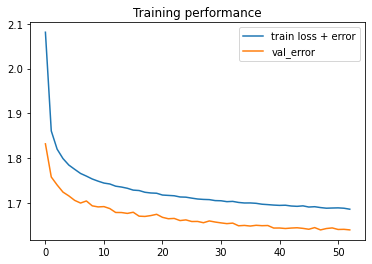

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

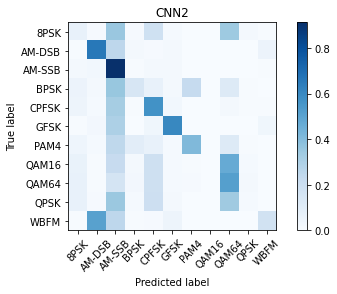

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08766716196136701
Overall Accuracy:  0.09242144177449169


Overall Accuracy:  0.09437963944856839
Overall Accuracy:  0.10189739985945186


Overall Accuracy:  0.12138728323699421
Overall Accuracy:  0.17937701396348013


Overall Accuracy:  0.23539949838767465


Overall Accuracy:  0.3117732558139535


Overall Accuracy:  0.4309549165779198
Overall Accuracy:  0.514018691588785


Overall Accuracy:  0.5058097312999273


Overall Accuracy:  0.5293905517490083


Overall Accuracy:  0.5244781783681215


Overall Accuracy:  0.525


Overall Accuracy:  0.5122478386167147


Overall Accuracy:  0.5242435289828655
Overall Accuracy:  0.5320251758607923


Overall Accuracy:  0.5287702143663031


Overall Accuracy:  0.530213706705969


Overall Accuracy:  0.5315412186379929


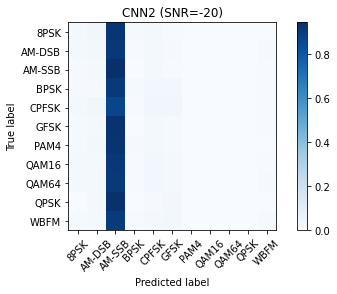

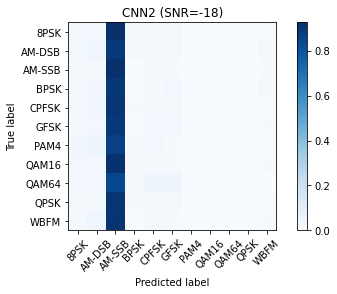

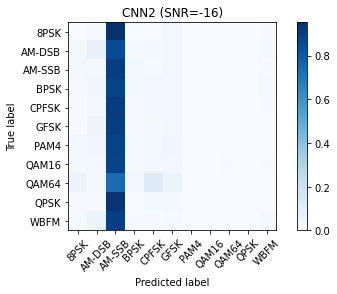

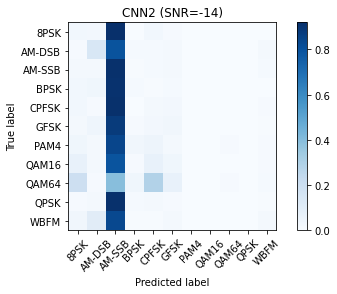

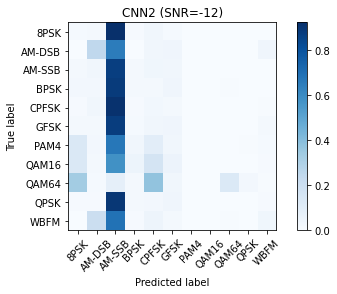

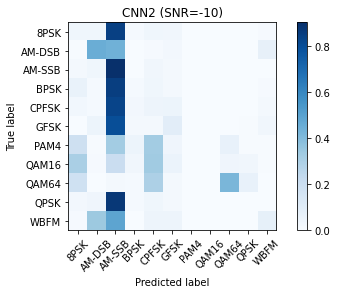

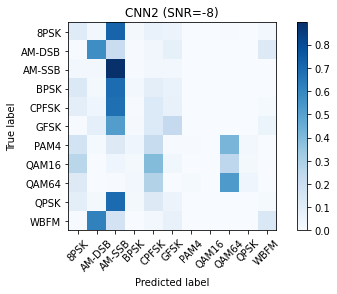

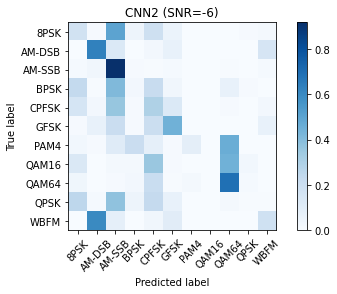

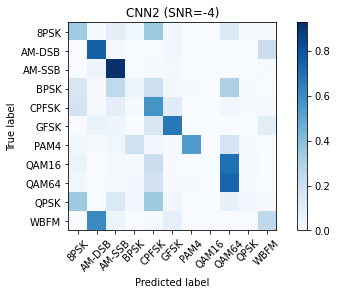

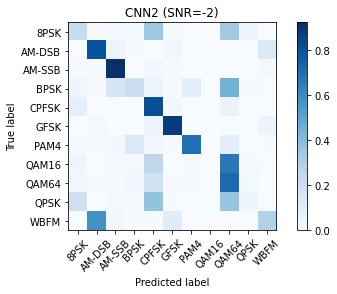

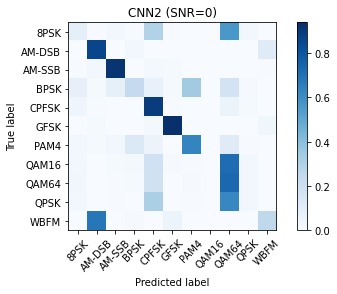

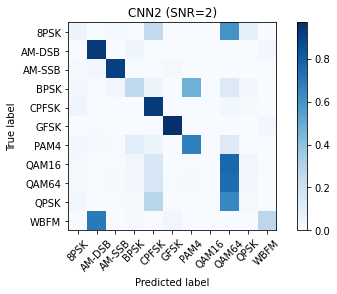

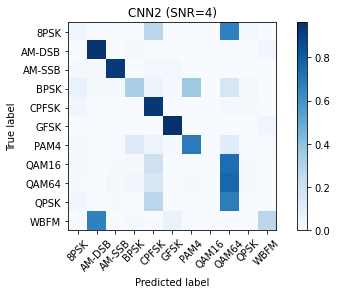

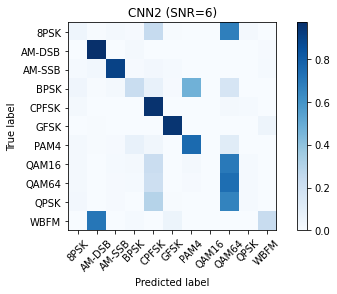

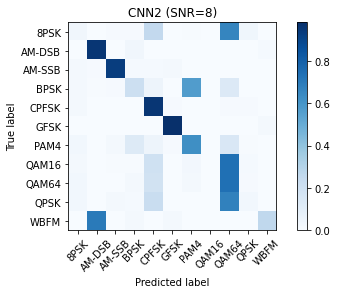

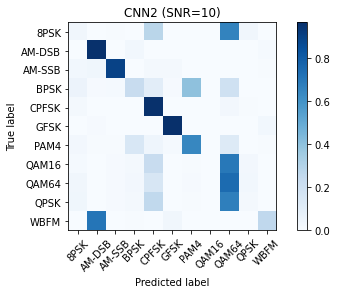

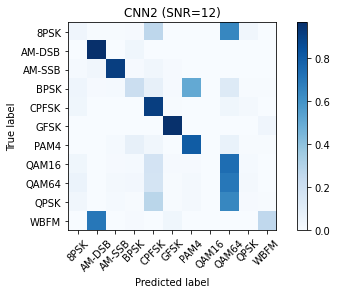

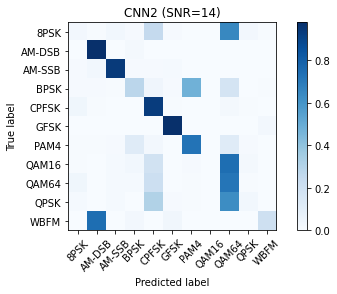

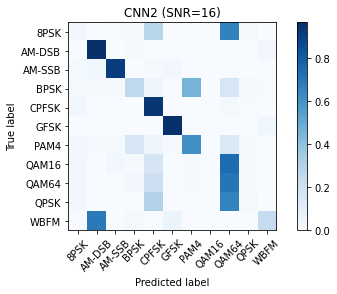

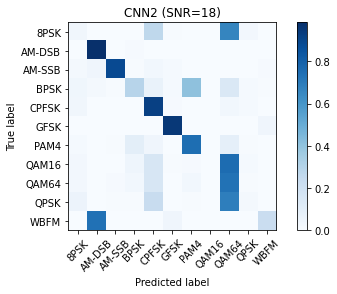

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,12,17,23,31,43,51,50,52,52,52,51,52,53,52,53,53


In [18]:
import statistics

statistics.mean(acc.values())

0.37064982236001903

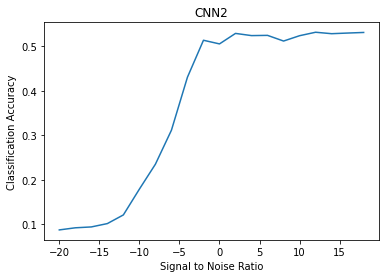

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)